# Семантическая сегментация изображений.

## 0. Установка зависимостей.

In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
from time import time
import torch.optim as optim
from skimage.io import imread
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.autograd import Variable
from skimage.transform import resize
from tqdm import tqdm, tqdm_notebook
from torch.utils.data import DataLoader, Dataset

## 1. Загрузка данных.

В данном задании мы будем сегментировать датасет, состоящий из двух типов поражений кожи: меланом и родинок. Источник датасета находится [здесь](https://www.fc.up.pt/addi/ph2%20database.html), ссылка для [скачивания](https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar).

Загрузим датасет в Google Drive и получим доступ к нему с помощью следующего кода:

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [57]:
DATASET_PATH = '/content/gdrive/MyDrive/for github (do not delete)/semantic_segmentation/PH2Dataset/PH2 Dataset images/'

Создадим два массива, в одном будем хранить исходные изображения, во втором их маски:

In [58]:
images = []
lesions = []

for root, dirs, files in os.walk(DATASET_PATH):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

В этом датасете изображения имеют разные размеры. Изменим их размер на $256\times256 $ пикселей. Для этого будем использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize). Она автоматически нормализует изображения в диапазоне $[0,1]$.


In [59]:
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=True) for y in lesions]

In [ ]:
X[0].dtype

dtype('float64')

Переведем тип данных в float32:

In [60]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)

In [ ]:
print(X[0].shape)
print(Y[0].shape)

(256, 256, 3)
(256, 256)


Посмотрим на наши изображения и их маски:

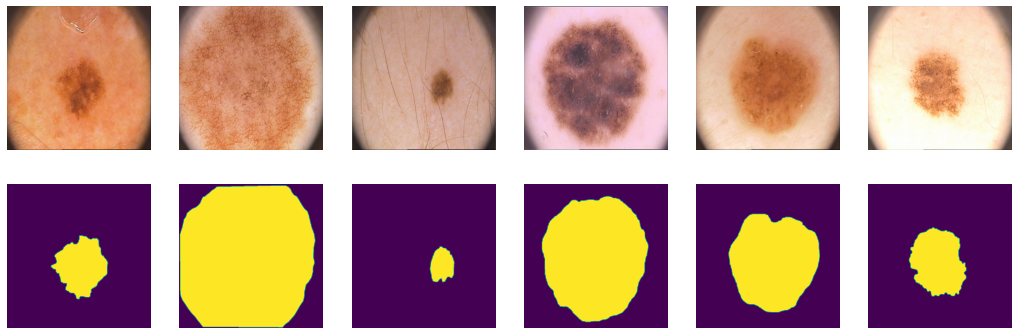

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Проверим количество изображений в датасете:

In [ ]:
len(X), len(Y)

(200, 200)

Разделим исходный датасет на обучающую (50%), валидационную (25%) и тестовую (25%) выборки:

*Важное замечание, почему мы не можем использовать два train_test_split из sklearn.model_selection ([источник](https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test)):*

*Each data split involves data copying. So when you suggest to use two separate split operations instead of one you artificially create burden on both RAM and CPU.*

In [61]:
np.random.seed(42)
torch.manual_seed(42)

In [62]:
# выберем случайные индексы
random_indices = np.random.choice(a=len(X), size=len(X), replace=False)

In [63]:
# разделим датасет на выборки
train_set, val_set, test_set = np.split(random_indices, [100, 150])

In [ ]:
len(train_set), len(val_set), len(test_set)

(100, 50, 50)

## 2. Подготовка DataLoader.

Определим размер батчей и подготовим данные для работы с нейросетями:

In [64]:
BATCH_SIZE = 5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [65]:
DATA_MODES = ['train', 'val', 'test']
class MelanomaDataset(Dataset):
  def __init__(self, images, labels, mode):
    super().__init__()
    self.images = images
    self.labels = labels
    self.mode = mode # режим работы
    if self.mode not in DATA_MODES:
      print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
      raise NameError
                      
  def __len__(self): # returns the size of the dataset
    return len(self.images)
  
  def __getitem__(self, index): # returns the ith datapoint
    transform_train = transforms.Compose([
            transforms.ToTensor()])
    transform_val_test = transforms.Compose([
            transforms.ToTensor()])
    x = self.images[index]
    if self.mode == 'test' or self.mode == 'val':
      x = transform_val_test(x)
    else:
      x = transform_train(x)
    y = self.labels[index]
    return x, y

In [66]:
def get_image(arr, indices):
  result = []
  for i in indices:
    result.append(arr[i])
  return result

In [67]:
train_images, train_labels = get_image(X, train_set), get_image(Y, train_set)
val_images, val_labels = get_image(X, val_set), get_image(Y, val_set)
test_images, test_labels = get_image(X, test_set), get_image(Y, test_set)

In [68]:
train_dataset = MelanomaDataset(train_images, train_labels, mode='train')
val_dataset = MelanomaDataset(val_images, val_labels, mode='val')
test_dataset = MelanomaDataset(test_images, test_labels, mode='test')

In [69]:
train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## 3. SegNet.

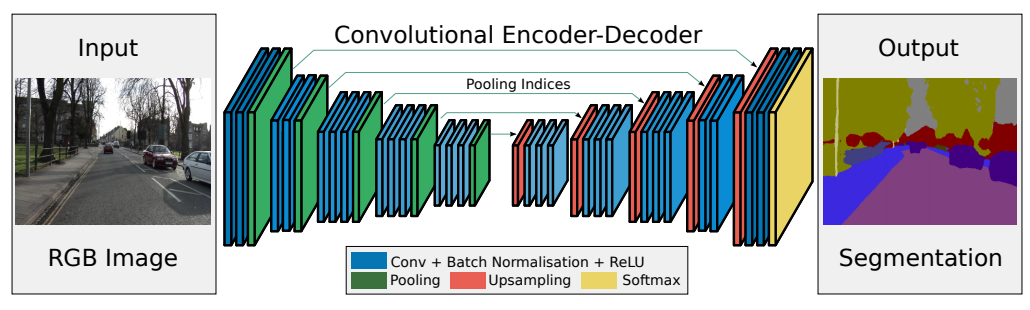

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [45]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.bottleneck_pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.bottleneck_upsample = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.bottleneck_deconv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())

        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())

        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU(),
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=1))

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e0, indices_0 = self.pool0(e0)
        e1 = self.enc_conv1(e0)
        e1, indices_1 = self.pool1(e1)
        e2 = self.enc_conv2(e1)
        e2, indices_2 = self.pool2(e2)
        e3 = self.enc_conv3(e2)
        e3, indices_3 = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(e3)
        b, indices_b = self.bottleneck_pool(b)
        b = self.bottleneck_upsample(b, indices_b)
        b = self.bottleneck_deconv(b)

        # decoder
        d0 = self.upsample0(b, indices_3)
        d0 = self.dec_conv0(d0)
        d1 = self.upsample1(d0, indices_2)
        d1 = self.dec_conv1(d1)
        d2 = self.upsample2(d1, indices_1)
        d2 = self.dec_conv2(d2)
        d3 = self.upsample3(d2, indices_0)
        d3 = self.dec_conv3(d3)  # no activation
        return d3

## 4. Метрика.

Для оценки качества работы модели будем использовать следующую метрику:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [244]:
def iou_pytorch(outputs, labels):
    with torch.no_grad():
        intersection = torch.logical_and(labels, outputs)
        union = torch.logical_or(labels, outputs)
        iou = torch.true_divide(torch.sum(intersection), torch.sum(union))
    return iou

## 5. Функция потерь.

Определим оптимизатор и функцию потерь.

Функция потерь - это то, что мы пытаемся минимизировать. Популярной функцией потерь для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ - это реальное значение, а $\hat y$  - значение, предсказанное моделью. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), которая преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.Однако, эта функция потерь страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. 

Рекомендуется использовать следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна предыдущей, но не так подвержена численной неустойчивости.

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [245]:
def bce_loss(y_pred, y_real):
    y_pred = y_pred.squeeze()
    bce = y_pred - y_pred * y_real + torch.log(1 + torch.exp(-y_pred))
    bce = torch.mean(bce)
    return bce

## 6. Обучение.

Определим цикл обучения в функции, чтобы его можно было использовать повторно.

In [246]:
def fit_epoch(model, train_loader, optimizer, criterion):
    avg_train_loss = 0
    avg_train_acc = 0
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        train_loss = criterion(outputs, labels)
        avg_train_loss += train_loss
        train_acc = iou_pytorch(torch.sigmoid(outputs.squeeze()).round(), labels).mean().item()
        avg_train_acc += train_acc
        train_loss.backward()
        optimizer.step()
    avg_train_acc = avg_train_acc / len(train_loader)
    avg_train_loss = avg_train_loss / len(train_loader)
    return avg_train_loss, avg_train_acc

In [247]:
def eval_epoch(model, val_loader, criterion):
    avg_val_loss = 0
    avg_val_acc = 0
    model.eval()
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            avg_val_loss += val_loss
            val_acc = iou_pytorch(torch.sigmoid(outputs.squeeze()).round(), labels).mean().item()
            avg_val_acc += val_acc
    avg_val_acc = avg_val_acc / len(val_loader)
    avg_val_loss = avg_val_loss / len(val_loader)
    return avg_val_loss, avg_val_acc

In [248]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, data_tr, opt, loss_fn)
            val_loss, val_acc = eval_epoch(model, data_val, loss_fn)
            history.append((train_loss, train_acc, val_loss, val_acc))
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch + 1, t_loss=train_loss, v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
        if epoch > 10:
          scheduler.step()
    return history

Определим функцию для прогнозирования сегментации на новых данных:

In [71]:
def predict(model, X):
    model.eval()
    with torch.set_grad_enabled(False):
        outputs = model(X.to(DEVICE))
    outputs = torch.sigmoid(outputs.squeeze()).round().detach().to('cpu').numpy()
    return outputs

Определим функцию оценки модели:

In [251]:
def score_model(model, test_loader):
    model.eval()
    scores = 0
    for X_batch, Y_batch in test_loader:
      with torch.set_grad_enabled(False):
        outputs = model(X_batch)
        scores += iou_pytorch(torch.sigmoid(outputs.squeeze()).round(), Y_batch).mean().item()
    return scores/len(test_loader)

Определим вспомогательные функции визуализации:

In [252]:
def visualize(model):
    X_val, Y_val = next(iter(val_dl))
    plt.figure(figsize=(10,5))
    for k in range(BATCH_SIZE):
        plt.subplot(3, BATCH_SIZE, k+1)
        plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
        plt.title('Real')
        plt.axis('off')

        plt.subplot(3, BATCH_SIZE, k+1+BATCH_SIZE)
        plt.imshow(Y_val[k].numpy(), cmap='gray')
        plt.title('Target')
        plt.axis('off')

        plt.subplot(3, BATCH_SIZE, k+1+2*BATCH_SIZE)
        prediction = predict(model, X_val)
        plt.imshow(prediction[k], cmap='gray')
        plt.title('Prediction')
        plt.axis('off')
    plt.show()

In [253]:
# график изменения качества модели в течение эпох
def plot_metric(acc, val_acc):
    plt.figure(figsize=(15, 9))
    plt.plot(acc, label="train_acc")
    plt.plot(val_acc, label="val_acc")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("acc")
    plt.show()

In [254]:
# график изменения лосса в течение эпох
def plot_loss(loss, val_loss):
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

Обучим модель:

In [ ]:
model_segnet_bce = SegNet().to(DEVICE)

In [ ]:
max_epochs = 100
optimizer = optim.AdamW(model_segnet_bce.parameters(), lr=0.01, weight_decay=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
torch.cuda.empty_cache()
history_segnet_bce = train(model_segnet_bce, optimizer, bce_loss, max_epochs, train_dl, val_dl)

epoch:   1%|          | 1/100 [00:04<07:15,  4.39s/it]


Epoch 001 train_loss: 0.5947 val_loss 0.6706 train_acc 0.0072 val_acc 0.0000


epoch:   2%|▏         | 2/100 [00:08<07:10,  4.39s/it]


Epoch 002 train_loss: 0.4827 val_loss 0.6155 train_acc 0.0000 val_acc 0.0000


epoch:   3%|▎         | 3/100 [00:13<07:06,  4.40s/it]


Epoch 003 train_loss: 0.4229 val_loss 0.6150 train_acc 0.4128 val_acc 0.4207


epoch:   4%|▍         | 4/100 [00:17<07:03,  4.41s/it]


Epoch 004 train_loss: 0.3939 val_loss 0.4957 train_acc 0.6802 val_acc 0.5033


epoch:   5%|▌         | 5/100 [00:22<07:01,  4.43s/it]


Epoch 005 train_loss: 0.3755 val_loss 0.4230 train_acc 0.7011 val_acc 0.6007


epoch:   6%|▌         | 6/100 [00:26<06:58,  4.45s/it]


Epoch 006 train_loss: 0.3575 val_loss 0.3610 train_acc 0.6894 val_acc 0.6668


epoch:   7%|▋         | 7/100 [00:31<06:55,  4.47s/it]


Epoch 007 train_loss: 0.3151 val_loss 0.3833 train_acc 0.7405 val_acc 0.6774


epoch:   8%|▊         | 8/100 [00:35<06:52,  4.49s/it]


Epoch 008 train_loss: 0.3619 val_loss 0.4374 train_acc 0.6833 val_acc 0.5767


epoch:   9%|▉         | 9/100 [00:40<06:48,  4.49s/it]


Epoch 009 train_loss: 0.3130 val_loss 0.3599 train_acc 0.7283 val_acc 0.7081


epoch:  10%|█         | 10/100 [00:44<06:44,  4.49s/it]


Epoch 010 train_loss: 0.3211 val_loss 0.3014 train_acc 0.7391 val_acc 0.6799


epoch:  11%|█         | 11/100 [00:49<06:39,  4.49s/it]


Epoch 011 train_loss: 0.3056 val_loss 0.3140 train_acc 0.7479 val_acc 0.6974


epoch:  12%|█▏        | 12/100 [00:53<06:33,  4.47s/it]


Epoch 012 train_loss: 0.3019 val_loss 0.3215 train_acc 0.7432 val_acc 0.7009


epoch:  13%|█▎        | 13/100 [00:57<06:27,  4.45s/it]


Epoch 013 train_loss: 0.3429 val_loss 0.3148 train_acc 0.6974 val_acc 0.6996


epoch:  14%|█▍        | 14/100 [01:02<06:21,  4.44s/it]


Epoch 014 train_loss: 0.3363 val_loss 0.3731 train_acc 0.6485 val_acc 0.6195


epoch:  15%|█▌        | 15/100 [01:06<06:16,  4.42s/it]


Epoch 015 train_loss: 0.2917 val_loss 0.3528 train_acc 0.7302 val_acc 0.6321


epoch:  16%|█▌        | 16/100 [01:11<06:10,  4.41s/it]


Epoch 016 train_loss: 0.3080 val_loss 0.3877 train_acc 0.7078 val_acc 0.6027


epoch:  17%|█▋        | 17/100 [01:15<06:05,  4.40s/it]


Epoch 017 train_loss: 0.3149 val_loss 0.3547 train_acc 0.6917 val_acc 0.6879


epoch:  18%|█▊        | 18/100 [01:19<06:00,  4.40s/it]


Epoch 018 train_loss: 0.2903 val_loss 0.2752 train_acc 0.7372 val_acc 0.7500


epoch:  19%|█▉        | 19/100 [01:24<05:56,  4.40s/it]


Epoch 019 train_loss: 0.2855 val_loss 0.3191 train_acc 0.7324 val_acc 0.6806


epoch:  20%|██        | 20/100 [01:28<05:51,  4.40s/it]


Epoch 020 train_loss: 0.2827 val_loss 0.2715 train_acc 0.7474 val_acc 0.7035


epoch:  21%|██        | 21/100 [01:33<05:47,  4.40s/it]


Epoch 021 train_loss: 0.2804 val_loss 0.3474 train_acc 0.7167 val_acc 0.6539


epoch:  22%|██▏       | 22/100 [01:37<05:43,  4.41s/it]


Epoch 022 train_loss: 0.3009 val_loss 0.3970 train_acc 0.7241 val_acc 0.4840


epoch:  23%|██▎       | 23/100 [01:42<05:40,  4.42s/it]


Epoch 023 train_loss: 0.2941 val_loss 0.2668 train_acc 0.7408 val_acc 0.7396


epoch:  24%|██▍       | 24/100 [01:46<05:36,  4.43s/it]


Epoch 024 train_loss: 0.2947 val_loss 0.2946 train_acc 0.7172 val_acc 0.7328


epoch:  25%|██▌       | 25/100 [01:50<05:32,  4.43s/it]


Epoch 025 train_loss: 0.2751 val_loss 0.2604 train_acc 0.7311 val_acc 0.7502


epoch:  26%|██▌       | 26/100 [01:55<05:28,  4.44s/it]


Epoch 026 train_loss: 0.2892 val_loss 0.2637 train_acc 0.7270 val_acc 0.7375


epoch:  27%|██▋       | 27/100 [01:59<05:24,  4.44s/it]


Epoch 027 train_loss: 0.2467 val_loss 0.2443 train_acc 0.7616 val_acc 0.7544


epoch:  28%|██▊       | 28/100 [02:04<05:19,  4.44s/it]


Epoch 028 train_loss: 0.2467 val_loss 0.2492 train_acc 0.7575 val_acc 0.7646


epoch:  29%|██▉       | 29/100 [02:08<05:14,  4.44s/it]


Epoch 029 train_loss: 0.2591 val_loss 0.2626 train_acc 0.7517 val_acc 0.7506


epoch:  30%|███       | 30/100 [02:13<05:10,  4.43s/it]


Epoch 030 train_loss: 0.2787 val_loss 0.3184 train_acc 0.7394 val_acc 0.7198


epoch:  31%|███       | 31/100 [02:17<05:05,  4.43s/it]


Epoch 031 train_loss: 0.3202 val_loss 0.2690 train_acc 0.6860 val_acc 0.6930


epoch:  32%|███▏      | 32/100 [02:21<05:01,  4.43s/it]


Epoch 032 train_loss: 0.2639 val_loss 0.3543 train_acc 0.7438 val_acc 0.6647


epoch:  33%|███▎      | 33/100 [02:26<04:56,  4.42s/it]


Epoch 033 train_loss: 0.2719 val_loss 0.2461 train_acc 0.7245 val_acc 0.7498


epoch:  34%|███▍      | 34/100 [02:30<04:51,  4.42s/it]


Epoch 034 train_loss: 0.2578 val_loss 0.2345 train_acc 0.7396 val_acc 0.7433


epoch:  35%|███▌      | 35/100 [02:35<04:47,  4.42s/it]


Epoch 035 train_loss: 0.2438 val_loss 0.2225 train_acc 0.7601 val_acc 0.7663


epoch:  36%|███▌      | 36/100 [02:39<04:42,  4.42s/it]


Epoch 036 train_loss: 0.2356 val_loss 0.2780 train_acc 0.7563 val_acc 0.6957


epoch:  37%|███▋      | 37/100 [02:43<04:38,  4.42s/it]


Epoch 037 train_loss: 0.2393 val_loss 0.2243 train_acc 0.7488 val_acc 0.7777


epoch:  38%|███▊      | 38/100 [02:48<04:33,  4.42s/it]


Epoch 038 train_loss: 0.2415 val_loss 0.2477 train_acc 0.7582 val_acc 0.7263


epoch:  39%|███▉      | 39/100 [02:52<04:29,  4.42s/it]


Epoch 039 train_loss: 0.2643 val_loss 0.2931 train_acc 0.7299 val_acc 0.6799


epoch:  40%|████      | 40/100 [02:57<04:25,  4.42s/it]


Epoch 040 train_loss: 0.2546 val_loss 0.3268 train_acc 0.7401 val_acc 0.7000


epoch:  41%|████      | 41/100 [03:01<04:20,  4.42s/it]


Epoch 041 train_loss: 0.2609 val_loss 0.2502 train_acc 0.7201 val_acc 0.7253


epoch:  42%|████▏     | 42/100 [03:06<04:16,  4.42s/it]


Epoch 042 train_loss: 0.2851 val_loss 0.5044 train_acc 0.7044 val_acc 0.5232


epoch:  43%|████▎     | 43/100 [03:10<04:12,  4.42s/it]


Epoch 043 train_loss: 0.2543 val_loss 0.4126 train_acc 0.7096 val_acc 0.6333


epoch:  44%|████▍     | 44/100 [03:14<04:07,  4.43s/it]


Epoch 044 train_loss: 0.2625 val_loss 0.2617 train_acc 0.7479 val_acc 0.7026


epoch:  45%|████▌     | 45/100 [03:19<04:03,  4.42s/it]


Epoch 045 train_loss: 0.2312 val_loss 0.2785 train_acc 0.7667 val_acc 0.6669


epoch:  46%|████▌     | 46/100 [03:23<03:59,  4.43s/it]


Epoch 046 train_loss: 0.2758 val_loss 0.2426 train_acc 0.7340 val_acc 0.7397


epoch:  47%|████▋     | 47/100 [03:28<03:54,  4.43s/it]


Epoch 047 train_loss: 0.2602 val_loss 0.2651 train_acc 0.7407 val_acc 0.7177


epoch:  48%|████▊     | 48/100 [03:32<03:50,  4.43s/it]


Epoch 048 train_loss: 0.2524 val_loss 0.2278 train_acc 0.7466 val_acc 0.7437


epoch:  49%|████▉     | 49/100 [03:37<03:45,  4.43s/it]


Epoch 049 train_loss: 0.2415 val_loss 0.2210 train_acc 0.7720 val_acc 0.7891


epoch:  50%|█████     | 50/100 [03:41<03:41,  4.43s/it]


Epoch 050 train_loss: 0.2398 val_loss 0.2250 train_acc 0.7642 val_acc 0.7760


epoch:  51%|█████     | 51/100 [03:46<03:37,  4.43s/it]


Epoch 051 train_loss: 0.2597 val_loss 0.2366 train_acc 0.7319 val_acc 0.7618


epoch:  52%|█████▏    | 52/100 [03:50<03:32,  4.43s/it]


Epoch 052 train_loss: 0.2433 val_loss 0.2237 train_acc 0.7437 val_acc 0.7595


epoch:  53%|█████▎    | 53/100 [03:54<03:28,  4.43s/it]


Epoch 053 train_loss: 0.2370 val_loss 0.2384 train_acc 0.7457 val_acc 0.7289


epoch:  54%|█████▍    | 54/100 [03:59<03:23,  4.43s/it]


Epoch 054 train_loss: 0.2432 val_loss 0.2315 train_acc 0.7403 val_acc 0.7554


epoch:  55%|█████▌    | 55/100 [04:03<03:19,  4.43s/it]


Epoch 055 train_loss: 0.2564 val_loss 0.2554 train_acc 0.7334 val_acc 0.7545


epoch:  56%|█████▌    | 56/100 [04:08<03:15,  4.43s/it]


Epoch 056 train_loss: 0.2176 val_loss 0.3543 train_acc 0.7602 val_acc 0.6607


epoch:  57%|█████▋    | 57/100 [04:12<03:10,  4.43s/it]


Epoch 057 train_loss: 0.2089 val_loss 0.2804 train_acc 0.7718 val_acc 0.6786


epoch:  58%|█████▊    | 58/100 [04:17<03:06,  4.43s/it]


Epoch 058 train_loss: 0.2408 val_loss 0.2752 train_acc 0.7481 val_acc 0.6514


epoch:  59%|█████▉    | 59/100 [04:21<03:01,  4.43s/it]


Epoch 059 train_loss: 0.2342 val_loss 0.2672 train_acc 0.7465 val_acc 0.6987


epoch:  60%|██████    | 60/100 [04:25<02:57,  4.43s/it]


Epoch 060 train_loss: 0.2513 val_loss 0.2238 train_acc 0.7367 val_acc 0.7646


epoch:  61%|██████    | 61/100 [04:30<02:52,  4.43s/it]


Epoch 061 train_loss: 0.2110 val_loss 0.2206 train_acc 0.7969 val_acc 0.7603


epoch:  62%|██████▏   | 62/100 [04:34<02:48,  4.43s/it]


Epoch 062 train_loss: 0.1970 val_loss 0.2342 train_acc 0.7971 val_acc 0.7567


epoch:  63%|██████▎   | 63/100 [04:39<02:43,  4.43s/it]


Epoch 063 train_loss: 0.2234 val_loss 0.2337 train_acc 0.7722 val_acc 0.7667


epoch:  64%|██████▍   | 64/100 [04:43<02:39,  4.43s/it]


Epoch 064 train_loss: 0.2205 val_loss 0.2193 train_acc 0.7910 val_acc 0.7593


epoch:  65%|██████▌   | 65/100 [04:48<02:35,  4.43s/it]


Epoch 065 train_loss: 0.1933 val_loss 0.2432 train_acc 0.7985 val_acc 0.7473


epoch:  66%|██████▌   | 66/100 [04:52<02:30,  4.43s/it]


Epoch 066 train_loss: 0.2666 val_loss 0.2801 train_acc 0.7321 val_acc 0.6564


epoch:  67%|██████▋   | 67/100 [04:56<02:26,  4.43s/it]


Epoch 067 train_loss: 0.2243 val_loss 0.2764 train_acc 0.7606 val_acc 0.7208


epoch:  68%|██████▊   | 68/100 [05:01<02:21,  4.43s/it]


Epoch 068 train_loss: 0.2611 val_loss 0.2535 train_acc 0.7330 val_acc 0.7470


epoch:  69%|██████▉   | 69/100 [05:05<02:17,  4.43s/it]


Epoch 069 train_loss: 0.2398 val_loss 0.2263 train_acc 0.7409 val_acc 0.7569


epoch:  70%|███████   | 70/100 [05:10<02:12,  4.43s/it]


Epoch 070 train_loss: 0.1928 val_loss 0.2128 train_acc 0.7940 val_acc 0.7737


epoch:  71%|███████   | 71/100 [05:14<02:08,  4.43s/it]


Epoch 071 train_loss: 0.2025 val_loss 0.2386 train_acc 0.7859 val_acc 0.7251


epoch:  72%|███████▏  | 72/100 [05:19<02:03,  4.43s/it]


Epoch 072 train_loss: 0.2182 val_loss 0.2462 train_acc 0.7622 val_acc 0.7376


epoch:  73%|███████▎  | 73/100 [05:23<01:59,  4.42s/it]


Epoch 073 train_loss: 0.2444 val_loss 0.2412 train_acc 0.7521 val_acc 0.7438


epoch:  74%|███████▍  | 74/100 [05:27<01:54,  4.42s/it]


Epoch 074 train_loss: 0.1900 val_loss 0.2943 train_acc 0.8004 val_acc 0.6922


epoch:  75%|███████▌  | 75/100 [05:32<01:50,  4.42s/it]


Epoch 075 train_loss: 0.2055 val_loss 0.2465 train_acc 0.7917 val_acc 0.7342


epoch:  76%|███████▌  | 76/100 [05:36<01:45,  4.41s/it]


Epoch 076 train_loss: 0.2274 val_loss 0.2182 train_acc 0.7459 val_acc 0.7819


epoch:  77%|███████▋  | 77/100 [05:41<01:41,  4.41s/it]


Epoch 077 train_loss: 0.2080 val_loss 0.2381 train_acc 0.7955 val_acc 0.7434


epoch:  78%|███████▊  | 78/100 [05:45<01:37,  4.41s/it]


Epoch 078 train_loss: 0.2159 val_loss 0.2172 train_acc 0.7764 val_acc 0.7464


epoch:  79%|███████▉  | 79/100 [05:49<01:32,  4.41s/it]


Epoch 079 train_loss: 0.1741 val_loss 0.1932 train_acc 0.8143 val_acc 0.8059


epoch:  80%|████████  | 80/100 [05:54<01:28,  4.42s/it]


Epoch 080 train_loss: 0.1882 val_loss 0.2223 train_acc 0.7921 val_acc 0.7770


epoch:  81%|████████  | 81/100 [05:58<01:23,  4.42s/it]


Epoch 081 train_loss: 0.2053 val_loss 0.2644 train_acc 0.7889 val_acc 0.7055


epoch:  82%|████████▏ | 82/100 [06:03<01:19,  4.42s/it]


Epoch 082 train_loss: 0.1829 val_loss 0.2044 train_acc 0.8122 val_acc 0.7881


epoch:  83%|████████▎ | 83/100 [06:07<01:15,  4.42s/it]


Epoch 083 train_loss: 0.2021 val_loss 0.3111 train_acc 0.7970 val_acc 0.7119


epoch:  84%|████████▍ | 84/100 [06:12<01:10,  4.42s/it]


Epoch 084 train_loss: 0.2299 val_loss 0.2203 train_acc 0.7521 val_acc 0.7689


epoch:  85%|████████▌ | 85/100 [06:16<01:06,  4.43s/it]


Epoch 085 train_loss: 0.2069 val_loss 0.2743 train_acc 0.7744 val_acc 0.6840


epoch:  86%|████████▌ | 86/100 [06:20<01:02,  4.43s/it]


Epoch 086 train_loss: 0.2029 val_loss 0.2168 train_acc 0.7891 val_acc 0.7651


epoch:  87%|████████▋ | 87/100 [06:25<00:57,  4.43s/it]


Epoch 087 train_loss: 0.1805 val_loss 0.2650 train_acc 0.8108 val_acc 0.7120


epoch:  88%|████████▊ | 88/100 [06:29<00:53,  4.43s/it]


Epoch 088 train_loss: 0.2244 val_loss 0.2407 train_acc 0.7745 val_acc 0.7441


epoch:  89%|████████▉ | 89/100 [06:34<00:48,  4.43s/it]


Epoch 089 train_loss: 0.2279 val_loss 0.1960 train_acc 0.7512 val_acc 0.8077


epoch:  90%|█████████ | 90/100 [06:38<00:44,  4.43s/it]


Epoch 090 train_loss: 0.1824 val_loss 0.2107 train_acc 0.8016 val_acc 0.7858


epoch:  91%|█████████ | 91/100 [06:43<00:39,  4.43s/it]


Epoch 091 train_loss: 0.2171 val_loss 0.2071 train_acc 0.7689 val_acc 0.7793


epoch:  92%|█████████▏| 92/100 [06:47<00:35,  4.43s/it]


Epoch 092 train_loss: 0.1653 val_loss 0.2187 train_acc 0.8209 val_acc 0.7743


epoch:  93%|█████████▎| 93/100 [06:51<00:30,  4.43s/it]


Epoch 093 train_loss: 0.1623 val_loss 0.1965 train_acc 0.8359 val_acc 0.7815


epoch:  94%|█████████▍| 94/100 [06:56<00:26,  4.43s/it]


Epoch 094 train_loss: 0.1688 val_loss 0.2168 train_acc 0.8215 val_acc 0.7402


epoch:  95%|█████████▌| 95/100 [07:00<00:22,  4.43s/it]


Epoch 095 train_loss: 0.1668 val_loss 0.1902 train_acc 0.8164 val_acc 0.7926


epoch:  96%|█████████▌| 96/100 [07:05<00:17,  4.43s/it]


Epoch 096 train_loss: 0.1738 val_loss 0.2306 train_acc 0.8121 val_acc 0.7403


epoch:  97%|█████████▋| 97/100 [07:09<00:13,  4.42s/it]


Epoch 097 train_loss: 0.1523 val_loss 0.2093 train_acc 0.8324 val_acc 0.7873


epoch:  98%|█████████▊| 98/100 [07:14<00:08,  4.42s/it]


Epoch 098 train_loss: 0.1985 val_loss 0.2016 train_acc 0.8057 val_acc 0.7996


epoch:  99%|█████████▉| 99/100 [07:18<00:04,  4.42s/it]


Epoch 099 train_loss: 0.1683 val_loss 0.1915 train_acc 0.8216 val_acc 0.8033


epoch: 100%|██████████| 100/100 [07:22<00:00,  4.43s/it]


Epoch 100 train_loss: 0.1590 val_loss 0.2349 train_acc 0.8363 val_acc 0.7439


Визуализируем результат:

In [ ]:
loss, acc, val_loss, val_acc = zip(*history_segnet_bce)

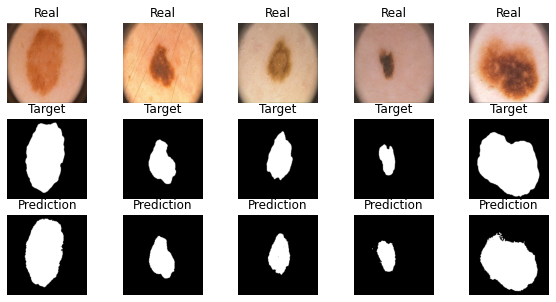

In [ ]:
visualize(model_segnet_bce)

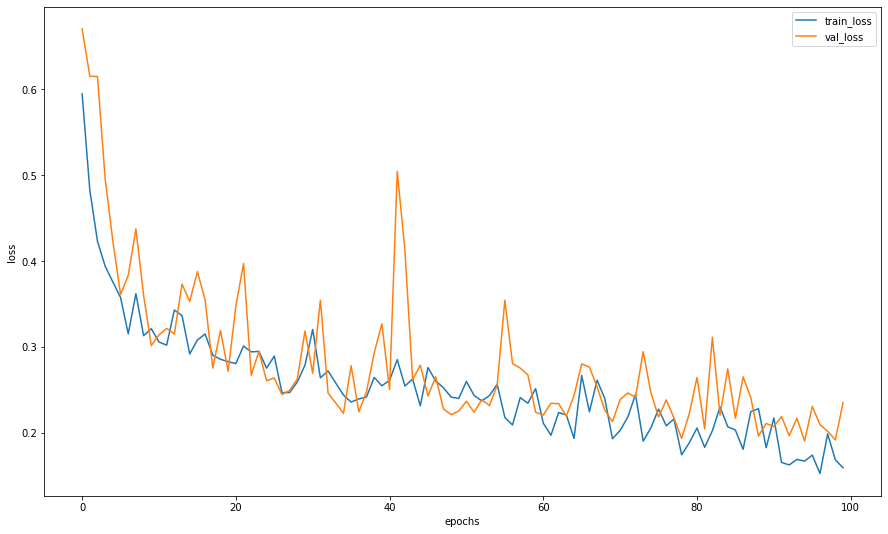

In [ ]:
plot_loss(loss, val_loss)

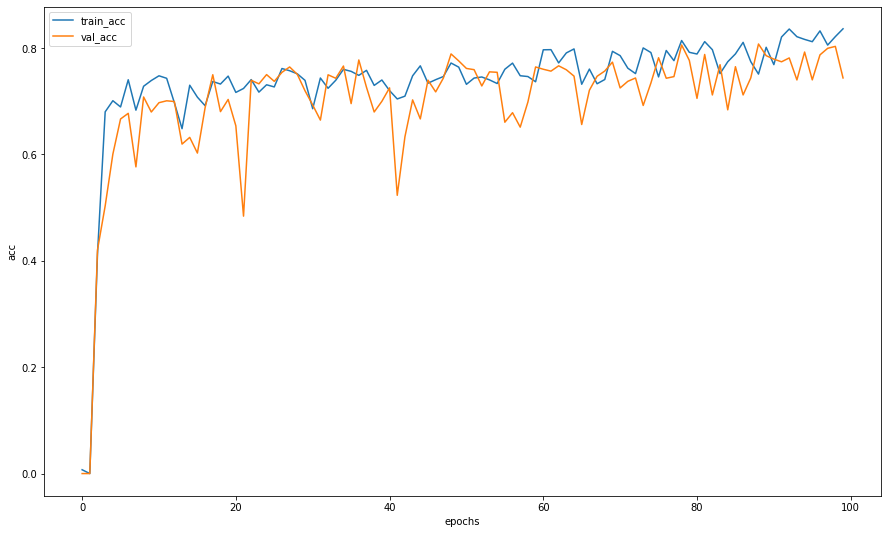

In [ ]:
plot_metric(acc, val_acc)

Сохраним модель и ее результаты:

In [ ]:
model_save_name = 'model_segnet_bce.pth'
path = F"/content/gdrive/My Drive/DLS/nevus/{model_save_name}" 
torch.save(model_segnet_bce.state_dict(), path)

In [ ]:
np.save(F"/content/gdrive/My Drive/DLS/nevus/history_segnet_bce.npy" , history_segnet_bce)

In [ ]:
del model_segnet_bce

-----------------------------------------------------------------------------------------

## 7. Дополнительные функции потерь.

 В данном разделе нам потребуется имплементировать две функции потерь: DICE и Focal loss.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$


In [150]:
def dice_loss(y_pred, y_real):
    smooth = 1.
    y_pred = y_pred.squeeze()
    y_pred = torch.clamp(y_pred, 0, 1)
    y_pred = y_pred.contiguous().view(-1)
    y_real = y_real.contiguous().view(-1)
    num = 2. * (y_pred * y_real).sum() + smooth
    den = torch.sum(y_pred * y_pred) + torch.sum(y_real * y_real) + smooth
    res = 1 - (num / den)
    return res 

Протестируем:

In [ ]:
model_segnet_dice = SegNet().to(DEVICE)

In [ ]:
max_epochs = 100
optimizer = optim.Adam(model_segnet_dice.parameters())
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
torch.cuda.empty_cache()
history_segnet_dice = train(model_segnet_dice, optimizer, dice_loss, max_epochs, train_dl, val_dl)

epoch:   1%|          | 1/100 [00:04<07:09,  4.33s/it]


Epoch 001 train_loss: 0.7055 val_loss 1.0000 train_acc 0.2194 val_acc 0.0000


epoch:   2%|▏         | 2/100 [00:08<07:05,  4.34s/it]


Epoch 002 train_loss: 0.4512 val_loss 0.6537 train_acc 0.4115 val_acc 0.2872


epoch:   3%|▎         | 3/100 [00:13<07:02,  4.35s/it]


Epoch 003 train_loss: 0.3283 val_loss 0.3974 train_acc 0.5128 val_acc 0.4343


epoch:   4%|▍         | 4/100 [00:17<06:59,  4.37s/it]


Epoch 004 train_loss: 0.2768 val_loss 0.3030 train_acc 0.5256 val_acc 0.5134


epoch:   5%|▌         | 5/100 [00:21<06:57,  4.39s/it]


Epoch 005 train_loss: 0.2688 val_loss 0.3125 train_acc 0.5263 val_acc 0.4489


epoch:   6%|▌         | 6/100 [00:26<06:54,  4.41s/it]


Epoch 006 train_loss: 0.2718 val_loss 0.2910 train_acc 0.5236 val_acc 0.4869


epoch:   7%|▋         | 7/100 [00:30<06:52,  4.43s/it]


Epoch 007 train_loss: 0.2700 val_loss 0.2862 train_acc 0.4990 val_acc 0.5088


epoch:   8%|▊         | 8/100 [00:35<06:49,  4.45s/it]


Epoch 008 train_loss: 0.2539 val_loss 0.2835 train_acc 0.5245 val_acc 0.4669


epoch:   9%|▉         | 9/100 [00:39<06:45,  4.46s/it]


Epoch 009 train_loss: 0.2491 val_loss 0.3091 train_acc 0.5388 val_acc 0.5141


epoch:  10%|█         | 10/100 [00:44<06:41,  4.46s/it]


Epoch 010 train_loss: 0.2833 val_loss 0.2817 train_acc 0.4761 val_acc 0.5031


epoch:  11%|█         | 11/100 [00:48<06:35,  4.45s/it]


Epoch 011 train_loss: 0.2656 val_loss 0.2769 train_acc 0.5077 val_acc 0.5130


epoch:  12%|█▏        | 12/100 [00:53<06:30,  4.44s/it]


Epoch 012 train_loss: 0.2587 val_loss 0.2761 train_acc 0.5156 val_acc 0.5229


epoch:  13%|█▎        | 13/100 [00:57<06:24,  4.42s/it]


Epoch 013 train_loss: 0.2571 val_loss 0.3097 train_acc 0.4974 val_acc 0.5219


epoch:  14%|█▍        | 14/100 [01:01<06:19,  4.41s/it]


Epoch 014 train_loss: 0.2593 val_loss 0.2558 train_acc 0.4850 val_acc 0.4801


epoch:  15%|█▌        | 15/100 [01:06<06:13,  4.40s/it]


Epoch 015 train_loss: 0.2413 val_loss 0.2655 train_acc 0.5269 val_acc 0.5515


epoch:  16%|█▌        | 16/100 [01:10<06:08,  4.39s/it]


Epoch 016 train_loss: 0.2146 val_loss 0.2087 train_acc 0.5495 val_acc 0.6031


epoch:  17%|█▋        | 17/100 [01:15<06:03,  4.38s/it]


Epoch 017 train_loss: 0.1557 val_loss 0.1274 train_acc 0.5993 val_acc 0.6078


epoch:  18%|█▊        | 18/100 [01:19<05:58,  4.38s/it]


Epoch 018 train_loss: 0.1196 val_loss 0.1210 train_acc 0.6314 val_acc 0.6351


epoch:  19%|█▉        | 19/100 [01:23<05:54,  4.37s/it]


Epoch 019 train_loss: 0.1179 val_loss 0.1393 train_acc 0.6732 val_acc 0.6817


epoch:  20%|██        | 20/100 [01:28<05:49,  4.37s/it]


Epoch 020 train_loss: 0.1206 val_loss 0.1804 train_acc 0.6232 val_acc 0.5036


epoch:  21%|██        | 21/100 [01:32<05:45,  4.38s/it]


Epoch 021 train_loss: 0.1187 val_loss 0.1286 train_acc 0.6474 val_acc 0.6470


epoch:  22%|██▏       | 22/100 [01:36<05:41,  4.38s/it]


Epoch 022 train_loss: 0.1085 val_loss 0.1320 train_acc 0.6350 val_acc 0.6419


epoch:  23%|██▎       | 23/100 [01:41<05:37,  4.39s/it]


Epoch 023 train_loss: 0.1049 val_loss 0.1194 train_acc 0.6566 val_acc 0.6824


epoch:  24%|██▍       | 24/100 [01:45<05:33,  4.39s/it]


Epoch 024 train_loss: 0.1066 val_loss 0.1371 train_acc 0.6593 val_acc 0.5704


epoch:  25%|██▌       | 25/100 [01:50<05:29,  4.40s/it]


Epoch 025 train_loss: 0.1293 val_loss 0.1197 train_acc 0.6185 val_acc 0.6053


epoch:  26%|██▌       | 26/100 [01:54<05:25,  4.41s/it]


Epoch 026 train_loss: 0.1073 val_loss 0.1215 train_acc 0.6621 val_acc 0.6914


epoch:  27%|██▋       | 27/100 [01:58<05:21,  4.41s/it]


Epoch 027 train_loss: 0.1190 val_loss 0.1104 train_acc 0.6318 val_acc 0.6405


epoch:  28%|██▊       | 28/100 [02:03<05:17,  4.41s/it]


Epoch 028 train_loss: 0.1044 val_loss 0.0982 train_acc 0.6674 val_acc 0.7053


epoch:  29%|██▉       | 29/100 [02:07<05:13,  4.41s/it]


Epoch 029 train_loss: 0.1029 val_loss 0.1340 train_acc 0.6616 val_acc 0.6559


epoch:  30%|███       | 30/100 [02:12<05:08,  4.41s/it]


Epoch 030 train_loss: 0.1118 val_loss 0.1046 train_acc 0.6197 val_acc 0.6209


epoch:  31%|███       | 31/100 [02:16<05:04,  4.41s/it]


Epoch 031 train_loss: 0.0992 val_loss 0.1213 train_acc 0.7004 val_acc 0.6240


epoch:  32%|███▏      | 32/100 [02:20<04:59,  4.40s/it]


Epoch 032 train_loss: 0.0920 val_loss 0.0930 train_acc 0.6754 val_acc 0.6907


epoch:  33%|███▎      | 33/100 [02:25<04:54,  4.40s/it]


Epoch 033 train_loss: 0.0853 val_loss 0.1046 train_acc 0.6728 val_acc 0.6948


epoch:  34%|███▍      | 34/100 [02:29<04:50,  4.40s/it]


Epoch 034 train_loss: 0.0890 val_loss 0.1287 train_acc 0.7388 val_acc 0.6883


epoch:  35%|███▌      | 35/100 [02:34<04:45,  4.39s/it]


Epoch 035 train_loss: 0.0900 val_loss 0.0955 train_acc 0.6914 val_acc 0.6917


epoch:  36%|███▌      | 36/100 [02:38<04:41,  4.39s/it]


Epoch 036 train_loss: 0.0797 val_loss 0.1137 train_acc 0.7107 val_acc 0.6991


epoch:  37%|███▋      | 37/100 [02:42<04:36,  4.39s/it]


Epoch 037 train_loss: 0.0889 val_loss 0.1368 train_acc 0.6943 val_acc 0.6789


epoch:  38%|███▊      | 38/100 [02:47<04:32,  4.39s/it]


Epoch 038 train_loss: 0.0923 val_loss 0.1171 train_acc 0.6820 val_acc 0.5754


epoch:  39%|███▉      | 39/100 [02:51<04:28,  4.40s/it]


Epoch 039 train_loss: 0.0863 val_loss 0.1243 train_acc 0.6818 val_acc 0.6510


epoch:  40%|████      | 40/100 [02:56<04:23,  4.40s/it]


Epoch 040 train_loss: 0.0788 val_loss 0.1102 train_acc 0.7197 val_acc 0.7334


epoch:  41%|████      | 41/100 [03:00<04:19,  4.40s/it]


Epoch 041 train_loss: 0.0794 val_loss 0.0936 train_acc 0.7160 val_acc 0.6926


epoch:  42%|████▏     | 42/100 [03:04<04:14,  4.40s/it]


Epoch 042 train_loss: 0.0852 val_loss 0.0922 train_acc 0.7233 val_acc 0.7035


epoch:  43%|████▎     | 43/100 [03:09<04:10,  4.40s/it]


Epoch 043 train_loss: 0.0746 val_loss 0.0937 train_acc 0.7115 val_acc 0.7132


epoch:  44%|████▍     | 44/100 [03:13<04:06,  4.40s/it]


Epoch 044 train_loss: 0.0718 val_loss 0.0892 train_acc 0.7329 val_acc 0.7465


epoch:  45%|████▌     | 45/100 [03:18<04:02,  4.40s/it]


Epoch 045 train_loss: 0.0692 val_loss 0.0978 train_acc 0.7302 val_acc 0.6832


epoch:  46%|████▌     | 46/100 [03:22<03:57,  4.40s/it]


Epoch 046 train_loss: 0.0633 val_loss 0.0794 train_acc 0.7412 val_acc 0.7107


epoch:  47%|████▋     | 47/100 [03:26<03:53,  4.40s/it]


Epoch 047 train_loss: 0.0670 val_loss 0.0897 train_acc 0.7400 val_acc 0.6613


epoch:  48%|████▊     | 48/100 [03:31<03:49,  4.41s/it]


Epoch 048 train_loss: 0.0623 val_loss 0.0827 train_acc 0.7492 val_acc 0.7225


epoch:  49%|████▉     | 49/100 [03:35<03:44,  4.41s/it]


Epoch 049 train_loss: 0.0660 val_loss 0.0821 train_acc 0.7688 val_acc 0.7445


epoch:  50%|█████     | 50/100 [03:40<03:40,  4.41s/it]


Epoch 050 train_loss: 0.0679 val_loss 0.0943 train_acc 0.7367 val_acc 0.7281


epoch:  51%|█████     | 51/100 [03:44<03:35,  4.41s/it]


Epoch 051 train_loss: 0.0723 val_loss 0.0872 train_acc 0.7207 val_acc 0.7232


epoch:  52%|█████▏    | 52/100 [03:48<03:31,  4.40s/it]


Epoch 052 train_loss: 0.0581 val_loss 0.0907 train_acc 0.7471 val_acc 0.7444


epoch:  53%|█████▎    | 53/100 [03:53<03:27,  4.40s/it]


Epoch 053 train_loss: 0.0618 val_loss 0.0780 train_acc 0.7544 val_acc 0.7299


epoch:  54%|█████▍    | 54/100 [03:57<03:22,  4.40s/it]


Epoch 054 train_loss: 0.0581 val_loss 0.0760 train_acc 0.7700 val_acc 0.7212


epoch:  55%|█████▌    | 55/100 [04:02<03:18,  4.40s/it]


Epoch 055 train_loss: 0.0581 val_loss 0.0782 train_acc 0.7888 val_acc 0.7696


epoch:  56%|█████▌    | 56/100 [04:06<03:13,  4.40s/it]


Epoch 056 train_loss: 0.0522 val_loss 0.0772 train_acc 0.7876 val_acc 0.7570


epoch:  57%|█████▋    | 57/100 [04:10<03:09,  4.40s/it]


Epoch 057 train_loss: 0.0507 val_loss 0.0761 train_acc 0.8028 val_acc 0.7675


epoch:  58%|█████▊    | 58/100 [04:15<03:04,  4.40s/it]


Epoch 058 train_loss: 0.0626 val_loss 0.0731 train_acc 0.7692 val_acc 0.7425


epoch:  59%|█████▉    | 59/100 [04:19<03:00,  4.40s/it]


Epoch 059 train_loss: 0.0635 val_loss 0.0836 train_acc 0.7832 val_acc 0.7447


epoch:  60%|██████    | 60/100 [04:24<02:55,  4.40s/it]


Epoch 060 train_loss: 0.0612 val_loss 0.0790 train_acc 0.7704 val_acc 0.7380


epoch:  61%|██████    | 61/100 [04:28<02:51,  4.39s/it]


Epoch 061 train_loss: 0.0498 val_loss 0.0771 train_acc 0.7723 val_acc 0.7535


epoch:  62%|██████▏   | 62/100 [04:32<02:47,  4.40s/it]


Epoch 062 train_loss: 0.0456 val_loss 0.0833 train_acc 0.7959 val_acc 0.7613


epoch:  63%|██████▎   | 63/100 [04:37<02:42,  4.40s/it]


Epoch 063 train_loss: 0.0467 val_loss 0.0750 train_acc 0.7716 val_acc 0.7580


epoch:  64%|██████▍   | 64/100 [04:41<02:38,  4.40s/it]


Epoch 064 train_loss: 0.0499 val_loss 0.0809 train_acc 0.8064 val_acc 0.7826


epoch:  65%|██████▌   | 65/100 [04:46<02:33,  4.39s/it]


Epoch 065 train_loss: 0.0481 val_loss 0.0694 train_acc 0.7761 val_acc 0.7639


epoch:  66%|██████▌   | 66/100 [04:50<02:29,  4.39s/it]


Epoch 066 train_loss: 0.0440 val_loss 0.0698 train_acc 0.8153 val_acc 0.7737


epoch:  67%|██████▋   | 67/100 [04:54<02:24,  4.39s/it]


Epoch 067 train_loss: 0.0437 val_loss 0.0695 train_acc 0.7896 val_acc 0.7524


epoch:  68%|██████▊   | 68/100 [04:59<02:20,  4.39s/it]


Epoch 068 train_loss: 0.0419 val_loss 0.0748 train_acc 0.8120 val_acc 0.7892


epoch:  69%|██████▉   | 69/100 [05:03<02:16,  4.39s/it]


Epoch 069 train_loss: 0.0429 val_loss 0.0701 train_acc 0.8222 val_acc 0.7836


epoch:  70%|███████   | 70/100 [05:08<02:11,  4.39s/it]


Epoch 070 train_loss: 0.0437 val_loss 0.0724 train_acc 0.8043 val_acc 0.7500


epoch:  71%|███████   | 71/100 [05:12<02:07,  4.39s/it]


Epoch 071 train_loss: 0.0432 val_loss 0.0790 train_acc 0.8209 val_acc 0.7945


epoch:  72%|███████▏  | 72/100 [05:16<02:02,  4.39s/it]


Epoch 072 train_loss: 0.0452 val_loss 0.0752 train_acc 0.8089 val_acc 0.7675


epoch:  73%|███████▎  | 73/100 [05:21<01:58,  4.39s/it]


Epoch 073 train_loss: 0.0423 val_loss 0.0694 train_acc 0.8119 val_acc 0.7542


epoch:  74%|███████▍  | 74/100 [05:25<01:54,  4.39s/it]


Epoch 074 train_loss: 0.0482 val_loss 0.0769 train_acc 0.8181 val_acc 0.7558


epoch:  75%|███████▌  | 75/100 [05:30<01:49,  4.39s/it]


Epoch 075 train_loss: 0.0427 val_loss 0.0761 train_acc 0.8033 val_acc 0.7715


epoch:  76%|███████▌  | 76/100 [05:34<01:45,  4.39s/it]


Epoch 076 train_loss: 0.0421 val_loss 0.0696 train_acc 0.8284 val_acc 0.7812


epoch:  77%|███████▋  | 77/100 [05:38<01:41,  4.39s/it]


Epoch 077 train_loss: 0.0366 val_loss 0.0739 train_acc 0.8179 val_acc 0.7783


epoch:  78%|███████▊  | 78/100 [05:43<01:36,  4.40s/it]


Epoch 078 train_loss: 0.0374 val_loss 0.0717 train_acc 0.8277 val_acc 0.7796


epoch:  79%|███████▉  | 79/100 [05:47<01:32,  4.39s/it]


Epoch 079 train_loss: 0.0390 val_loss 0.0765 train_acc 0.8275 val_acc 0.7923


epoch:  80%|████████  | 80/100 [05:51<01:27,  4.40s/it]


Epoch 080 train_loss: 0.0421 val_loss 0.0718 train_acc 0.8250 val_acc 0.7725


epoch:  81%|████████  | 81/100 [05:56<01:23,  4.40s/it]


Epoch 081 train_loss: 0.0425 val_loss 0.0694 train_acc 0.8312 val_acc 0.7839


epoch:  82%|████████▏ | 82/100 [06:00<01:19,  4.40s/it]


Epoch 082 train_loss: 0.0391 val_loss 0.0677 train_acc 0.8222 val_acc 0.8010


epoch:  83%|████████▎ | 83/100 [06:05<01:14,  4.40s/it]


Epoch 083 train_loss: 0.0347 val_loss 0.0698 train_acc 0.8314 val_acc 0.7837


epoch:  84%|████████▍ | 84/100 [06:09<01:10,  4.40s/it]


Epoch 084 train_loss: 0.0393 val_loss 0.0712 train_acc 0.8389 val_acc 0.7917


epoch:  85%|████████▌ | 85/100 [06:13<01:05,  4.40s/it]


Epoch 085 train_loss: 0.0373 val_loss 0.0670 train_acc 0.8356 val_acc 0.7927


epoch:  86%|████████▌ | 86/100 [06:18<01:01,  4.40s/it]


Epoch 086 train_loss: 0.0363 val_loss 0.0702 train_acc 0.8265 val_acc 0.7773


epoch:  87%|████████▋ | 87/100 [06:22<00:57,  4.40s/it]


Epoch 087 train_loss: 0.0347 val_loss 0.0721 train_acc 0.8433 val_acc 0.7860


epoch:  88%|████████▊ | 88/100 [06:27<00:52,  4.40s/it]


Epoch 088 train_loss: 0.0356 val_loss 0.0706 train_acc 0.8290 val_acc 0.7899


epoch:  89%|████████▉ | 89/100 [06:31<00:48,  4.40s/it]


Epoch 089 train_loss: 0.0422 val_loss 0.0722 train_acc 0.8294 val_acc 0.7693


epoch:  90%|█████████ | 90/100 [06:35<00:43,  4.40s/it]


Epoch 090 train_loss: 0.0368 val_loss 0.0765 train_acc 0.8486 val_acc 0.7933


epoch:  91%|█████████ | 91/100 [06:40<00:39,  4.40s/it]


Epoch 091 train_loss: 0.0369 val_loss 0.0705 train_acc 0.8357 val_acc 0.7895


epoch:  92%|█████████▏| 92/100 [06:44<00:35,  4.40s/it]


Epoch 092 train_loss: 0.0383 val_loss 0.0730 train_acc 0.8218 val_acc 0.7792


epoch:  93%|█████████▎| 93/100 [06:49<00:30,  4.40s/it]


Epoch 093 train_loss: 0.0390 val_loss 0.0746 train_acc 0.8400 val_acc 0.8022


epoch:  94%|█████████▍| 94/100 [06:53<00:26,  4.40s/it]


Epoch 094 train_loss: 0.0335 val_loss 0.0771 train_acc 0.8514 val_acc 0.7866


epoch:  95%|█████████▌| 95/100 [06:57<00:22,  4.40s/it]


Epoch 095 train_loss: 0.0366 val_loss 0.0733 train_acc 0.8288 val_acc 0.7977


epoch:  96%|█████████▌| 96/100 [07:02<00:17,  4.40s/it]


Epoch 096 train_loss: 0.0350 val_loss 0.0758 train_acc 0.8426 val_acc 0.7817


epoch:  97%|█████████▋| 97/100 [07:06<00:13,  4.40s/it]


Epoch 097 train_loss: 0.0347 val_loss 0.0697 train_acc 0.8410 val_acc 0.7891


epoch:  98%|█████████▊| 98/100 [07:11<00:08,  4.40s/it]


Epoch 098 train_loss: 0.0324 val_loss 0.0684 train_acc 0.8358 val_acc 0.7788


epoch:  99%|█████████▉| 99/100 [07:15<00:04,  4.40s/it]


Epoch 099 train_loss: 0.0373 val_loss 0.0710 train_acc 0.8395 val_acc 0.7889


epoch: 100%|██████████| 100/100 [07:19<00:00,  4.40s/it]


Epoch 100 train_loss: 0.0367 val_loss 0.0702 train_acc 0.8376 val_acc 0.7845


Визуализируем результат:

In [ ]:
loss, acc, val_loss, val_acc = zip(*history_segnet_dice)

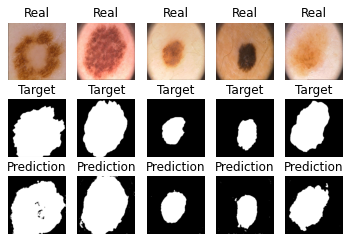

In [ ]:
visualize(model_segnet_dice)

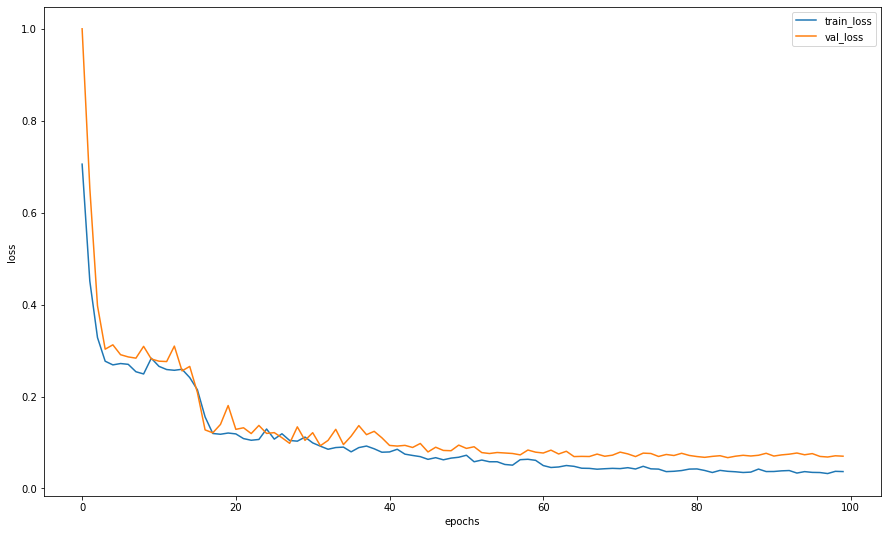

In [ ]:
plot_loss(loss, val_loss)

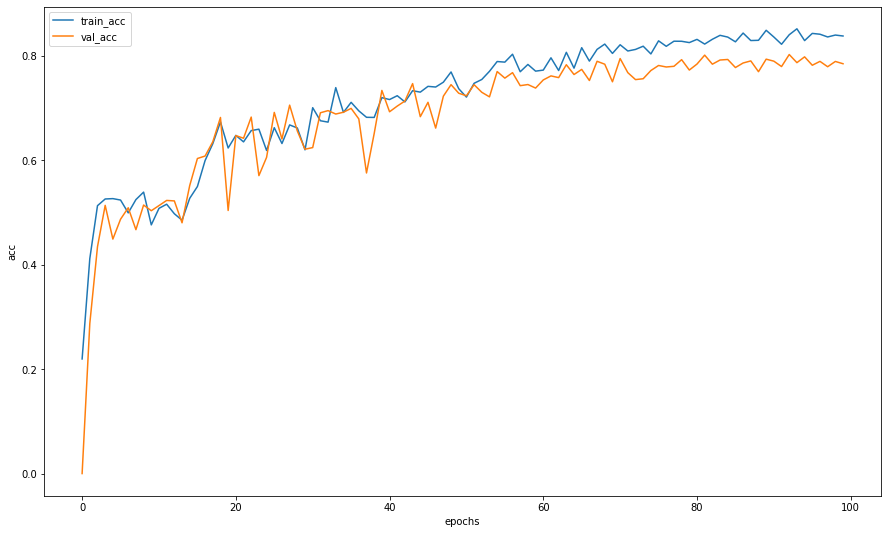

In [ ]:
plot_metric(acc, val_acc)

Сохраним модель и ее результаты:

In [ ]:
model_save_name = 'model_segnet_dice.pth'
path = F"/content/gdrive/My Drive/DLS/nevus/{model_save_name}" 
torch.save(model_segnet_dice.state_dict(), path)

In [ ]:
np.save(F"/content/gdrive/My Drive/DLS/nevus/history_segnet_dice.npy" , history_segnet_dice)

In [ ]:
del model_segnet_dice

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [151]:
def focal_loss(y_pred, y_real, eps = 1e-8, gamma = 2):
    y_pred = y_pred.squeeze()
    y_pred = torch.clamp(y_pred, 0, 1)
    bce = y_pred - y_pred * y_real + torch.log(1 + torch.exp(-y_pred))
    focal_loss = (1 - torch.exp(-bce))**gamma * bce
    focal_loss = torch.mean(focal_loss)
    return focal_loss

Протестируем:

In [ ]:
model_segnet_focal = SegNet().to(DEVICE)

In [ ]:
max_epochs = 100
optimizer = optim.Adam(model_segnet_focal.parameters())
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
torch.cuda.empty_cache()
history_segnet_focal = train(model_segnet_focal, optimizer, focal_loss, max_epochs, train_dl, val_dl)

epoch:   1%|          | 1/100 [00:04<07:02,  4.27s/it]


Epoch 001 train_loss: 0.1736 val_loss 0.1731 train_acc 0.1727 val_acc 0.0024


epoch:   2%|▏         | 2/100 [00:08<06:58,  4.27s/it]


Epoch 002 train_loss: 0.1640 val_loss 0.1714 train_acc 0.2489 val_acc 0.2639


epoch:   3%|▎         | 3/100 [00:12<06:54,  4.27s/it]


Epoch 003 train_loss: 0.1598 val_loss 0.1578 train_acc 0.4756 val_acc 0.3483


epoch:   4%|▍         | 4/100 [00:17<06:51,  4.28s/it]


Epoch 004 train_loss: 0.1532 val_loss 0.1654 train_acc 0.5633 val_acc 0.2068


epoch:   5%|▌         | 5/100 [00:21<06:48,  4.30s/it]


Epoch 005 train_loss: 0.1484 val_loss 0.2545 train_acc 0.6702 val_acc 0.4800


epoch:   6%|▌         | 6/100 [00:25<06:45,  4.32s/it]


Epoch 006 train_loss: 0.1501 val_loss 0.1538 train_acc 0.6615 val_acc 0.5032


epoch:   7%|▋         | 7/100 [00:30<06:43,  4.34s/it]


Epoch 007 train_loss: 0.1490 val_loss 0.1590 train_acc 0.6400 val_acc 0.3831


epoch:   8%|▊         | 8/100 [00:34<06:41,  4.36s/it]


Epoch 008 train_loss: 0.1469 val_loss 0.1537 train_acc 0.6805 val_acc 0.5340


epoch:   9%|▉         | 9/100 [00:39<06:39,  4.39s/it]


Epoch 009 train_loss: 0.1487 val_loss 0.1469 train_acc 0.6578 val_acc 0.6554


epoch:  10%|█         | 10/100 [00:43<06:36,  4.41s/it]


Epoch 010 train_loss: 0.1484 val_loss 0.1498 train_acc 0.6704 val_acc 0.6683


epoch:  11%|█         | 11/100 [00:48<06:34,  4.43s/it]


Epoch 011 train_loss: 0.1459 val_loss 0.1522 train_acc 0.7270 val_acc 0.6614


epoch:  12%|█▏        | 12/100 [00:52<06:31,  4.45s/it]


Epoch 012 train_loss: 0.1450 val_loss 0.1465 train_acc 0.7301 val_acc 0.6316


epoch:  13%|█▎        | 13/100 [00:56<06:26,  4.45s/it]


Epoch 013 train_loss: 0.1466 val_loss 0.1447 train_acc 0.7264 val_acc 0.6847


epoch:  14%|█▍        | 14/100 [01:01<06:21,  4.44s/it]


Epoch 014 train_loss: 0.1446 val_loss 0.1452 train_acc 0.7109 val_acc 0.6791


epoch:  15%|█▌        | 15/100 [01:05<06:16,  4.43s/it]


Epoch 015 train_loss: 0.1439 val_loss 0.1446 train_acc 0.7304 val_acc 0.6430


epoch:  16%|█▌        | 16/100 [01:10<06:11,  4.42s/it]


Epoch 016 train_loss: 0.1463 val_loss 0.1486 train_acc 0.7051 val_acc 0.6754


epoch:  17%|█▋        | 17/100 [01:14<06:05,  4.41s/it]


Epoch 017 train_loss: 0.1432 val_loss 0.1450 train_acc 0.7684 val_acc 0.7154


epoch:  18%|█▊        | 18/100 [01:18<06:00,  4.39s/it]


Epoch 018 train_loss: 0.1455 val_loss 0.1481 train_acc 0.7226 val_acc 0.6744


epoch:  19%|█▉        | 19/100 [01:23<05:55,  4.39s/it]


Epoch 019 train_loss: 0.1425 val_loss 0.1468 train_acc 0.7577 val_acc 0.6456


epoch:  20%|██        | 20/100 [01:27<05:50,  4.38s/it]


Epoch 020 train_loss: 0.1471 val_loss 0.1492 train_acc 0.6668 val_acc 0.5425


epoch:  21%|██        | 21/100 [01:31<05:45,  4.37s/it]


Epoch 021 train_loss: 0.1466 val_loss 0.1488 train_acc 0.7099 val_acc 0.6011


epoch:  22%|██▏       | 22/100 [01:36<05:41,  4.37s/it]


Epoch 022 train_loss: 0.1469 val_loss 0.1457 train_acc 0.7094 val_acc 0.6706


epoch:  23%|██▎       | 23/100 [01:40<05:36,  4.37s/it]


Epoch 023 train_loss: 0.1441 val_loss 0.1437 train_acc 0.7488 val_acc 0.7075


epoch:  24%|██▍       | 24/100 [01:45<05:32,  4.38s/it]


Epoch 024 train_loss: 0.1459 val_loss 0.1559 train_acc 0.7125 val_acc 0.4541


epoch:  25%|██▌       | 25/100 [01:49<05:28,  4.38s/it]


Epoch 025 train_loss: 0.1460 val_loss 0.1474 train_acc 0.6922 val_acc 0.6103


epoch:  26%|██▌       | 26/100 [01:53<05:24,  4.39s/it]


Epoch 026 train_loss: 0.1420 val_loss 0.1463 train_acc 0.7531 val_acc 0.6629


epoch:  27%|██▋       | 27/100 [01:58<05:20,  4.39s/it]


Epoch 027 train_loss: 0.1474 val_loss 0.1468 train_acc 0.7226 val_acc 0.6655


epoch:  28%|██▊       | 28/100 [02:02<05:16,  4.40s/it]


Epoch 028 train_loss: 0.1436 val_loss 0.1467 train_acc 0.7476 val_acc 0.6655


epoch:  29%|██▉       | 29/100 [02:07<05:12,  4.40s/it]


Epoch 029 train_loss: 0.1427 val_loss 0.1455 train_acc 0.7648 val_acc 0.6609


epoch:  30%|███       | 30/100 [02:11<05:08,  4.41s/it]


Epoch 030 train_loss: 0.1473 val_loss 0.1520 train_acc 0.7316 val_acc 0.6882


epoch:  31%|███       | 31/100 [02:15<05:04,  4.41s/it]


Epoch 031 train_loss: 0.1460 val_loss 0.1464 train_acc 0.6995 val_acc 0.6512


epoch:  32%|███▏      | 32/100 [02:20<04:59,  4.41s/it]


Epoch 032 train_loss: 0.1424 val_loss 0.1461 train_acc 0.7695 val_acc 0.6737


epoch:  33%|███▎      | 33/100 [02:24<04:55,  4.40s/it]


Epoch 033 train_loss: 0.1441 val_loss 0.1452 train_acc 0.7287 val_acc 0.6655


epoch:  34%|███▍      | 34/100 [02:29<04:50,  4.40s/it]


Epoch 034 train_loss: 0.1427 val_loss 0.1450 train_acc 0.7414 val_acc 0.6630


epoch:  35%|███▌      | 35/100 [02:33<04:45,  4.40s/it]


Epoch 035 train_loss: 0.1417 val_loss 0.1455 train_acc 0.7601 val_acc 0.6394


epoch:  36%|███▌      | 36/100 [02:37<04:41,  4.40s/it]


Epoch 036 train_loss: 0.1452 val_loss 0.1473 train_acc 0.7089 val_acc 0.6200


epoch:  37%|███▋      | 37/100 [02:42<04:36,  4.40s/it]


Epoch 037 train_loss: 0.1451 val_loss 0.1452 train_acc 0.7167 val_acc 0.6438


epoch:  38%|███▊      | 38/100 [02:46<04:32,  4.40s/it]


Epoch 038 train_loss: 0.1433 val_loss 0.1452 train_acc 0.7476 val_acc 0.6753


epoch:  39%|███▉      | 39/100 [02:51<04:27,  4.39s/it]


Epoch 039 train_loss: 0.1457 val_loss 0.1457 train_acc 0.7196 val_acc 0.6523


epoch:  40%|████      | 40/100 [02:55<04:23,  4.39s/it]


Epoch 040 train_loss: 0.1421 val_loss 0.1450 train_acc 0.7659 val_acc 0.6759


epoch:  41%|████      | 41/100 [02:59<04:19,  4.39s/it]


Epoch 041 train_loss: 0.1466 val_loss 0.1452 train_acc 0.7225 val_acc 0.6434


epoch:  42%|████▏     | 42/100 [03:04<04:14,  4.39s/it]


Epoch 042 train_loss: 0.1430 val_loss 0.1452 train_acc 0.7310 val_acc 0.6521


epoch:  43%|████▎     | 43/100 [03:08<04:10,  4.39s/it]


Epoch 043 train_loss: 0.1426 val_loss 0.1442 train_acc 0.7488 val_acc 0.6847


epoch:  44%|████▍     | 44/100 [03:13<04:05,  4.39s/it]


Epoch 044 train_loss: 0.1420 val_loss 0.1437 train_acc 0.7702 val_acc 0.6815


epoch:  45%|████▌     | 45/100 [03:17<04:01,  4.39s/it]


Epoch 045 train_loss: 0.1419 val_loss 0.1439 train_acc 0.7627 val_acc 0.6902


epoch:  46%|████▌     | 46/100 [03:21<03:57,  4.39s/it]


Epoch 046 train_loss: 0.1408 val_loss 0.1444 train_acc 0.7880 val_acc 0.6778


epoch:  47%|████▋     | 47/100 [03:26<03:52,  4.39s/it]


Epoch 047 train_loss: 0.1418 val_loss 0.1439 train_acc 0.7663 val_acc 0.7075


epoch:  48%|████▊     | 48/100 [03:30<03:48,  4.40s/it]


Epoch 048 train_loss: 0.1413 val_loss 0.1430 train_acc 0.7839 val_acc 0.7274


epoch:  49%|████▉     | 49/100 [03:35<03:44,  4.40s/it]


Epoch 049 train_loss: 0.1411 val_loss 0.1429 train_acc 0.7879 val_acc 0.7292


epoch:  50%|█████     | 50/100 [03:39<03:39,  4.40s/it]


Epoch 050 train_loss: 0.1423 val_loss 0.1433 train_acc 0.7622 val_acc 0.7169


epoch:  51%|█████     | 51/100 [03:43<03:35,  4.40s/it]


Epoch 051 train_loss: 0.1413 val_loss 0.1427 train_acc 0.7766 val_acc 0.7198


epoch:  52%|█████▏    | 52/100 [03:48<03:31,  4.40s/it]


Epoch 052 train_loss: 0.1413 val_loss 0.1427 train_acc 0.7864 val_acc 0.7189


epoch:  53%|█████▎    | 53/100 [03:52<03:27,  4.40s/it]


Epoch 053 train_loss: 0.1424 val_loss 0.1423 train_acc 0.7663 val_acc 0.7332


epoch:  54%|█████▍    | 54/100 [03:57<03:22,  4.41s/it]


Epoch 054 train_loss: 0.1425 val_loss 0.1442 train_acc 0.7499 val_acc 0.6870


epoch:  55%|█████▌    | 55/100 [04:01<03:18,  4.41s/it]


Epoch 055 train_loss: 0.1443 val_loss 0.1433 train_acc 0.7501 val_acc 0.7057


epoch:  56%|█████▌    | 56/100 [04:05<03:14,  4.41s/it]


Epoch 056 train_loss: 0.1417 val_loss 0.1441 train_acc 0.7822 val_acc 0.7119


epoch:  57%|█████▋    | 57/100 [04:10<03:09,  4.41s/it]


Epoch 057 train_loss: 0.1410 val_loss 0.1423 train_acc 0.7855 val_acc 0.7320


epoch:  58%|█████▊    | 58/100 [04:14<03:05,  4.41s/it]


Epoch 058 train_loss: 0.1410 val_loss 0.1418 train_acc 0.7786 val_acc 0.7363


epoch:  59%|█████▉    | 59/100 [04:19<03:00,  4.41s/it]


Epoch 059 train_loss: 0.1397 val_loss 0.1417 train_acc 0.7922 val_acc 0.7468


epoch:  60%|██████    | 60/100 [04:23<02:56,  4.41s/it]


Epoch 060 train_loss: 0.1395 val_loss 0.1415 train_acc 0.8095 val_acc 0.7320


epoch:  61%|██████    | 61/100 [04:27<02:51,  4.41s/it]


Epoch 061 train_loss: 0.1391 val_loss 0.1414 train_acc 0.8094 val_acc 0.7407


epoch:  62%|██████▏   | 62/100 [04:32<02:47,  4.41s/it]


Epoch 062 train_loss: 0.1397 val_loss 0.1419 train_acc 0.7979 val_acc 0.7522


epoch:  63%|██████▎   | 63/100 [04:36<02:43,  4.41s/it]


Epoch 063 train_loss: 0.1385 val_loss 0.1418 train_acc 0.8256 val_acc 0.7372


epoch:  64%|██████▍   | 64/100 [04:41<02:38,  4.41s/it]


Epoch 064 train_loss: 0.1389 val_loss 0.1417 train_acc 0.8152 val_acc 0.7462


epoch:  65%|██████▌   | 65/100 [04:45<02:34,  4.41s/it]


Epoch 065 train_loss: 0.1392 val_loss 0.1418 train_acc 0.8036 val_acc 0.7411


epoch:  66%|██████▌   | 66/100 [04:49<02:29,  4.40s/it]


Epoch 066 train_loss: 0.1402 val_loss 0.1424 train_acc 0.7894 val_acc 0.7409


epoch:  67%|██████▋   | 67/100 [04:54<02:25,  4.40s/it]


Epoch 067 train_loss: 0.1396 val_loss 0.1432 train_acc 0.7896 val_acc 0.7339


epoch:  68%|██████▊   | 68/100 [04:58<02:20,  4.40s/it]


Epoch 068 train_loss: 0.1387 val_loss 0.1430 train_acc 0.8224 val_acc 0.7239


epoch:  69%|██████▉   | 69/100 [05:03<02:16,  4.40s/it]


Epoch 069 train_loss: 0.1402 val_loss 0.1430 train_acc 0.7975 val_acc 0.7289


epoch:  70%|███████   | 70/100 [05:07<02:12,  4.40s/it]


Epoch 070 train_loss: 0.1384 val_loss 0.1427 train_acc 0.8143 val_acc 0.7215


epoch:  71%|███████   | 71/100 [05:11<02:07,  4.40s/it]


Epoch 071 train_loss: 0.1396 val_loss 0.1426 train_acc 0.7951 val_acc 0.7226


epoch:  72%|███████▏  | 72/100 [05:16<02:03,  4.40s/it]


Epoch 072 train_loss: 0.1393 val_loss 0.1421 train_acc 0.8014 val_acc 0.7293


epoch:  73%|███████▎  | 73/100 [05:20<01:58,  4.40s/it]


Epoch 073 train_loss: 0.1386 val_loss 0.1422 train_acc 0.8185 val_acc 0.7244


epoch:  74%|███████▍  | 74/100 [05:25<01:54,  4.40s/it]


Epoch 074 train_loss: 0.1379 val_loss 0.1422 train_acc 0.8268 val_acc 0.7481


epoch:  75%|███████▌  | 75/100 [05:29<01:49,  4.40s/it]


Epoch 075 train_loss: 0.1385 val_loss 0.1419 train_acc 0.8148 val_acc 0.7370


epoch:  76%|███████▌  | 76/100 [05:33<01:45,  4.40s/it]


Epoch 076 train_loss: 0.1384 val_loss 0.1423 train_acc 0.8207 val_acc 0.7425


epoch:  77%|███████▋  | 77/100 [05:38<01:41,  4.40s/it]


Epoch 077 train_loss: 0.1385 val_loss 0.1422 train_acc 0.8160 val_acc 0.7470


epoch:  78%|███████▊  | 78/100 [05:42<01:36,  4.40s/it]


Epoch 078 train_loss: 0.1389 val_loss 0.1419 train_acc 0.8123 val_acc 0.7466


epoch:  79%|███████▉  | 79/100 [05:47<01:32,  4.40s/it]


Epoch 079 train_loss: 0.1369 val_loss 0.1420 train_acc 0.8349 val_acc 0.7399


epoch:  80%|████████  | 80/100 [05:51<01:27,  4.40s/it]


Epoch 080 train_loss: 0.1393 val_loss 0.1413 train_acc 0.8189 val_acc 0.7642


epoch:  81%|████████  | 81/100 [05:55<01:23,  4.40s/it]


Epoch 081 train_loss: 0.1396 val_loss 0.1416 train_acc 0.8029 val_acc 0.7356


epoch:  82%|████████▏ | 82/100 [06:00<01:19,  4.39s/it]


Epoch 082 train_loss: 0.1388 val_loss 0.1417 train_acc 0.8068 val_acc 0.7356


epoch:  83%|████████▎ | 83/100 [06:04<01:14,  4.39s/it]


Epoch 083 train_loss: 0.1394 val_loss 0.1420 train_acc 0.8021 val_acc 0.7268


epoch:  84%|████████▍ | 84/100 [06:09<01:10,  4.39s/it]


Epoch 084 train_loss: 0.1383 val_loss 0.1416 train_acc 0.8199 val_acc 0.7465


epoch:  85%|████████▌ | 85/100 [06:13<01:05,  4.39s/it]


Epoch 085 train_loss: 0.1383 val_loss 0.1416 train_acc 0.8178 val_acc 0.7554


epoch:  86%|████████▌ | 86/100 [06:17<01:01,  4.39s/it]


Epoch 086 train_loss: 0.1375 val_loss 0.1413 train_acc 0.8329 val_acc 0.7547


epoch:  87%|████████▋ | 87/100 [06:22<00:57,  4.39s/it]


Epoch 087 train_loss: 0.1377 val_loss 0.1416 train_acc 0.8277 val_acc 0.7469


epoch:  88%|████████▊ | 88/100 [06:26<00:52,  4.39s/it]


Epoch 088 train_loss: 0.1384 val_loss 0.1419 train_acc 0.8179 val_acc 0.7609


epoch:  89%|████████▉ | 89/100 [06:31<00:48,  4.39s/it]


Epoch 089 train_loss: 0.1377 val_loss 0.1415 train_acc 0.8215 val_acc 0.7485


epoch:  90%|█████████ | 90/100 [06:35<00:43,  4.40s/it]


Epoch 090 train_loss: 0.1375 val_loss 0.1412 train_acc 0.8265 val_acc 0.7444


epoch:  91%|█████████ | 91/100 [06:39<00:39,  4.40s/it]


Epoch 091 train_loss: 0.1377 val_loss 0.1412 train_acc 0.8262 val_acc 0.7598


epoch:  92%|█████████▏| 92/100 [06:44<00:35,  4.40s/it]


Epoch 092 train_loss: 0.1382 val_loss 0.1412 train_acc 0.8308 val_acc 0.7552


epoch:  93%|█████████▎| 93/100 [06:48<00:30,  4.40s/it]


Epoch 093 train_loss: 0.1374 val_loss 0.1415 train_acc 0.8331 val_acc 0.7480


epoch:  94%|█████████▍| 94/100 [06:53<00:26,  4.40s/it]


Epoch 094 train_loss: 0.1379 val_loss 0.1414 train_acc 0.8335 val_acc 0.7557


epoch:  95%|█████████▌| 95/100 [06:57<00:21,  4.40s/it]


Epoch 095 train_loss: 0.1375 val_loss 0.1413 train_acc 0.8255 val_acc 0.7567


epoch:  96%|█████████▌| 96/100 [07:01<00:17,  4.40s/it]


Epoch 096 train_loss: 0.1367 val_loss 0.1415 train_acc 0.8423 val_acc 0.7635


epoch:  97%|█████████▋| 97/100 [07:06<00:13,  4.39s/it]


Epoch 097 train_loss: 0.1373 val_loss 0.1416 train_acc 0.8366 val_acc 0.7503


epoch:  98%|█████████▊| 98/100 [07:10<00:08,  4.40s/it]


Epoch 098 train_loss: 0.1376 val_loss 0.1415 train_acc 0.8211 val_acc 0.7593


epoch:  99%|█████████▉| 99/100 [07:15<00:04,  4.40s/it]


Epoch 099 train_loss: 0.1380 val_loss 0.1411 train_acc 0.8196 val_acc 0.7655


epoch: 100%|██████████| 100/100 [07:19<00:00,  4.39s/it]


Epoch 100 train_loss: 0.1372 val_loss 0.1413 train_acc 0.8341 val_acc 0.7570


Визуализируем результат:

In [ ]:
loss, acc, val_loss, val_acc = zip(*history_segnet_focal)

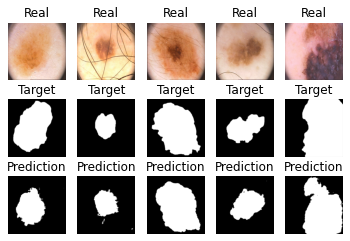

In [ ]:
visualize(model_segnet_focal)

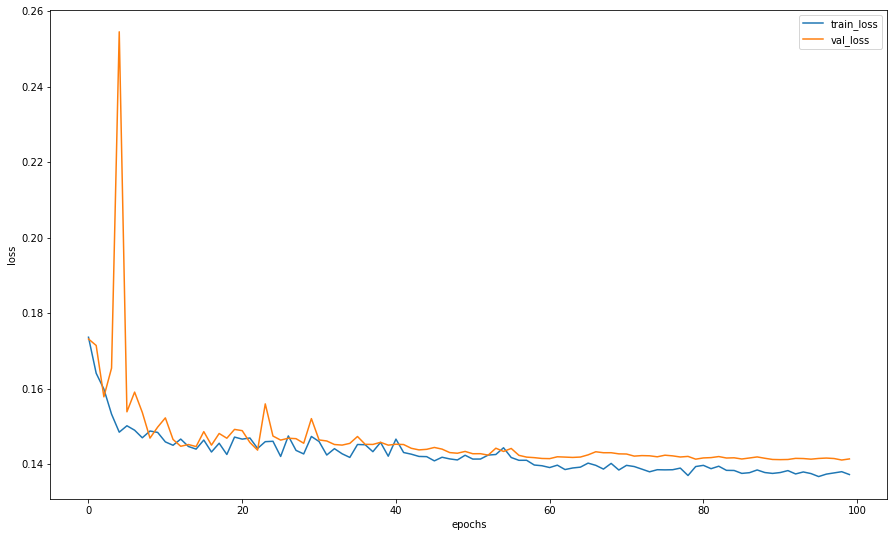

In [ ]:
plot_loss(loss, val_loss)

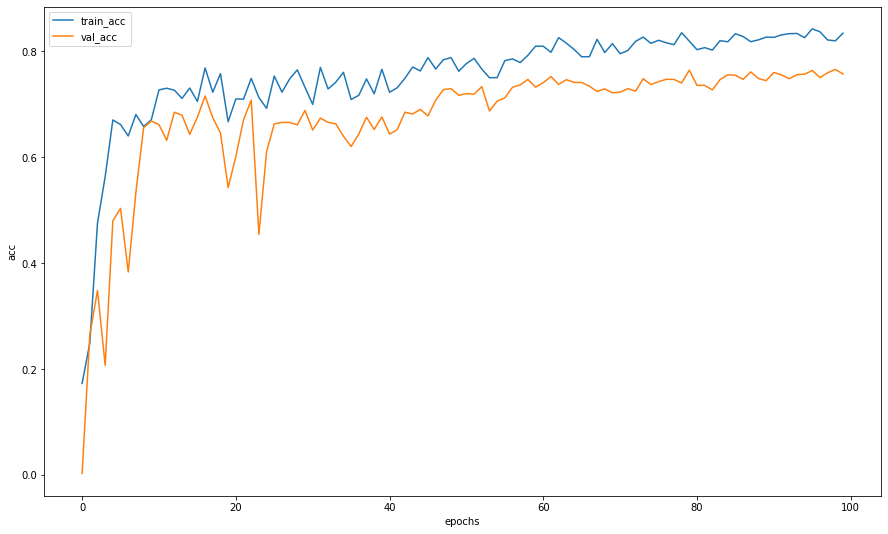

In [ ]:
plot_metric(acc, val_acc)

Сохраним модель и ее результаты:

In [ ]:
model_save_name = 'model_segnet_focal.pth'
path = F"/content/gdrive/My Drive/DLS/nevus/{model_save_name}" 
torch.save(model_segnet_focal.state_dict(), path)

In [ ]:
np.save(F"/content/gdrive/My Drive/DLS/nevus/history_segnet_focal.npy" , history_segnet_focal)

In [ ]:
del model_segnet_focal

**3. Lovasz loss.**

В качестве бонуса напишем функцию потерь Hinge Lovasz loss для бинарной сегментации. [Статья для прочтения](https://arxiv.org/abs/1705.08790), [ссылка на проект](http://bmax.im/LovaszSoftmax).

In [152]:
def lovasz_hinge(y_pred, y_real):
    y_pred = y_pred.squeeze()
    loss = lovasz_hinge_flat(*flatten_binary_scores(y_pred, y_real))
    return loss

In [153]:
def lovasz_hinge_flat(y_pred, y_real):
    if len(y_real) == 0:
        return y_pred.sum() * 0.
    signs = 2. * y_real.float() - 1.
    errors = (1. - y_pred * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = y_real[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(nn.functional.relu(errors_sorted), Variable(grad))
    return loss

In [154]:
def flatten_binary_scores(y_pred, y_real):
    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)
    return y_pred, y_real

In [155]:
def lovasz_grad(gt_sorted):
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1:
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard

Немного модифицируем train функцию для обучения модели с помощью этой функции потерь:

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, data_tr, opt, loss_fn)
            val_loss, val_acc = eval_epoch(model, data_val, loss_fn)
            history.append((train_loss, train_acc, val_loss, val_acc))
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch + 1, t_loss=train_loss, v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
        if epoch == 10:
          optimizer.param_groups[0]['lr'] = 1e-3
        if epoch == 25:
          optimizer.param_groups[0]['lr'] = 3e-4
        if epoch == 50:
          optimizer.param_groups[0]['lr'] = 3e-5
    return history

In [ ]:
model_segnet_lovasz = SegNet().to(DEVICE)

In [ ]:
max_epochs = 100
optimizer = optim.Adam(model_segnet_lovasz.parameters(), lr=0.01)
torch.cuda.empty_cache()
history_segnet_lovasz = train(model_segnet_lovasz, optimizer, lovasz_hinge, max_epochs, train_dl, val_dl)

epoch:   1%|          | 1/100 [00:04<07:40,  4.65s/it]


Epoch 001 train_loss: 1.0510 val_loss 2.0351 train_acc 0.1822 val_acc 0.3238


epoch:   2%|▏         | 2/100 [00:09<07:34,  4.63s/it]


Epoch 002 train_loss: 0.9205 val_loss 0.9369 train_acc 0.3509 val_acc 0.4117


epoch:   3%|▎         | 3/100 [00:13<07:28,  4.62s/it]


Epoch 003 train_loss: 0.8590 val_loss 0.8488 train_acc 0.5986 val_acc 0.5990


epoch:   4%|▍         | 4/100 [00:18<07:22,  4.60s/it]


Epoch 004 train_loss: 0.8552 val_loss 0.9009 train_acc 0.6271 val_acc 0.6651


epoch:   5%|▌         | 5/100 [00:22<07:15,  4.59s/it]


Epoch 005 train_loss: 0.8381 val_loss 0.8355 train_acc 0.6305 val_acc 0.5719


epoch:   6%|▌         | 6/100 [00:27<07:09,  4.57s/it]


Epoch 006 train_loss: 0.8250 val_loss 1.0987 train_acc 0.6632 val_acc 0.6352


epoch:   7%|▋         | 7/100 [00:32<07:03,  4.56s/it]


Epoch 007 train_loss: 0.8053 val_loss 1.0085 train_acc 0.7002 val_acc 0.3619


epoch:   8%|▊         | 8/100 [00:36<06:58,  4.55s/it]


Epoch 008 train_loss: 0.7871 val_loss 0.8188 train_acc 0.6611 val_acc 0.6332


epoch:   9%|▉         | 9/100 [00:41<06:52,  4.53s/it]


Epoch 009 train_loss: 0.7140 val_loss 0.7370 train_acc 0.7280 val_acc 0.7159


epoch:  10%|█         | 10/100 [00:45<06:47,  4.53s/it]


Epoch 010 train_loss: 0.6729 val_loss 0.6809 train_acc 0.7400 val_acc 0.7205


epoch:  11%|█         | 11/100 [00:50<06:42,  4.52s/it]


Epoch 011 train_loss: 0.6314 val_loss 0.9531 train_acc 0.7545 val_acc 0.5133


epoch:  12%|█▏        | 12/100 [00:54<06:37,  4.52s/it]


Epoch 012 train_loss: 0.5939 val_loss 0.6083 train_acc 0.7447 val_acc 0.7236


epoch:  13%|█▎        | 13/100 [00:59<06:32,  4.52s/it]


Epoch 013 train_loss: 0.5817 val_loss 0.5529 train_acc 0.7398 val_acc 0.7415


epoch:  14%|█▍        | 14/100 [01:03<06:28,  4.52s/it]


Epoch 014 train_loss: 0.6672 val_loss 1.0085 train_acc 0.6870 val_acc 0.4851


epoch:  15%|█▌        | 15/100 [01:08<06:24,  4.52s/it]


Epoch 015 train_loss: 0.5989 val_loss 0.6458 train_acc 0.7161 val_acc 0.6810


epoch:  16%|█▌        | 16/100 [01:12<06:20,  4.53s/it]


Epoch 016 train_loss: 0.6078 val_loss 0.8376 train_acc 0.7194 val_acc 0.6411


epoch:  17%|█▋        | 17/100 [01:17<06:16,  4.53s/it]


Epoch 017 train_loss: 0.5889 val_loss 0.5001 train_acc 0.7265 val_acc 0.7561


epoch:  18%|█▊        | 18/100 [01:21<06:12,  4.54s/it]


Epoch 018 train_loss: 0.5485 val_loss 0.6251 train_acc 0.7450 val_acc 0.7158


epoch:  19%|█▉        | 19/100 [01:26<06:08,  4.54s/it]


Epoch 019 train_loss: 0.5629 val_loss 0.5796 train_acc 0.7365 val_acc 0.7304


epoch:  20%|██        | 20/100 [01:30<06:03,  4.55s/it]


Epoch 020 train_loss: 0.6486 val_loss 0.5226 train_acc 0.7024 val_acc 0.7457


epoch:  21%|██        | 21/100 [01:35<05:59,  4.55s/it]


Epoch 021 train_loss: 0.5612 val_loss 0.5516 train_acc 0.7420 val_acc 0.7529


epoch:  22%|██▏       | 22/100 [01:40<05:55,  4.55s/it]


Epoch 022 train_loss: 0.5440 val_loss 0.5435 train_acc 0.7528 val_acc 0.7394


epoch:  23%|██▎       | 23/100 [01:44<05:50,  4.55s/it]


Epoch 023 train_loss: 0.5749 val_loss 0.5101 train_acc 0.7405 val_acc 0.7490


epoch:  24%|██▍       | 24/100 [01:49<05:45,  4.55s/it]


Epoch 024 train_loss: 0.5706 val_loss 0.5163 train_acc 0.7474 val_acc 0.7624


epoch:  25%|██▌       | 25/100 [01:53<05:41,  4.55s/it]


Epoch 025 train_loss: 0.5283 val_loss 0.5406 train_acc 0.7530 val_acc 0.7392


epoch:  26%|██▌       | 26/100 [01:58<05:36,  4.55s/it]


Epoch 026 train_loss: 0.5691 val_loss 0.5900 train_acc 0.7325 val_acc 0.7100


epoch:  27%|██▋       | 27/100 [02:02<05:31,  4.55s/it]


Epoch 027 train_loss: 0.4808 val_loss 0.4564 train_acc 0.7764 val_acc 0.7778


epoch:  28%|██▊       | 28/100 [02:07<05:27,  4.54s/it]


Epoch 028 train_loss: 0.5173 val_loss 1.0346 train_acc 0.7685 val_acc 0.5728


epoch:  29%|██▉       | 29/100 [02:11<05:22,  4.54s/it]


Epoch 029 train_loss: 0.5941 val_loss 0.5487 train_acc 0.7264 val_acc 0.7373


epoch:  30%|███       | 30/100 [02:16<05:17,  4.53s/it]


Epoch 030 train_loss: 0.5891 val_loss 0.5586 train_acc 0.7351 val_acc 0.7210


epoch:  31%|███       | 31/100 [02:20<05:12,  4.53s/it]


Epoch 031 train_loss: 0.5618 val_loss 0.4980 train_acc 0.7390 val_acc 0.7698


epoch:  32%|███▏      | 32/100 [02:25<05:07,  4.52s/it]


Epoch 032 train_loss: 0.5467 val_loss 0.4860 train_acc 0.7582 val_acc 0.7611


epoch:  33%|███▎      | 33/100 [02:29<05:03,  4.52s/it]


Epoch 033 train_loss: 0.4984 val_loss 0.5215 train_acc 0.7658 val_acc 0.7419


epoch:  34%|███▍      | 34/100 [02:34<04:58,  4.52s/it]


Epoch 034 train_loss: 0.5329 val_loss 0.5691 train_acc 0.7518 val_acc 0.7123


epoch:  35%|███▌      | 35/100 [02:38<04:53,  4.52s/it]


Epoch 035 train_loss: 0.4675 val_loss 0.4927 train_acc 0.7768 val_acc 0.7631


epoch:  36%|███▌      | 36/100 [02:43<04:49,  4.53s/it]


Epoch 036 train_loss: 0.4434 val_loss 0.5482 train_acc 0.7920 val_acc 0.7350


epoch:  37%|███▋      | 37/100 [02:48<04:45,  4.54s/it]


Epoch 037 train_loss: 0.4518 val_loss 0.4726 train_acc 0.7913 val_acc 0.7676


epoch:  38%|███▊      | 38/100 [02:52<04:41,  4.54s/it]


Epoch 038 train_loss: 0.5091 val_loss 0.5276 train_acc 0.7550 val_acc 0.7379


epoch:  39%|███▉      | 39/100 [02:57<04:37,  4.54s/it]


Epoch 039 train_loss: 0.4724 val_loss 0.4201 train_acc 0.7749 val_acc 0.7950


epoch:  40%|████      | 40/100 [03:01<04:32,  4.55s/it]


Epoch 040 train_loss: 0.4690 val_loss 0.5535 train_acc 0.7866 val_acc 0.7758


epoch:  41%|████      | 41/100 [03:06<04:28,  4.55s/it]


Epoch 041 train_loss: 0.4135 val_loss 0.4742 train_acc 0.8025 val_acc 0.7630


epoch:  42%|████▏     | 42/100 [03:10<04:23,  4.55s/it]


Epoch 042 train_loss: 0.5146 val_loss 0.4525 train_acc 0.7599 val_acc 0.7779


epoch:  43%|████▎     | 43/100 [03:15<04:19,  4.55s/it]


Epoch 043 train_loss: 0.4038 val_loss 0.5281 train_acc 0.8096 val_acc 0.7506


epoch:  44%|████▍     | 44/100 [03:19<04:14,  4.54s/it]


Epoch 044 train_loss: 0.4840 val_loss 0.4718 train_acc 0.7792 val_acc 0.7742


epoch:  45%|████▌     | 45/100 [03:24<04:09,  4.54s/it]


Epoch 045 train_loss: 0.4326 val_loss 0.4732 train_acc 0.8041 val_acc 0.7652


epoch:  46%|████▌     | 46/100 [03:28<04:05,  4.54s/it]


Epoch 046 train_loss: 0.3918 val_loss 0.4536 train_acc 0.8136 val_acc 0.7743


epoch:  47%|████▋     | 47/100 [03:33<04:00,  4.54s/it]


Epoch 047 train_loss: 0.4189 val_loss 0.4206 train_acc 0.7991 val_acc 0.8003


epoch:  48%|████▊     | 48/100 [03:37<03:56,  4.54s/it]


Epoch 048 train_loss: 0.3929 val_loss 0.4184 train_acc 0.8179 val_acc 0.8031


epoch:  49%|████▉     | 49/100 [03:42<03:51,  4.54s/it]


Epoch 049 train_loss: 0.3794 val_loss 0.4130 train_acc 0.8212 val_acc 0.7991


epoch:  50%|█████     | 50/100 [03:47<03:46,  4.54s/it]


Epoch 050 train_loss: 0.4125 val_loss 0.4757 train_acc 0.8027 val_acc 0.7659


epoch:  51%|█████     | 51/100 [03:51<03:42,  4.53s/it]


Epoch 051 train_loss: 0.4829 val_loss 0.4429 train_acc 0.7806 val_acc 0.7867


epoch:  52%|█████▏    | 52/100 [03:56<03:37,  4.53s/it]


Epoch 052 train_loss: 0.4015 val_loss 0.4179 train_acc 0.8121 val_acc 0.8035


epoch:  53%|█████▎    | 53/100 [04:00<03:33,  4.53s/it]


Epoch 053 train_loss: 0.3784 val_loss 0.5313 train_acc 0.8208 val_acc 0.7335


epoch:  54%|█████▍    | 54/100 [04:05<03:28,  4.53s/it]


Epoch 054 train_loss: 0.3922 val_loss 0.4369 train_acc 0.8187 val_acc 0.7864


epoch:  55%|█████▌    | 55/100 [04:09<03:23,  4.53s/it]


Epoch 055 train_loss: 0.4702 val_loss 0.4294 train_acc 0.7770 val_acc 0.7962


epoch:  56%|█████▌    | 56/100 [04:14<03:19,  4.53s/it]


Epoch 056 train_loss: 0.3813 val_loss 0.4663 train_acc 0.8221 val_acc 0.7789


epoch:  57%|█████▋    | 57/100 [04:18<03:14,  4.53s/it]


Epoch 057 train_loss: 0.3795 val_loss 0.4198 train_acc 0.8191 val_acc 0.7914


epoch:  58%|█████▊    | 58/100 [04:23<03:10,  4.53s/it]


Epoch 058 train_loss: 0.4045 val_loss 0.4248 train_acc 0.8094 val_acc 0.7885


epoch:  59%|█████▉    | 59/100 [04:27<03:05,  4.53s/it]


Epoch 059 train_loss: 0.3872 val_loss 0.4368 train_acc 0.8202 val_acc 0.7871


epoch:  60%|██████    | 60/100 [04:32<03:01,  4.53s/it]


Epoch 060 train_loss: 0.3531 val_loss 0.4391 train_acc 0.8291 val_acc 0.7880


epoch:  61%|██████    | 61/100 [04:36<02:56,  4.53s/it]


Epoch 061 train_loss: 0.3638 val_loss 0.3893 train_acc 0.8330 val_acc 0.8143


epoch:  62%|██████▏   | 62/100 [04:41<02:52,  4.53s/it]


Epoch 062 train_loss: 0.3676 val_loss 0.4175 train_acc 0.8270 val_acc 0.7958


epoch:  63%|██████▎   | 63/100 [04:45<02:47,  4.54s/it]


Epoch 063 train_loss: 0.4081 val_loss 0.3949 train_acc 0.8095 val_acc 0.8181


epoch:  64%|██████▍   | 64/100 [04:50<02:43,  4.54s/it]


Epoch 064 train_loss: 0.3649 val_loss 0.4404 train_acc 0.8290 val_acc 0.7823


epoch:  65%|██████▌   | 65/100 [04:55<02:38,  4.54s/it]


Epoch 065 train_loss: 0.3402 val_loss 0.3744 train_acc 0.8396 val_acc 0.8216


epoch:  66%|██████▌   | 66/100 [04:59<02:34,  4.54s/it]


Epoch 066 train_loss: 0.3317 val_loss 0.4082 train_acc 0.8423 val_acc 0.8004


epoch:  67%|██████▋   | 67/100 [05:04<02:29,  4.54s/it]


Epoch 067 train_loss: 0.3447 val_loss 0.4352 train_acc 0.8402 val_acc 0.7954


epoch:  68%|██████▊   | 68/100 [05:08<02:25,  4.54s/it]


Epoch 068 train_loss: 0.3933 val_loss 0.5528 train_acc 0.8203 val_acc 0.7120


epoch:  69%|██████▉   | 69/100 [05:13<02:20,  4.54s/it]


Epoch 069 train_loss: 0.3500 val_loss 0.4504 train_acc 0.8349 val_acc 0.7800


epoch:  70%|███████   | 70/100 [05:17<02:16,  4.55s/it]


Epoch 070 train_loss: 0.3652 val_loss 0.8761 train_acc 0.8265 val_acc 0.5728


epoch:  71%|███████   | 71/100 [05:22<02:11,  4.55s/it]


Epoch 071 train_loss: 0.4133 val_loss 0.4457 train_acc 0.8069 val_acc 0.7854


epoch:  72%|███████▏  | 72/100 [05:26<02:07,  4.55s/it]


Epoch 072 train_loss: 0.4075 val_loss 0.4487 train_acc 0.8068 val_acc 0.7765


epoch:  73%|███████▎  | 73/100 [05:31<02:02,  4.55s/it]


Epoch 073 train_loss: 0.3389 val_loss 0.4238 train_acc 0.8419 val_acc 0.7975


epoch:  74%|███████▍  | 74/100 [05:35<01:58,  4.55s/it]


Epoch 074 train_loss: 0.3210 val_loss 0.4033 train_acc 0.8462 val_acc 0.7985


epoch:  75%|███████▌  | 75/100 [05:40<01:53,  4.55s/it]


Epoch 075 train_loss: 0.3450 val_loss 0.4371 train_acc 0.8427 val_acc 0.7848


epoch:  76%|███████▌  | 76/100 [05:45<01:49,  4.55s/it]


Epoch 076 train_loss: 0.3327 val_loss 0.4016 train_acc 0.8442 val_acc 0.8037


epoch:  77%|███████▋  | 77/100 [05:49<01:44,  4.55s/it]


Epoch 077 train_loss: 0.3856 val_loss 0.4792 train_acc 0.8158 val_acc 0.7660


epoch:  78%|███████▊  | 78/100 [05:54<01:40,  4.55s/it]


Epoch 078 train_loss: 0.4111 val_loss 0.4253 train_acc 0.8071 val_acc 0.7936


epoch:  79%|███████▉  | 79/100 [05:58<01:35,  4.55s/it]


Epoch 079 train_loss: 0.3057 val_loss 0.3694 train_acc 0.8545 val_acc 0.8230


epoch:  80%|████████  | 80/100 [06:03<01:31,  4.55s/it]


Epoch 080 train_loss: 0.3144 val_loss 0.3639 train_acc 0.8531 val_acc 0.8296


epoch:  81%|████████  | 81/100 [06:07<01:26,  4.55s/it]


Epoch 081 train_loss: 0.2850 val_loss 0.4281 train_acc 0.8673 val_acc 0.7863


epoch:  82%|████████▏ | 82/100 [06:12<01:21,  4.55s/it]


Epoch 082 train_loss: 0.3112 val_loss 0.5611 train_acc 0.8550 val_acc 0.7188


epoch:  83%|████████▎ | 83/100 [06:16<01:17,  4.55s/it]


Epoch 083 train_loss: 0.3125 val_loss 0.3927 train_acc 0.8530 val_acc 0.8058


epoch:  84%|████████▍ | 84/100 [06:21<01:12,  4.55s/it]


Epoch 084 train_loss: 0.2786 val_loss 0.3539 train_acc 0.8680 val_acc 0.8274


epoch:  85%|████████▌ | 85/100 [06:26<01:08,  4.55s/it]


Epoch 085 train_loss: 0.2994 val_loss 0.3653 train_acc 0.8608 val_acc 0.8188


epoch:  86%|████████▌ | 86/100 [06:30<01:03,  4.55s/it]


Epoch 086 train_loss: 0.2548 val_loss 0.3388 train_acc 0.8795 val_acc 0.8324


epoch:  87%|████████▋ | 87/100 [06:35<00:59,  4.54s/it]


Epoch 087 train_loss: 0.2546 val_loss 0.4212 train_acc 0.8822 val_acc 0.7821


epoch:  88%|████████▊ | 88/100 [06:39<00:54,  4.55s/it]


Epoch 088 train_loss: 0.2574 val_loss 0.4279 train_acc 0.8776 val_acc 0.7874


epoch:  89%|████████▉ | 89/100 [06:44<00:50,  4.55s/it]


Epoch 089 train_loss: 0.2404 val_loss 0.4055 train_acc 0.8860 val_acc 0.7949


epoch:  90%|█████████ | 90/100 [06:48<00:45,  4.55s/it]


Epoch 090 train_loss: 0.2444 val_loss 0.3530 train_acc 0.8828 val_acc 0.8275


epoch:  91%|█████████ | 91/100 [06:53<00:40,  4.55s/it]


Epoch 091 train_loss: 0.2106 val_loss 0.3901 train_acc 0.9032 val_acc 0.8225


epoch:  92%|█████████▏| 92/100 [06:57<00:36,  4.55s/it]


Epoch 092 train_loss: 0.2379 val_loss 0.3763 train_acc 0.8868 val_acc 0.8097


epoch:  93%|█████████▎| 93/100 [07:02<00:31,  4.55s/it]


Epoch 093 train_loss: 0.2498 val_loss 0.3774 train_acc 0.8829 val_acc 0.8138


epoch:  94%|█████████▍| 94/100 [07:06<00:27,  4.55s/it]


Epoch 094 train_loss: 0.2847 val_loss 0.4234 train_acc 0.8635 val_acc 0.7980


epoch:  95%|█████████▌| 95/100 [07:11<00:22,  4.54s/it]


Epoch 095 train_loss: 0.2969 val_loss 0.4135 train_acc 0.8618 val_acc 0.7964


epoch:  96%|█████████▌| 96/100 [07:16<00:18,  4.54s/it]


Epoch 096 train_loss: 0.3177 val_loss 0.3664 train_acc 0.8528 val_acc 0.8186


epoch:  97%|█████████▋| 97/100 [07:20<00:13,  4.54s/it]


Epoch 097 train_loss: 0.2454 val_loss 0.3496 train_acc 0.8830 val_acc 0.8329


epoch:  98%|█████████▊| 98/100 [07:25<00:09,  4.54s/it]


Epoch 098 train_loss: 0.2355 val_loss 0.3623 train_acc 0.8887 val_acc 0.8180


epoch:  99%|█████████▉| 99/100 [07:29<00:04,  4.54s/it]


Epoch 099 train_loss: 0.2358 val_loss 0.3476 train_acc 0.8882 val_acc 0.8305


epoch: 100%|██████████| 100/100 [07:34<00:00,  4.54s/it]


Epoch 100 train_loss: 0.2086 val_loss 0.4059 train_acc 0.8999 val_acc 0.7925


Если тренировать модель дольше (200 эпох), то видно, что train loss уменьшается еще сильнее, до значений примерно равных 0.1, однако при этом val loss остается постоянным (примерно 0.3-0.4). Такое поведение является признаком переобучения, поэтому, несмотря на явную тенденцию train loss к снижению, количество эпох было взято такое же, как и в моделях с предыдущими функциями потерь.

Визуализируем результат:

In [ ]:
loss, acc, val_loss, val_acc = zip(*history_segnet_lovasz)

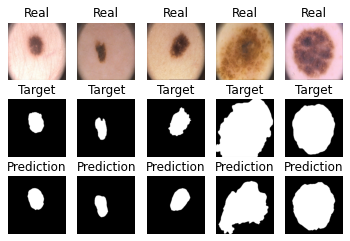

In [ ]:
visualize(model_segnet_lovasz)

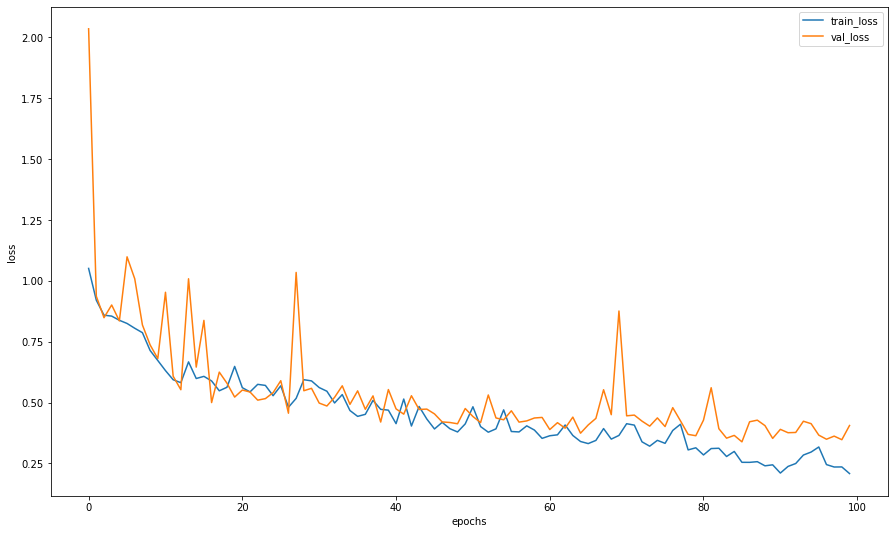

In [ ]:
plot_loss(loss, val_loss)

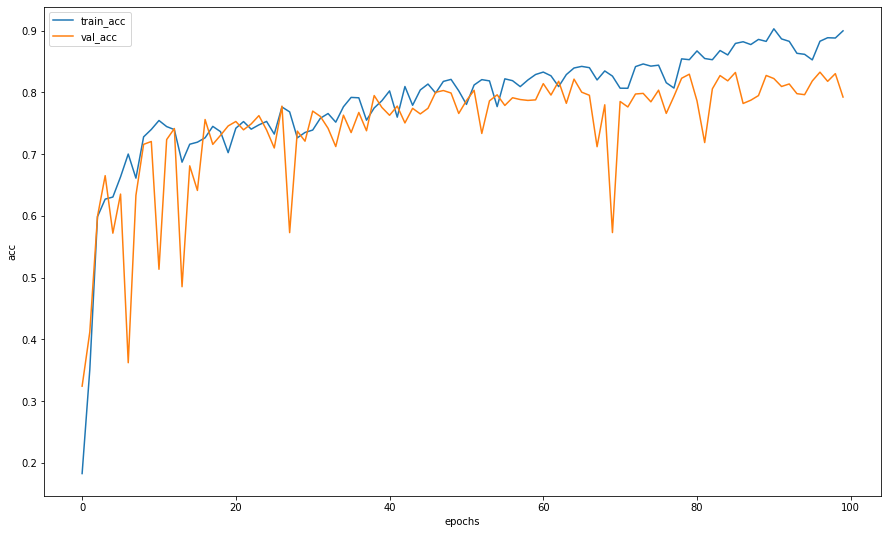

In [ ]:
plot_metric(acc, val_acc)

Сохраним модель и ее результаты:

In [ ]:
model_save_name = 'model_segnet_lovasz.pth'
path = F"/content/gdrive/My Drive/DLS/nevus/{model_save_name}" 
torch.save(model_segnet_lovasz.state_dict(), path)

In [ ]:
np.save(F"/content/gdrive/My Drive/DLS/nevus/history_segnet_lovasz.npy" , history_segnet_lovasz)

In [ ]:
del model_segnet_lovasz

-----------------------------------------------------------------------------------------

## 8. U-Net.

[**U-Net**](https://arxiv.org/abs/1505.04597) был задуман для семантической сегментации медицинских изображений, но стал настолько успешен, что с тех пор используется и в других контекстах.

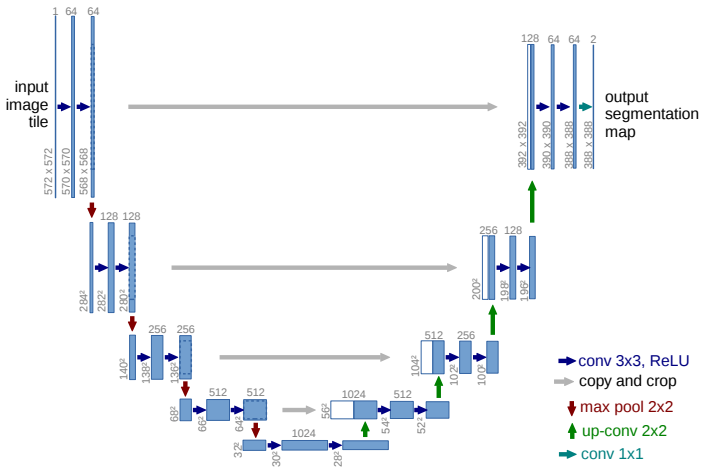

Отличительной особеностью данной модели являются skip-connections, соединяющие части кодера и декодера и представляющие собой конкатенацию симметричного выхода кодера и выхода предыдущего слоя декодера.

Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [46]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
                                nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(64),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(64),
                                nn.ReLU(inplace=True)) 
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
                                nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(128),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(128),
                                nn.ReLU(inplace=True))
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
                                nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(256),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(256),
                                nn.ReLU(inplace=True))
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
                                nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(512),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(512),
                                nn.ReLU(inplace=True))
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
                                  nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1),
                                  nn.BatchNorm2d(1024),
                                  nn.ReLU(inplace=True),
                                  nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1),
                                  nn.BatchNorm2d(1024),
                                  nn.ReLU(inplace=True))

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)   # 16 -> 32
        self.dec_conv0 = nn.Sequential(
                                nn.Conv2d(in_channels=1024 + 512, out_channels=512, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(512),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(512),
                                nn.ReLU(inplace=True))
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  # 32 -> 64
        self.dec_conv1 = nn.Sequential(
                                nn.Conv2d(in_channels=512 + 256, out_channels=256, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(256),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(256),
                                nn.ReLU(inplace=True))
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)   # 64 -> 128
        self.dec_conv2 = nn.Sequential(
                                nn.Conv2d(in_channels=256 + 128, out_channels=128, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(128),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(128),
                                nn.ReLU(inplace=True))
        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)   # 128 -> 256
        self.dec_conv3 = nn.Sequential(
                                nn.Conv2d(in_channels=128 + 64, out_channels=64, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(64),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(64),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1))

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        pool0 = self.pool0(e0)
        e1 = self.enc_conv1(pool0)
        pool1 = self.pool1(e1)
        e2 = self.enc_conv2(pool1)
        pool2 = self.pool2(e2)
        e3 = self.enc_conv3(pool2)
        pool3 = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(pool3)

        # decoder
        d0 = self.upsample0(b)
        d0 = torch.cat([d0, e3], dim=1)
        d0 = self.dec_conv0(d0)
        d1 = self.upsample1(d0)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec_conv1(d1)
        d2 = self.upsample2(d1)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec_conv2(d2)
        d3 = self.upsample3(d2)
        d3 = torch.cat([d3, e0], dim=1)
        d3 = self.dec_conv3(d3) # no activation
        return d3

Обучим модель с использованием функции потерь BCE:

In [26]:
unet_model_bce = UNet().to(DEVICE)

In [75]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, data_tr, opt, loss_fn)
            val_loss, val_acc = eval_epoch(model, data_val, loss_fn)
            history.append((train_loss, train_acc, val_loss, val_acc))
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch + 1, t_loss=train_loss, v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
    return history

In [29]:
max_epochs = 100
optimizer = optim.Adam(unet_model_bce.parameters(), lr=3e-4)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
torch.cuda.empty_cache()
history_unet_bce = train(unet_model_bce, optimizer, bce_loss, max_epochs, train_dl, val_dl)

epoch:   1%|          | 1/100 [00:08<13:15,  8.03s/it]


Epoch 001 train_loss: 0.4162 val_loss 0.5916 train_acc 0.6143 val_acc 0.0000


epoch:   2%|▏         | 2/100 [00:15<13:03,  7.99s/it]


Epoch 002 train_loss: 0.3119 val_loss 0.3647 train_acc 0.7116 val_acc 0.4600


epoch:   3%|▎         | 3/100 [00:23<12:54,  7.99s/it]


Epoch 003 train_loss: 0.3198 val_loss 0.2640 train_acc 0.6766 val_acc 0.6670


epoch:   4%|▍         | 4/100 [00:31<12:48,  8.01s/it]


Epoch 004 train_loss: 0.2702 val_loss 0.2360 train_acc 0.7489 val_acc 0.7588


epoch:   5%|▌         | 5/100 [00:40<12:44,  8.05s/it]


Epoch 005 train_loss: 0.2579 val_loss 0.2511 train_acc 0.7477 val_acc 0.7529


epoch:   6%|▌         | 6/100 [00:48<12:39,  8.08s/it]


Epoch 006 train_loss: 0.2465 val_loss 0.2527 train_acc 0.7646 val_acc 0.7643


epoch:   7%|▋         | 7/100 [00:56<12:30,  8.07s/it]


Epoch 007 train_loss: 0.2281 val_loss 0.2460 train_acc 0.7864 val_acc 0.7358


epoch:   8%|▊         | 8/100 [01:04<12:21,  8.06s/it]


Epoch 008 train_loss: 0.2352 val_loss 0.2486 train_acc 0.7616 val_acc 0.7238


epoch:   9%|▉         | 9/100 [01:12<12:10,  8.02s/it]


Epoch 009 train_loss: 0.2255 val_loss 0.2800 train_acc 0.7728 val_acc 0.7248


epoch:  10%|█         | 10/100 [01:20<11:59,  7.99s/it]


Epoch 010 train_loss: 0.2565 val_loss 0.2220 train_acc 0.7540 val_acc 0.7608


epoch:  11%|█         | 11/100 [01:28<11:49,  7.97s/it]


Epoch 011 train_loss: 0.2388 val_loss 0.2360 train_acc 0.7606 val_acc 0.7474


epoch:  12%|█▏        | 12/100 [01:36<11:39,  7.95s/it]


Epoch 012 train_loss: 0.2222 val_loss 0.2024 train_acc 0.7683 val_acc 0.8002


epoch:  13%|█▎        | 13/100 [01:43<11:31,  7.95s/it]


Epoch 013 train_loss: 0.2636 val_loss 0.1954 train_acc 0.7525 val_acc 0.7768


epoch:  14%|█▍        | 14/100 [01:51<11:24,  7.96s/it]


Epoch 014 train_loss: 0.2272 val_loss 0.2018 train_acc 0.7732 val_acc 0.7747


epoch:  15%|█▌        | 15/100 [01:59<11:18,  7.98s/it]


Epoch 015 train_loss: 0.2150 val_loss 0.2199 train_acc 0.7834 val_acc 0.7455


epoch:  16%|█▌        | 16/100 [02:08<11:11,  8.00s/it]


Epoch 016 train_loss: 0.2422 val_loss 0.1939 train_acc 0.7693 val_acc 0.7963


epoch:  17%|█▋        | 17/100 [02:16<11:05,  8.01s/it]


Epoch 017 train_loss: 0.2169 val_loss 0.2720 train_acc 0.7912 val_acc 0.6910


epoch:  18%|█▊        | 18/100 [02:24<10:57,  8.02s/it]


Epoch 018 train_loss: 0.1977 val_loss 0.1957 train_acc 0.7815 val_acc 0.7862


epoch:  19%|█▉        | 19/100 [02:32<10:50,  8.03s/it]


Epoch 019 train_loss: 0.1998 val_loss 0.1834 train_acc 0.8030 val_acc 0.7877


epoch:  20%|██        | 20/100 [02:40<10:41,  8.02s/it]


Epoch 020 train_loss: 0.2266 val_loss 0.1668 train_acc 0.7651 val_acc 0.8240


epoch:  21%|██        | 21/100 [02:48<10:32,  8.01s/it]


Epoch 021 train_loss: 0.2041 val_loss 0.1899 train_acc 0.7817 val_acc 0.7908


epoch:  22%|██▏       | 22/100 [02:56<10:23,  8.00s/it]


Epoch 022 train_loss: 0.1858 val_loss 0.1853 train_acc 0.8035 val_acc 0.7786


epoch:  23%|██▎       | 23/100 [03:04<10:15,  7.99s/it]


Epoch 023 train_loss: 0.1954 val_loss 0.1879 train_acc 0.7974 val_acc 0.8126


epoch:  24%|██▍       | 24/100 [03:12<10:07,  7.99s/it]


Epoch 024 train_loss: 0.1973 val_loss 0.1941 train_acc 0.7973 val_acc 0.7654


epoch:  25%|██▌       | 25/100 [03:20<09:59,  7.99s/it]


Epoch 025 train_loss: 0.1931 val_loss 0.1924 train_acc 0.7960 val_acc 0.7758


epoch:  26%|██▌       | 26/100 [03:28<09:51,  8.00s/it]


Epoch 026 train_loss: 0.1697 val_loss 0.1740 train_acc 0.8253 val_acc 0.7997


epoch:  27%|██▋       | 27/100 [03:36<09:44,  8.00s/it]


Epoch 027 train_loss: 0.1849 val_loss 0.1716 train_acc 0.7996 val_acc 0.7835


epoch:  28%|██▊       | 28/100 [03:44<09:36,  8.01s/it]


Epoch 028 train_loss: 0.1785 val_loss 0.1587 train_acc 0.8186 val_acc 0.8320


epoch:  29%|██▉       | 29/100 [03:52<09:29,  8.02s/it]


Epoch 029 train_loss: 0.1706 val_loss 0.1497 train_acc 0.8345 val_acc 0.8435


epoch:  30%|███       | 30/100 [04:00<09:21,  8.02s/it]


Epoch 030 train_loss: 0.1912 val_loss 0.1914 train_acc 0.8012 val_acc 0.7853


epoch:  31%|███       | 31/100 [04:08<09:13,  8.03s/it]


Epoch 031 train_loss: 0.2348 val_loss 0.1959 train_acc 0.7716 val_acc 0.7557


epoch:  32%|███▏      | 32/100 [04:16<09:05,  8.02s/it]


Epoch 032 train_loss: 0.1700 val_loss 0.1559 train_acc 0.8300 val_acc 0.8383


epoch:  33%|███▎      | 33/100 [04:24<08:56,  8.01s/it]


Epoch 033 train_loss: 0.1522 val_loss 0.1659 train_acc 0.8527 val_acc 0.8396


epoch:  34%|███▍      | 34/100 [04:32<08:48,  8.00s/it]


Epoch 034 train_loss: 0.1669 val_loss 0.1509 train_acc 0.8179 val_acc 0.8357


epoch:  35%|███▌      | 35/100 [04:40<08:39,  8.00s/it]


Epoch 035 train_loss: 0.1931 val_loss 0.1630 train_acc 0.8061 val_acc 0.8295


epoch:  36%|███▌      | 36/100 [04:48<08:32,  8.00s/it]


Epoch 036 train_loss: 0.1607 val_loss 0.1778 train_acc 0.8331 val_acc 0.8053


epoch:  37%|███▋      | 37/100 [04:56<08:24,  8.00s/it]


Epoch 037 train_loss: 0.1502 val_loss 0.1886 train_acc 0.8446 val_acc 0.7919


epoch:  38%|███▊      | 38/100 [05:04<08:16,  8.01s/it]


Epoch 038 train_loss: 0.1407 val_loss 0.1442 train_acc 0.8508 val_acc 0.8317


epoch:  39%|███▉      | 39/100 [05:12<08:08,  8.02s/it]


Epoch 039 train_loss: 0.1464 val_loss 0.1555 train_acc 0.8593 val_acc 0.8260


epoch:  40%|████      | 40/100 [05:20<08:01,  8.02s/it]


Epoch 040 train_loss: 0.1424 val_loss 0.1646 train_acc 0.8442 val_acc 0.8219


epoch:  41%|████      | 41/100 [05:28<07:53,  8.02s/it]


Epoch 041 train_loss: 0.1523 val_loss 0.1453 train_acc 0.8423 val_acc 0.8425


epoch:  42%|████▏     | 42/100 [05:36<07:45,  8.02s/it]


Epoch 042 train_loss: 0.1460 val_loss 0.1455 train_acc 0.8564 val_acc 0.8302


epoch:  43%|████▎     | 43/100 [05:44<07:37,  8.02s/it]


Epoch 043 train_loss: 0.1443 val_loss 0.1593 train_acc 0.8573 val_acc 0.8318


epoch:  44%|████▍     | 44/100 [05:52<07:29,  8.03s/it]


Epoch 044 train_loss: 0.1795 val_loss 0.1663 train_acc 0.8037 val_acc 0.8230


epoch:  45%|████▌     | 45/100 [06:00<07:21,  8.02s/it]


Epoch 045 train_loss: 0.1392 val_loss 0.1417 train_acc 0.8629 val_acc 0.8411


epoch:  46%|████▌     | 46/100 [06:08<07:13,  8.02s/it]


Epoch 046 train_loss: 0.1197 val_loss 0.1463 train_acc 0.8782 val_acc 0.8417


epoch:  47%|████▋     | 47/100 [06:16<07:04,  8.02s/it]


Epoch 047 train_loss: 0.1492 val_loss 0.1670 train_acc 0.8437 val_acc 0.8208


epoch:  48%|████▊     | 48/100 [06:24<06:56,  8.02s/it]


Epoch 048 train_loss: 0.1717 val_loss 0.1896 train_acc 0.8257 val_acc 0.7993


epoch:  49%|████▉     | 49/100 [06:32<06:48,  8.02s/it]


Epoch 049 train_loss: 0.1893 val_loss 0.1402 train_acc 0.8091 val_acc 0.8407


epoch:  50%|█████     | 50/100 [06:40<06:40,  8.01s/it]


Epoch 050 train_loss: 0.1491 val_loss 0.1473 train_acc 0.8380 val_acc 0.8214


epoch:  51%|█████     | 51/100 [06:48<06:32,  8.02s/it]


Epoch 051 train_loss: 0.1449 val_loss 0.1407 train_acc 0.8464 val_acc 0.8379


epoch:  52%|█████▏    | 52/100 [06:56<06:24,  8.02s/it]


Epoch 052 train_loss: 0.1390 val_loss 0.1433 train_acc 0.8680 val_acc 0.8363


epoch:  53%|█████▎    | 53/100 [07:04<06:16,  8.02s/it]


Epoch 053 train_loss: 0.1349 val_loss 0.1533 train_acc 0.8671 val_acc 0.8421


epoch:  54%|█████▍    | 54/100 [07:12<06:08,  8.02s/it]


Epoch 054 train_loss: 0.1354 val_loss 0.1549 train_acc 0.8628 val_acc 0.8210


epoch:  55%|█████▌    | 55/100 [07:20<06:00,  8.02s/it]


Epoch 055 train_loss: 0.1282 val_loss 0.1443 train_acc 0.8691 val_acc 0.8388


epoch:  56%|█████▌    | 56/100 [07:28<05:52,  8.02s/it]


Epoch 056 train_loss: 0.1113 val_loss 0.1383 train_acc 0.8846 val_acc 0.8414


epoch:  57%|█████▋    | 57/100 [07:36<05:44,  8.02s/it]


Epoch 057 train_loss: 0.1447 val_loss 0.1565 train_acc 0.8497 val_acc 0.8324


epoch:  58%|█████▊    | 58/100 [07:44<05:36,  8.02s/it]


Epoch 058 train_loss: 0.1226 val_loss 0.1501 train_acc 0.8716 val_acc 0.8402


epoch:  59%|█████▉    | 59/100 [07:52<05:28,  8.02s/it]


Epoch 059 train_loss: 0.1260 val_loss 0.1337 train_acc 0.8688 val_acc 0.8355


epoch:  60%|██████    | 60/100 [08:00<05:20,  8.01s/it]


Epoch 060 train_loss: 0.1063 val_loss 0.1439 train_acc 0.8833 val_acc 0.8432


epoch:  61%|██████    | 61/100 [08:08<05:12,  8.01s/it]


Epoch 061 train_loss: 0.1289 val_loss 0.1489 train_acc 0.8641 val_acc 0.8428


epoch:  62%|██████▏   | 62/100 [08:16<05:04,  8.01s/it]


Epoch 062 train_loss: 0.1147 val_loss 0.1326 train_acc 0.8761 val_acc 0.8527


epoch:  63%|██████▎   | 63/100 [08:24<04:56,  8.00s/it]


Epoch 063 train_loss: 0.1172 val_loss 0.1325 train_acc 0.8764 val_acc 0.8567


epoch:  64%|██████▍   | 64/100 [08:32<04:48,  8.00s/it]


Epoch 064 train_loss: 0.1418 val_loss 0.1467 train_acc 0.8558 val_acc 0.8266


epoch:  65%|██████▌   | 65/100 [08:40<04:39,  8.00s/it]


Epoch 065 train_loss: 0.1249 val_loss 0.1752 train_acc 0.8621 val_acc 0.8117


epoch:  66%|██████▌   | 66/100 [08:48<04:31,  8.00s/it]


Epoch 066 train_loss: 0.1117 val_loss 0.1301 train_acc 0.8843 val_acc 0.8600


epoch:  67%|██████▋   | 67/100 [08:56<04:24,  8.00s/it]


Epoch 067 train_loss: 0.1208 val_loss 0.1550 train_acc 0.8699 val_acc 0.8326


epoch:  68%|██████▊   | 68/100 [09:04<04:16,  8.00s/it]


Epoch 068 train_loss: 0.1123 val_loss 0.1338 train_acc 0.8752 val_acc 0.8499


epoch:  69%|██████▉   | 69/100 [09:12<04:08,  8.00s/it]


Epoch 069 train_loss: 0.1233 val_loss 0.1371 train_acc 0.8556 val_acc 0.8512


epoch:  70%|███████   | 70/100 [09:20<04:00,  8.00s/it]


Epoch 070 train_loss: 0.1039 val_loss 0.1309 train_acc 0.8887 val_acc 0.8561


epoch:  71%|███████   | 71/100 [09:28<03:52,  8.01s/it]


Epoch 071 train_loss: 0.1032 val_loss 0.1298 train_acc 0.8861 val_acc 0.8567


epoch:  72%|███████▏  | 72/100 [09:36<03:44,  8.01s/it]


Epoch 072 train_loss: 0.0925 val_loss 0.1263 train_acc 0.8984 val_acc 0.8635


epoch:  73%|███████▎  | 73/100 [09:44<03:36,  8.01s/it]


Epoch 073 train_loss: 0.0839 val_loss 0.1341 train_acc 0.9073 val_acc 0.8591


epoch:  74%|███████▍  | 74/100 [09:52<03:28,  8.01s/it]


Epoch 074 train_loss: 0.0926 val_loss 0.1311 train_acc 0.9034 val_acc 0.8559


epoch:  75%|███████▌  | 75/100 [10:00<03:20,  8.01s/it]


Epoch 075 train_loss: 0.0886 val_loss 0.1353 train_acc 0.8989 val_acc 0.8618


epoch:  76%|███████▌  | 76/100 [10:08<03:12,  8.01s/it]


Epoch 076 train_loss: 0.0856 val_loss 0.1558 train_acc 0.9075 val_acc 0.8341


epoch:  77%|███████▋  | 77/100 [10:16<03:04,  8.01s/it]


Epoch 077 train_loss: 0.0861 val_loss 0.1188 train_acc 0.9028 val_acc 0.8753


epoch:  78%|███████▊  | 78/100 [10:24<02:56,  8.00s/it]


Epoch 078 train_loss: 0.0774 val_loss 0.1200 train_acc 0.9120 val_acc 0.8801


epoch:  79%|███████▉  | 79/100 [10:32<02:48,  8.01s/it]


Epoch 079 train_loss: 0.0840 val_loss 0.1321 train_acc 0.9072 val_acc 0.8565


epoch:  80%|████████  | 80/100 [10:40<02:40,  8.01s/it]


Epoch 080 train_loss: 0.0952 val_loss 0.1669 train_acc 0.8926 val_acc 0.8293


epoch:  81%|████████  | 81/100 [10:48<02:32,  8.01s/it]


Epoch 081 train_loss: 0.1024 val_loss 0.1366 train_acc 0.8869 val_acc 0.8444


epoch:  82%|████████▏ | 82/100 [10:56<02:24,  8.01s/it]


Epoch 082 train_loss: 0.1100 val_loss 0.1536 train_acc 0.8840 val_acc 0.8401


epoch:  83%|████████▎ | 83/100 [11:04<02:16,  8.01s/it]


Epoch 083 train_loss: 0.1183 val_loss 0.1432 train_acc 0.8717 val_acc 0.8328


epoch:  84%|████████▍ | 84/100 [11:12<02:08,  8.01s/it]


Epoch 084 train_loss: 0.1063 val_loss 0.4279 train_acc 0.8829 val_acc 0.6788


epoch:  85%|████████▌ | 85/100 [11:20<02:00,  8.02s/it]


Epoch 085 train_loss: 0.1070 val_loss 0.1623 train_acc 0.8852 val_acc 0.8121


epoch:  86%|████████▌ | 86/100 [11:28<01:52,  8.02s/it]


Epoch 086 train_loss: 0.0861 val_loss 0.1413 train_acc 0.9042 val_acc 0.8463


epoch:  87%|████████▋ | 87/100 [11:36<01:44,  8.01s/it]


Epoch 087 train_loss: 0.1005 val_loss 0.1796 train_acc 0.8950 val_acc 0.8073


epoch:  88%|████████▊ | 88/100 [11:44<01:36,  8.01s/it]


Epoch 088 train_loss: 0.0854 val_loss 0.1257 train_acc 0.9014 val_acc 0.8625


epoch:  89%|████████▉ | 89/100 [11:52<01:28,  8.01s/it]


Epoch 089 train_loss: 0.0976 val_loss 0.1207 train_acc 0.8911 val_acc 0.8647


epoch:  90%|█████████ | 90/100 [12:00<01:20,  8.01s/it]


Epoch 090 train_loss: 0.0878 val_loss 0.1197 train_acc 0.9067 val_acc 0.8722


epoch:  91%|█████████ | 91/100 [12:08<01:12,  8.01s/it]


Epoch 091 train_loss: 0.0802 val_loss 0.1116 train_acc 0.9112 val_acc 0.8793


epoch:  92%|█████████▏| 92/100 [12:16<01:04,  8.01s/it]


Epoch 092 train_loss: 0.0733 val_loss 0.1395 train_acc 0.9162 val_acc 0.8510


epoch:  93%|█████████▎| 93/100 [12:24<00:56,  8.01s/it]


Epoch 093 train_loss: 0.0665 val_loss 0.1099 train_acc 0.9278 val_acc 0.8851


epoch:  94%|█████████▍| 94/100 [12:32<00:48,  8.01s/it]


Epoch 094 train_loss: 0.0634 val_loss 0.1154 train_acc 0.9273 val_acc 0.8741


epoch:  95%|█████████▌| 95/100 [12:40<00:40,  8.01s/it]


Epoch 095 train_loss: 0.0678 val_loss 0.1383 train_acc 0.9236 val_acc 0.8722


epoch:  96%|█████████▌| 96/100 [12:48<00:32,  8.00s/it]


Epoch 096 train_loss: 0.0716 val_loss 0.1413 train_acc 0.9200 val_acc 0.8532


epoch:  97%|█████████▋| 97/100 [12:56<00:24,  8.00s/it]


Epoch 097 train_loss: 0.0641 val_loss 0.1172 train_acc 0.9287 val_acc 0.8855


epoch:  98%|█████████▊| 98/100 [13:04<00:16,  8.00s/it]


Epoch 098 train_loss: 0.0651 val_loss 0.1330 train_acc 0.9248 val_acc 0.8575


epoch:  99%|█████████▉| 99/100 [13:12<00:07,  8.00s/it]


Epoch 099 train_loss: 0.0754 val_loss 0.1185 train_acc 0.9133 val_acc 0.8761


epoch: 100%|██████████| 100/100 [13:20<00:00,  8.01s/it]


Epoch 100 train_loss: 0.0675 val_loss 0.1190 train_acc 0.9246 val_acc 0.8686


Визуализируем результат:

In [30]:
loss, acc, val_loss, val_acc = zip(*history_unet_bce)

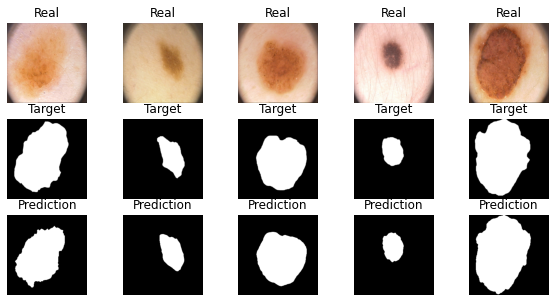

In [33]:
visualize(unet_model_bce)

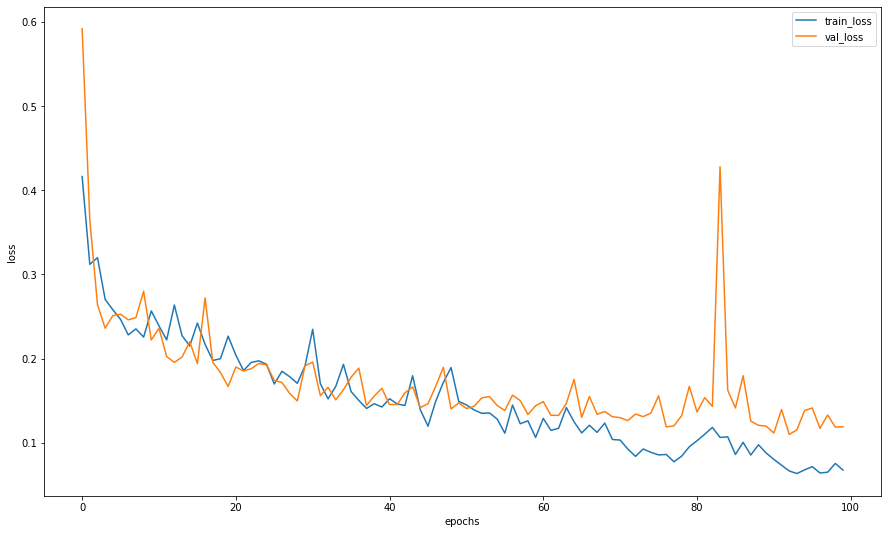

In [34]:
plot_loss(loss, val_loss)

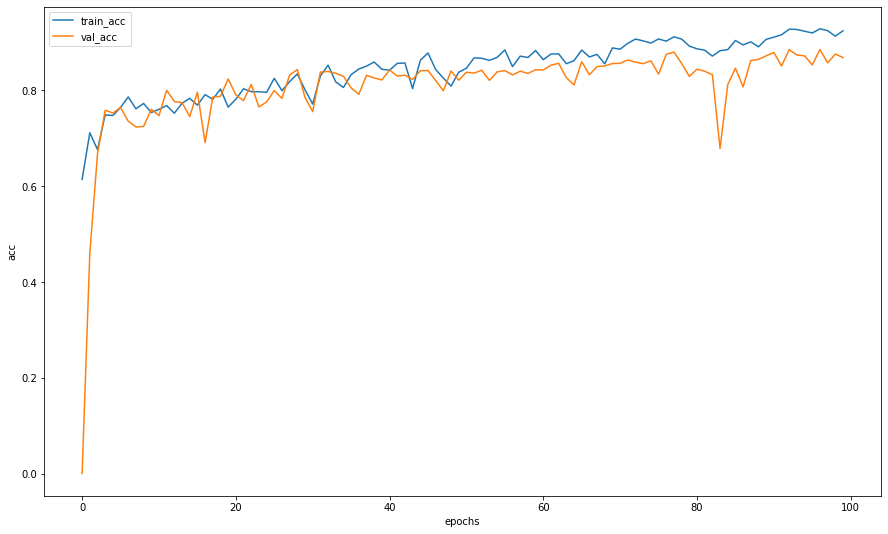

In [35]:
plot_metric(acc, val_acc)

Сохраним модель и ее результаты:

In [36]:
model_save_name = 'model_unet_bce.pth'
path = F"/content/gdrive/My Drive/DLS/nevus/{model_save_name}" 
torch.save(unet_model_bce.state_dict(), path)

In [37]:
np.save(F"/content/gdrive/My Drive/DLS/nevus/history_unet_bce.npy" , history_unet_bce)

In [ ]:
del unet_model_bce

### 8.1. Unet с dice loss.

In [96]:
unet_model_dice = UNet().to(DEVICE)

In [68]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, data_tr, opt, loss_fn)
            val_loss, val_acc = eval_epoch(model, data_val, loss_fn)
            history.append((train_loss, train_acc, val_loss, val_acc))
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch + 1, t_loss=train_loss, v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
        if epoch > 10:
          scheduler.step()
    return history

In [97]:
max_epochs = 100
optimizer = optim.Adam(unet_model_dice.parameters(), lr=3e-4)
torch.cuda.empty_cache()
history_unet_dice = train(unet_model_dice, optimizer, dice_loss, max_epochs, train_dl, val_dl)

epoch:   1%|          | 1/100 [00:08<13:37,  8.26s/it]


Epoch 001 train_loss: 0.2442 val_loss 0.9717 train_acc 0.5740 val_acc 0.2230


epoch:   2%|▏         | 2/100 [00:16<13:29,  8.27s/it]


Epoch 002 train_loss: 0.1386 val_loss 0.3359 train_acc 0.6653 val_acc 0.5567


epoch:   3%|▎         | 3/100 [00:24<13:20,  8.25s/it]


Epoch 003 train_loss: 0.1220 val_loss 0.1363 train_acc 0.6305 val_acc 0.6573


epoch:   4%|▍         | 4/100 [00:32<13:07,  8.20s/it]


Epoch 004 train_loss: 0.1167 val_loss 0.1178 train_acc 0.5899 val_acc 0.5885


epoch:   5%|▌         | 5/100 [00:40<12:53,  8.14s/it]


Epoch 005 train_loss: 0.1143 val_loss 0.1602 train_acc 0.6002 val_acc 0.7122


epoch:   6%|▌         | 6/100 [00:48<12:39,  8.08s/it]


Epoch 006 train_loss: 0.1318 val_loss 0.1190 train_acc 0.5962 val_acc 0.6509


epoch:   7%|▋         | 7/100 [00:56<12:26,  8.03s/it]


Epoch 007 train_loss: 0.1247 val_loss 0.1190 train_acc 0.5592 val_acc 0.6037


epoch:   8%|▊         | 8/100 [01:04<12:14,  7.99s/it]


Epoch 008 train_loss: 0.1098 val_loss 0.1104 train_acc 0.5746 val_acc 0.6157


epoch:   9%|▉         | 9/100 [01:12<12:05,  7.97s/it]


Epoch 009 train_loss: 0.0998 val_loss 0.1291 train_acc 0.6218 val_acc 0.7070


epoch:  10%|█         | 10/100 [01:20<11:57,  7.97s/it]


Epoch 010 train_loss: 0.1122 val_loss 0.1385 train_acc 0.5394 val_acc 0.5916


epoch:  11%|█         | 11/100 [01:28<11:50,  7.98s/it]


Epoch 011 train_loss: 0.1086 val_loss 0.1098 train_acc 0.5615 val_acc 0.5877


epoch:  12%|█▏        | 12/100 [01:36<11:43,  8.00s/it]


Epoch 012 train_loss: 0.0902 val_loss 0.0844 train_acc 0.5947 val_acc 0.5901


epoch:  13%|█▎        | 13/100 [01:44<11:37,  8.02s/it]


Epoch 013 train_loss: 0.1136 val_loss 0.1480 train_acc 0.5861 val_acc 0.7228


epoch:  14%|█▍        | 14/100 [01:52<11:30,  8.02s/it]


Epoch 014 train_loss: 0.1044 val_loss 0.1152 train_acc 0.5869 val_acc 0.5614


epoch:  15%|█▌        | 15/100 [02:00<11:21,  8.02s/it]


Epoch 015 train_loss: 0.0973 val_loss 0.0795 train_acc 0.6091 val_acc 0.6214


epoch:  16%|█▌        | 16/100 [02:08<11:13,  8.01s/it]


Epoch 016 train_loss: 0.1123 val_loss 0.1052 train_acc 0.5185 val_acc 0.6119


epoch:  17%|█▋        | 17/100 [02:16<11:04,  8.00s/it]


Epoch 017 train_loss: 0.0810 val_loss 0.1080 train_acc 0.6195 val_acc 0.7242


epoch:  18%|█▊        | 18/100 [02:24<10:55,  7.99s/it]


Epoch 018 train_loss: 0.0997 val_loss 0.0955 train_acc 0.5888 val_acc 0.5734


epoch:  19%|█▉        | 19/100 [02:32<10:46,  7.99s/it]


Epoch 019 train_loss: 0.0870 val_loss 0.1058 train_acc 0.5670 val_acc 0.5811


epoch:  20%|██        | 20/100 [02:40<10:38,  7.98s/it]


Epoch 020 train_loss: 0.0763 val_loss 0.0814 train_acc 0.5836 val_acc 0.6336


epoch:  21%|██        | 21/100 [02:48<10:30,  7.98s/it]


Epoch 021 train_loss: 0.0910 val_loss 0.1051 train_acc 0.6132 val_acc 0.6452


epoch:  22%|██▏       | 22/100 [02:56<10:22,  7.99s/it]


Epoch 022 train_loss: 0.0820 val_loss 0.1008 train_acc 0.5984 val_acc 0.5977


epoch:  23%|██▎       | 23/100 [03:04<10:15,  8.00s/it]


Epoch 023 train_loss: 0.0846 val_loss 0.0915 train_acc 0.6133 val_acc 0.7215


epoch:  24%|██▍       | 24/100 [03:12<10:08,  8.00s/it]


Epoch 024 train_loss: 0.0925 val_loss 0.0900 train_acc 0.5919 val_acc 0.5172


epoch:  25%|██▌       | 25/100 [03:20<10:00,  8.01s/it]


Epoch 025 train_loss: 0.1000 val_loss 0.0938 train_acc 0.5804 val_acc 0.7113


epoch:  26%|██▌       | 26/100 [03:28<09:52,  8.01s/it]


Epoch 026 train_loss: 0.0924 val_loss 0.0884 train_acc 0.5944 val_acc 0.6756


epoch:  27%|██▋       | 27/100 [03:36<09:44,  8.01s/it]


Epoch 027 train_loss: 0.0818 val_loss 0.0866 train_acc 0.5539 val_acc 0.6329


epoch:  28%|██▊       | 28/100 [03:44<09:36,  8.01s/it]


Epoch 028 train_loss: 0.0742 val_loss 0.0798 train_acc 0.5906 val_acc 0.6382


epoch:  29%|██▉       | 29/100 [03:52<09:28,  8.00s/it]


Epoch 029 train_loss: 0.0751 val_loss 0.0772 train_acc 0.6621 val_acc 0.6729


epoch:  30%|███       | 30/100 [04:00<09:20,  8.00s/it]


Epoch 030 train_loss: 0.0685 val_loss 0.0832 train_acc 0.6526 val_acc 0.6723


epoch:  31%|███       | 31/100 [04:08<09:11,  8.00s/it]


Epoch 031 train_loss: 0.0723 val_loss 0.0902 train_acc 0.6109 val_acc 0.6752


epoch:  32%|███▏      | 32/100 [04:16<09:03,  8.00s/it]


Epoch 032 train_loss: 0.0766 val_loss 0.0816 train_acc 0.6400 val_acc 0.5571


epoch:  33%|███▎      | 33/100 [04:24<08:55,  7.99s/it]


Epoch 033 train_loss: 0.0792 val_loss 0.0767 train_acc 0.6449 val_acc 0.7009


epoch:  34%|███▍      | 34/100 [04:32<08:47,  7.99s/it]


Epoch 034 train_loss: 0.0596 val_loss 0.0724 train_acc 0.6336 val_acc 0.7240


epoch:  35%|███▌      | 35/100 [04:40<08:38,  7.98s/it]


Epoch 035 train_loss: 0.0676 val_loss 0.0797 train_acc 0.6831 val_acc 0.6696


epoch:  36%|███▌      | 36/100 [04:48<08:30,  7.98s/it]


Epoch 036 train_loss: 0.0713 val_loss 0.0759 train_acc 0.6659 val_acc 0.6529


epoch:  37%|███▋      | 37/100 [04:56<08:22,  7.98s/it]


Epoch 037 train_loss: 0.0715 val_loss 0.0792 train_acc 0.6782 val_acc 0.6208


epoch:  38%|███▊      | 38/100 [05:04<08:14,  7.98s/it]


Epoch 038 train_loss: 0.0652 val_loss 0.1168 train_acc 0.6640 val_acc 0.6144


epoch:  39%|███▉      | 39/100 [05:12<08:06,  7.98s/it]


Epoch 039 train_loss: 0.0690 val_loss 0.0739 train_acc 0.6780 val_acc 0.6687


epoch:  40%|████      | 40/100 [05:20<07:58,  7.98s/it]


Epoch 040 train_loss: 0.0682 val_loss 0.0834 train_acc 0.6826 val_acc 0.7642


epoch:  41%|████      | 41/100 [05:28<07:50,  7.98s/it]


Epoch 041 train_loss: 0.0603 val_loss 0.0678 train_acc 0.6704 val_acc 0.6520


epoch:  42%|████▏     | 42/100 [05:36<07:42,  7.98s/it]


Epoch 042 train_loss: 0.0739 val_loss 0.0737 train_acc 0.6580 val_acc 0.7228


epoch:  43%|████▎     | 43/100 [05:44<07:35,  7.98s/it]


Epoch 043 train_loss: 0.0634 val_loss 0.1125 train_acc 0.6825 val_acc 0.7324


epoch:  44%|████▍     | 44/100 [05:52<07:27,  7.99s/it]


Epoch 044 train_loss: 0.0649 val_loss 0.0787 train_acc 0.6624 val_acc 0.6629


epoch:  45%|████▌     | 45/100 [06:00<07:19,  7.99s/it]


Epoch 045 train_loss: 0.0674 val_loss 0.0703 train_acc 0.6894 val_acc 0.6791


epoch:  46%|████▌     | 46/100 [06:08<07:11,  7.99s/it]


Epoch 046 train_loss: 0.0585 val_loss 0.0820 train_acc 0.6801 val_acc 0.6482


epoch:  47%|████▋     | 47/100 [06:16<07:03,  8.00s/it]


Epoch 047 train_loss: 0.0573 val_loss 0.0792 train_acc 0.6799 val_acc 0.7112


epoch:  48%|████▊     | 48/100 [06:24<06:56,  8.00s/it]


Epoch 048 train_loss: 0.0589 val_loss 0.0685 train_acc 0.6583 val_acc 0.6657


epoch:  49%|████▉     | 49/100 [06:32<06:48,  8.01s/it]


Epoch 049 train_loss: 0.0618 val_loss 0.0805 train_acc 0.6859 val_acc 0.6633


epoch:  50%|█████     | 50/100 [06:40<06:40,  8.01s/it]


Epoch 050 train_loss: 0.0721 val_loss 0.1145 train_acc 0.6696 val_acc 0.5380


epoch:  51%|█████     | 51/100 [06:48<06:32,  8.00s/it]


Epoch 051 train_loss: 0.0726 val_loss 0.0890 train_acc 0.6633 val_acc 0.6222


epoch:  52%|█████▏    | 52/100 [06:56<06:23,  8.00s/it]


Epoch 052 train_loss: 0.0719 val_loss 0.0862 train_acc 0.6421 val_acc 0.7521


epoch:  53%|█████▎    | 53/100 [07:04<06:15,  7.99s/it]


Epoch 053 train_loss: 0.0647 val_loss 0.0866 train_acc 0.6690 val_acc 0.6661


epoch:  54%|█████▍    | 54/100 [07:12<06:07,  7.99s/it]


Epoch 054 train_loss: 0.0572 val_loss 0.0739 train_acc 0.6670 val_acc 0.6784


epoch:  55%|█████▌    | 55/100 [07:20<05:59,  7.98s/it]


Epoch 055 train_loss: 0.0618 val_loss 0.0734 train_acc 0.6991 val_acc 0.7501


epoch:  56%|█████▌    | 56/100 [07:28<05:51,  7.98s/it]


Epoch 056 train_loss: 0.0567 val_loss 0.0675 train_acc 0.6937 val_acc 0.7182


epoch:  57%|█████▋    | 57/100 [07:36<05:42,  7.97s/it]


Epoch 057 train_loss: 0.0600 val_loss 0.0757 train_acc 0.6477 val_acc 0.6577


epoch:  58%|█████▊    | 58/100 [07:44<05:35,  7.98s/it]


Epoch 058 train_loss: 0.0539 val_loss 0.0755 train_acc 0.6781 val_acc 0.5918


epoch:  59%|█████▉    | 59/100 [07:52<05:27,  7.98s/it]


Epoch 059 train_loss: 0.0630 val_loss 0.0747 train_acc 0.7112 val_acc 0.6747


epoch:  60%|██████    | 60/100 [08:00<05:19,  7.99s/it]


Epoch 060 train_loss: 0.0554 val_loss 0.0702 train_acc 0.7057 val_acc 0.6799


epoch:  61%|██████    | 61/100 [08:08<05:12,  8.00s/it]


Epoch 061 train_loss: 0.0669 val_loss 0.0734 train_acc 0.6615 val_acc 0.6077


epoch:  62%|██████▏   | 62/100 [08:16<05:04,  8.01s/it]


Epoch 062 train_loss: 0.0619 val_loss 0.0601 train_acc 0.7021 val_acc 0.7123


epoch:  63%|██████▎   | 63/100 [08:24<04:56,  8.00s/it]


Epoch 063 train_loss: 0.0624 val_loss 0.0632 train_acc 0.6527 val_acc 0.6934


epoch:  64%|██████▍   | 64/100 [08:32<04:48,  8.00s/it]


Epoch 064 train_loss: 0.0553 val_loss 0.0541 train_acc 0.6353 val_acc 0.6942


epoch:  65%|██████▌   | 65/100 [08:40<04:40,  8.00s/it]


Epoch 065 train_loss: 0.0479 val_loss 0.0731 train_acc 0.6923 val_acc 0.6281


epoch:  66%|██████▌   | 66/100 [08:48<04:31,  8.00s/it]


Epoch 066 train_loss: 0.0719 val_loss 0.0772 train_acc 0.6723 val_acc 0.6330


epoch:  67%|██████▋   | 67/100 [08:56<04:23,  7.99s/it]


Epoch 067 train_loss: 0.0654 val_loss 0.0868 train_acc 0.6366 val_acc 0.6061


epoch:  68%|██████▊   | 68/100 [09:04<04:15,  7.99s/it]


Epoch 068 train_loss: 0.0712 val_loss 0.0730 train_acc 0.6403 val_acc 0.6681


epoch:  69%|██████▉   | 69/100 [09:12<04:07,  7.99s/it]


Epoch 069 train_loss: 0.0681 val_loss 0.1186 train_acc 0.6437 val_acc 0.6312


epoch:  70%|███████   | 70/100 [09:20<03:59,  7.99s/it]


Epoch 070 train_loss: 0.0664 val_loss 0.0666 train_acc 0.6464 val_acc 0.6282


epoch:  71%|███████   | 71/100 [09:28<03:51,  7.99s/it]


Epoch 071 train_loss: 0.0564 val_loss 0.0699 train_acc 0.7052 val_acc 0.6669


epoch:  72%|███████▏  | 72/100 [09:36<03:43,  7.98s/it]


Epoch 072 train_loss: 0.0568 val_loss 0.0629 train_acc 0.6690 val_acc 0.6589


epoch:  73%|███████▎  | 73/100 [09:44<03:35,  7.98s/it]


Epoch 073 train_loss: 0.0598 val_loss 0.0691 train_acc 0.6804 val_acc 0.6285


epoch:  74%|███████▍  | 74/100 [09:52<03:27,  7.98s/it]


Epoch 074 train_loss: 0.0562 val_loss 0.0646 train_acc 0.6772 val_acc 0.5907


epoch:  75%|███████▌  | 75/100 [10:00<03:19,  7.98s/it]


Epoch 075 train_loss: 0.0512 val_loss 0.0653 train_acc 0.6655 val_acc 0.7224


epoch:  76%|███████▌  | 76/100 [10:08<03:11,  7.98s/it]


Epoch 076 train_loss: 0.0493 val_loss 0.0668 train_acc 0.7013 val_acc 0.5966


epoch:  77%|███████▋  | 77/100 [10:16<03:03,  7.99s/it]


Epoch 077 train_loss: 0.0438 val_loss 0.0598 train_acc 0.6940 val_acc 0.7238


epoch:  78%|███████▊  | 78/100 [10:24<02:55,  7.99s/it]


Epoch 078 train_loss: 0.0465 val_loss 0.0955 train_acc 0.7241 val_acc 0.7835


epoch:  79%|███████▉  | 79/100 [10:32<02:47,  7.99s/it]


Epoch 079 train_loss: 0.0542 val_loss 0.0673 train_acc 0.6905 val_acc 0.7062


epoch:  80%|████████  | 80/100 [10:40<02:39,  7.99s/it]


Epoch 080 train_loss: 0.0547 val_loss 0.0646 train_acc 0.7207 val_acc 0.6594


epoch:  81%|████████  | 81/100 [10:48<02:31,  8.00s/it]


Epoch 081 train_loss: 0.0615 val_loss 0.0738 train_acc 0.7102 val_acc 0.6458


epoch:  82%|████████▏ | 82/100 [10:56<02:23,  8.00s/it]


Epoch 082 train_loss: 0.0477 val_loss 0.0663 train_acc 0.7066 val_acc 0.6998


epoch:  83%|████████▎ | 83/100 [11:04<02:15,  8.00s/it]


Epoch 083 train_loss: 0.0379 val_loss 0.0581 train_acc 0.6880 val_acc 0.7413


epoch:  84%|████████▍ | 84/100 [11:12<02:07,  8.00s/it]


Epoch 084 train_loss: 0.0380 val_loss 0.0610 train_acc 0.7345 val_acc 0.7884


epoch:  85%|████████▌ | 85/100 [11:20<01:59,  8.00s/it]


Epoch 085 train_loss: 0.0395 val_loss 0.0595 train_acc 0.7349 val_acc 0.6799


epoch:  86%|████████▌ | 86/100 [11:28<01:51,  8.00s/it]


Epoch 086 train_loss: 0.0406 val_loss 0.0587 train_acc 0.7412 val_acc 0.7315


epoch:  87%|████████▋ | 87/100 [11:36<01:44,  8.00s/it]


Epoch 087 train_loss: 0.0467 val_loss 0.0617 train_acc 0.7199 val_acc 0.6116


epoch:  88%|████████▊ | 88/100 [11:44<01:36,  8.00s/it]


Epoch 088 train_loss: 0.0527 val_loss 0.0638 train_acc 0.7041 val_acc 0.7335


epoch:  89%|████████▉ | 89/100 [11:52<01:28,  8.01s/it]


Epoch 089 train_loss: 0.0457 val_loss 0.0778 train_acc 0.6743 val_acc 0.5826


epoch:  90%|█████████ | 90/100 [12:00<01:20,  8.01s/it]


Epoch 090 train_loss: 0.0535 val_loss 0.0622 train_acc 0.6781 val_acc 0.6536


epoch:  91%|█████████ | 91/100 [12:08<01:12,  8.01s/it]


Epoch 091 train_loss: 0.0503 val_loss 0.0673 train_acc 0.6884 val_acc 0.6735


epoch:  92%|█████████▏| 92/100 [12:16<01:04,  8.01s/it]


Epoch 092 train_loss: 0.0461 val_loss 0.0649 train_acc 0.7119 val_acc 0.7111


epoch:  93%|█████████▎| 93/100 [12:24<00:56,  8.01s/it]


Epoch 093 train_loss: 0.0452 val_loss 0.0670 train_acc 0.7141 val_acc 0.6986


epoch:  94%|█████████▍| 94/100 [12:32<00:48,  8.01s/it]


Epoch 094 train_loss: 0.0451 val_loss 0.0738 train_acc 0.7623 val_acc 0.7281


epoch:  95%|█████████▌| 95/100 [12:40<00:40,  8.01s/it]


Epoch 095 train_loss: 0.0459 val_loss 0.0570 train_acc 0.7038 val_acc 0.7413


epoch:  96%|█████████▌| 96/100 [12:48<00:32,  8.01s/it]


Epoch 096 train_loss: 0.0418 val_loss 0.0610 train_acc 0.7288 val_acc 0.6902


epoch:  97%|█████████▋| 97/100 [12:56<00:24,  8.01s/it]


Epoch 097 train_loss: 0.0424 val_loss 0.0590 train_acc 0.7032 val_acc 0.7072


epoch:  98%|█████████▊| 98/100 [13:04<00:16,  8.01s/it]


Epoch 098 train_loss: 0.0402 val_loss 0.0607 train_acc 0.7670 val_acc 0.6941


epoch:  99%|█████████▉| 99/100 [13:12<00:08,  8.01s/it]


Epoch 099 train_loss: 0.0378 val_loss 0.0625 train_acc 0.7865 val_acc 0.8062


epoch: 100%|██████████| 100/100 [13:20<00:00,  8.00s/it]


Epoch 100 train_loss: 0.0336 val_loss 0.0591 train_acc 0.7799 val_acc 0.6971


Визуализируем результат:

In [98]:
loss, acc, val_loss, val_acc = zip(*history_unet_dice)

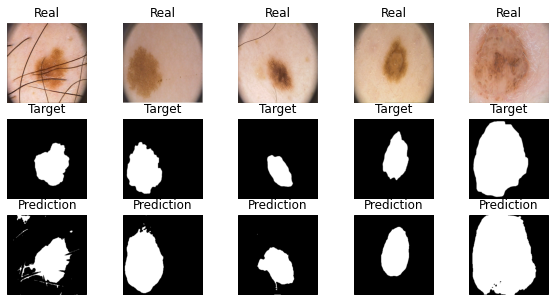

In [101]:
visualize(unet_model_dice)

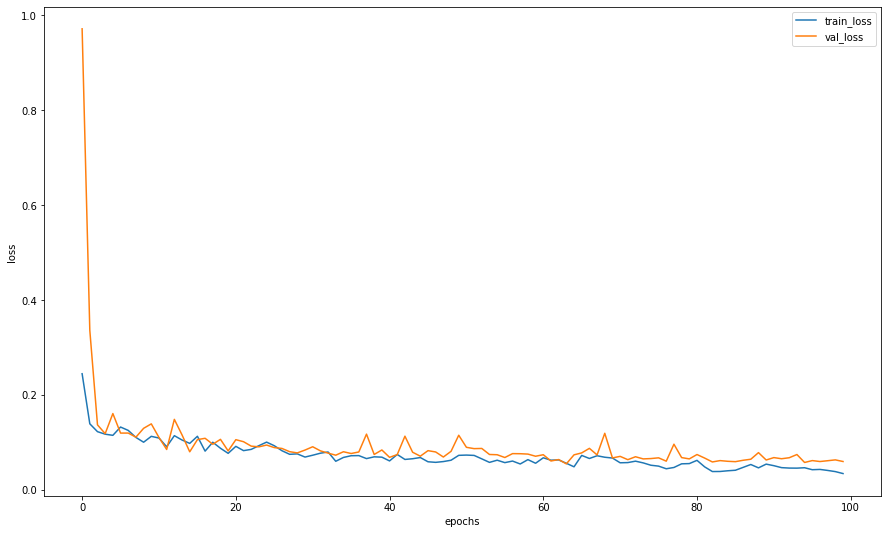

In [99]:
plot_loss(loss, val_loss)

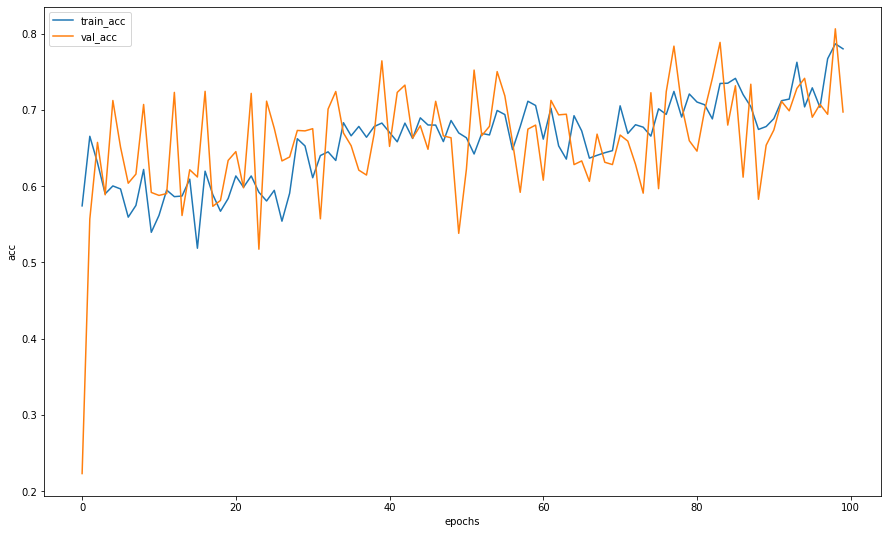

In [100]:
plot_metric(acc, val_acc)

Сохраним модель и ее результаты:

In [102]:
model_save_name = 'model_unet_dice.pth'
path = F"/content/gdrive/My Drive/DLS/nevus/{model_save_name}" 
torch.save(unet_model_dice.state_dict(), path)

In [103]:
np.save(F"/content/gdrive/My Drive/DLS/nevus/history_unet_dice.npy" , history_unet_dice)

In [104]:
del unet_model_dice

### 8.2. Unet с focal loss.

In [105]:
unet_model_focal = UNet().to(DEVICE)

In [156]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, data_tr, opt, loss_fn)
            val_loss, val_acc = eval_epoch(model, data_val, loss_fn)
            history.append((train_loss, train_acc, val_loss, val_acc))
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch + 1, t_loss=train_loss, v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
    return history

In [106]:
max_epochs = 100
optimizer = optim.Adam(unet_model_focal.parameters(), lr=3e-4)
torch.cuda.empty_cache()
history_unet_focal = train(unet_model_focal, optimizer, focal_loss, max_epochs, train_dl, val_dl)

epoch:   1%|          | 1/100 [00:08<13:26,  8.15s/it]


Epoch 001 train_loss: 0.1612 val_loss 0.1733 train_acc 0.5696 val_acc 0.0001


epoch:   2%|▏         | 2/100 [00:16<13:20,  8.17s/it]


Epoch 002 train_loss: 0.1462 val_loss 0.1585 train_acc 0.6729 val_acc 0.3513


epoch:   3%|▎         | 3/100 [00:24<13:13,  8.18s/it]


Epoch 003 train_loss: 0.1440 val_loss 0.1465 train_acc 0.7069 val_acc 0.6430


epoch:   4%|▍         | 4/100 [00:32<13:02,  8.15s/it]


Epoch 004 train_loss: 0.1434 val_loss 0.1479 train_acc 0.7252 val_acc 0.6939


epoch:   5%|▌         | 5/100 [00:40<12:51,  8.12s/it]


Epoch 005 train_loss: 0.1454 val_loss 0.1470 train_acc 0.7152 val_acc 0.6708


epoch:   6%|▌         | 6/100 [00:48<12:38,  8.07s/it]


Epoch 006 train_loss: 0.1458 val_loss 0.1463 train_acc 0.6772 val_acc 0.6422


epoch:   7%|▋         | 7/100 [00:56<12:26,  8.03s/it]


Epoch 007 train_loss: 0.1458 val_loss 0.1530 train_acc 0.6902 val_acc 0.5762


epoch:   8%|▊         | 8/100 [01:04<12:15,  8.00s/it]


Epoch 008 train_loss: 0.1427 val_loss 0.1454 train_acc 0.7331 val_acc 0.7067


epoch:   9%|▉         | 9/100 [01:12<12:05,  7.98s/it]


Epoch 009 train_loss: 0.1403 val_loss 0.1429 train_acc 0.7732 val_acc 0.7304


epoch:  10%|█         | 10/100 [01:20<11:57,  7.97s/it]


Epoch 010 train_loss: 0.1431 val_loss 0.1436 train_acc 0.7288 val_acc 0.7227


epoch:  11%|█         | 11/100 [01:28<11:50,  7.98s/it]


Epoch 011 train_loss: 0.1415 val_loss 0.1444 train_acc 0.7492 val_acc 0.6846


epoch:  12%|█▏        | 12/100 [01:36<11:44,  8.00s/it]


Epoch 012 train_loss: 0.1417 val_loss 0.1480 train_acc 0.7408 val_acc 0.7277


epoch:  13%|█▎        | 13/100 [01:44<11:37,  8.02s/it]


Epoch 013 train_loss: 0.1410 val_loss 0.1483 train_acc 0.7483 val_acc 0.7195


epoch:  14%|█▍        | 14/100 [01:52<11:30,  8.02s/it]


Epoch 014 train_loss: 0.1413 val_loss 0.1473 train_acc 0.7437 val_acc 0.7148


epoch:  15%|█▌        | 15/100 [02:00<11:22,  8.03s/it]


Epoch 015 train_loss: 0.1424 val_loss 0.1441 train_acc 0.7382 val_acc 0.7351


epoch:  16%|█▌        | 16/100 [02:08<11:14,  8.03s/it]


Epoch 016 train_loss: 0.1419 val_loss 0.1430 train_acc 0.7374 val_acc 0.7555


epoch:  17%|█▋        | 17/100 [02:16<11:06,  8.03s/it]


Epoch 017 train_loss: 0.1420 val_loss 0.1430 train_acc 0.7424 val_acc 0.7401


epoch:  18%|█▊        | 18/100 [02:24<10:57,  8.02s/it]


Epoch 018 train_loss: 0.1413 val_loss 0.1445 train_acc 0.7407 val_acc 0.6643


epoch:  19%|█▉        | 19/100 [02:32<10:48,  8.01s/it]


Epoch 019 train_loss: 0.1378 val_loss 0.1412 train_acc 0.7974 val_acc 0.7561


epoch:  20%|██        | 20/100 [02:40<10:39,  8.00s/it]


Epoch 020 train_loss: 0.1389 val_loss 0.1412 train_acc 0.7902 val_acc 0.7738


epoch:  21%|██        | 21/100 [02:48<10:31,  7.99s/it]


Epoch 021 train_loss: 0.1395 val_loss 0.1442 train_acc 0.7707 val_acc 0.6969


epoch:  22%|██▏       | 22/100 [02:56<10:22,  7.99s/it]


Epoch 022 train_loss: 0.1403 val_loss 0.1451 train_acc 0.7478 val_acc 0.7142


epoch:  23%|██▎       | 23/100 [03:04<10:15,  7.99s/it]


Epoch 023 train_loss: 0.1414 val_loss 0.1433 train_acc 0.7435 val_acc 0.6987


epoch:  24%|██▍       | 24/100 [03:12<10:07,  7.99s/it]


Epoch 024 train_loss: 0.1420 val_loss 0.1456 train_acc 0.7157 val_acc 0.7197


epoch:  25%|██▌       | 25/100 [03:20<09:59,  7.99s/it]


Epoch 025 train_loss: 0.1411 val_loss 0.1437 train_acc 0.7534 val_acc 0.7405


epoch:  26%|██▌       | 26/100 [03:28<09:51,  7.99s/it]


Epoch 026 train_loss: 0.1406 val_loss 0.1422 train_acc 0.7691 val_acc 0.7126


epoch:  27%|██▋       | 27/100 [03:36<09:44,  8.00s/it]


Epoch 027 train_loss: 0.1417 val_loss 0.1425 train_acc 0.7448 val_acc 0.7235


epoch:  28%|██▊       | 28/100 [03:44<09:36,  8.00s/it]


Epoch 028 train_loss: 0.1390 val_loss 0.1420 train_acc 0.7801 val_acc 0.7322


epoch:  29%|██▉       | 29/100 [03:52<09:28,  8.01s/it]


Epoch 029 train_loss: 0.1379 val_loss 0.1406 train_acc 0.7848 val_acc 0.7601


epoch:  30%|███       | 30/100 [04:00<09:20,  8.01s/it]


Epoch 030 train_loss: 0.1389 val_loss 0.1412 train_acc 0.7853 val_acc 0.7639


epoch:  31%|███       | 31/100 [04:08<09:12,  8.01s/it]


Epoch 031 train_loss: 0.1384 val_loss 0.1413 train_acc 0.7869 val_acc 0.7577


epoch:  32%|███▏      | 32/100 [04:16<09:04,  8.01s/it]


Epoch 032 train_loss: 0.1372 val_loss 0.1397 train_acc 0.8101 val_acc 0.7995


epoch:  33%|███▎      | 33/100 [04:24<08:56,  8.00s/it]


Epoch 033 train_loss: 0.1386 val_loss 0.1406 train_acc 0.7905 val_acc 0.7706


epoch:  34%|███▍      | 34/100 [04:32<08:48,  8.00s/it]


Epoch 034 train_loss: 0.1382 val_loss 0.1404 train_acc 0.7970 val_acc 0.7882


epoch:  35%|███▌      | 35/100 [04:40<08:39,  8.00s/it]


Epoch 035 train_loss: 0.1371 val_loss 0.1408 train_acc 0.8143 val_acc 0.7835


epoch:  36%|███▌      | 36/100 [04:48<08:31,  8.00s/it]


Epoch 036 train_loss: 0.1365 val_loss 0.1390 train_acc 0.8176 val_acc 0.7850


epoch:  37%|███▋      | 37/100 [04:56<08:23,  8.00s/it]


Epoch 037 train_loss: 0.1373 val_loss 0.1416 train_acc 0.8096 val_acc 0.7515


epoch:  38%|███▊      | 38/100 [05:04<08:15,  7.99s/it]


Epoch 038 train_loss: 0.1382 val_loss 0.1409 train_acc 0.8011 val_acc 0.7869


epoch:  39%|███▉      | 39/100 [05:12<08:07,  7.99s/it]


Epoch 039 train_loss: 0.1368 val_loss 0.1389 train_acc 0.8119 val_acc 0.8055


epoch:  40%|████      | 40/100 [05:20<07:59,  7.99s/it]


Epoch 040 train_loss: 0.1363 val_loss 0.1404 train_acc 0.8278 val_acc 0.7801


epoch:  41%|████      | 41/100 [05:28<07:51,  7.98s/it]


Epoch 041 train_loss: 0.1383 val_loss 0.1393 train_acc 0.8009 val_acc 0.8126


epoch:  42%|████▏     | 42/100 [05:36<07:42,  7.98s/it]


Epoch 042 train_loss: 0.1364 val_loss 0.1393 train_acc 0.8158 val_acc 0.7854


epoch:  43%|████▎     | 43/100 [05:44<07:34,  7.98s/it]


Epoch 043 train_loss: 0.1358 val_loss 0.1387 train_acc 0.8191 val_acc 0.8042


epoch:  44%|████▍     | 44/100 [05:52<07:26,  7.98s/it]


Epoch 044 train_loss: 0.1368 val_loss 0.1397 train_acc 0.8029 val_acc 0.7957


epoch:  45%|████▌     | 45/100 [06:00<07:19,  7.98s/it]


Epoch 045 train_loss: 0.1352 val_loss 0.1385 train_acc 0.8450 val_acc 0.8180


epoch:  46%|████▌     | 46/100 [06:08<07:11,  7.98s/it]


Epoch 046 train_loss: 0.1354 val_loss 0.1394 train_acc 0.8295 val_acc 0.8069


epoch:  47%|████▋     | 47/100 [06:16<07:03,  7.98s/it]


Epoch 047 train_loss: 0.1375 val_loss 0.1382 train_acc 0.8159 val_acc 0.8192


epoch:  48%|████▊     | 48/100 [06:24<06:55,  7.99s/it]


Epoch 048 train_loss: 0.1353 val_loss 0.1396 train_acc 0.8407 val_acc 0.7910


epoch:  49%|████▉     | 49/100 [06:32<06:47,  7.99s/it]


Epoch 049 train_loss: 0.1372 val_loss 0.1395 train_acc 0.8016 val_acc 0.7912


epoch:  50%|█████     | 50/100 [06:40<06:39,  7.99s/it]


Epoch 050 train_loss: 0.1367 val_loss 0.1415 train_acc 0.8185 val_acc 0.7273


epoch:  51%|█████     | 51/100 [06:48<06:31,  7.99s/it]


Epoch 051 train_loss: 0.1370 val_loss 0.1411 train_acc 0.8225 val_acc 0.7492


epoch:  52%|█████▏    | 52/100 [06:56<06:23,  7.99s/it]


Epoch 052 train_loss: 0.1365 val_loss 0.1409 train_acc 0.8127 val_acc 0.7958


epoch:  53%|█████▎    | 53/100 [07:04<06:15,  7.99s/it]


Epoch 053 train_loss: 0.1383 val_loss 0.1408 train_acc 0.7816 val_acc 0.7576


epoch:  54%|█████▍    | 54/100 [07:12<06:07,  8.00s/it]


Epoch 054 train_loss: 0.1405 val_loss 0.1420 train_acc 0.7607 val_acc 0.7835


epoch:  55%|█████▌    | 55/100 [07:20<05:59,  8.00s/it]


Epoch 055 train_loss: 0.1370 val_loss 0.1387 train_acc 0.8161 val_acc 0.7948


epoch:  56%|█████▌    | 56/100 [07:28<05:51,  8.00s/it]


Epoch 056 train_loss: 0.1396 val_loss 0.1416 train_acc 0.7759 val_acc 0.7673


epoch:  57%|█████▋    | 57/100 [07:36<05:43,  8.00s/it]


Epoch 057 train_loss: 0.1392 val_loss 0.1447 train_acc 0.7711 val_acc 0.6717


epoch:  58%|█████▊    | 58/100 [07:44<05:35,  8.00s/it]


Epoch 058 train_loss: 0.1368 val_loss 0.1418 train_acc 0.8173 val_acc 0.7642


epoch:  59%|█████▉    | 59/100 [07:52<05:28,  8.00s/it]


Epoch 059 train_loss: 0.1372 val_loss 0.1395 train_acc 0.8082 val_acc 0.7775


epoch:  60%|██████    | 60/100 [08:00<05:20,  8.01s/it]


Epoch 060 train_loss: 0.1353 val_loss 0.1393 train_acc 0.8366 val_acc 0.7903


epoch:  61%|██████    | 61/100 [08:08<05:12,  8.01s/it]


Epoch 061 train_loss: 0.1352 val_loss 0.1394 train_acc 0.8394 val_acc 0.7795


epoch:  62%|██████▏   | 62/100 [08:16<05:04,  8.01s/it]


Epoch 062 train_loss: 0.1366 val_loss 0.1384 train_acc 0.8173 val_acc 0.8228


epoch:  63%|██████▎   | 63/100 [08:24<04:56,  8.01s/it]


Epoch 063 train_loss: 0.1377 val_loss 0.1391 train_acc 0.8091 val_acc 0.8041


epoch:  64%|██████▍   | 64/100 [08:32<04:48,  8.01s/it]


Epoch 064 train_loss: 0.1365 val_loss 0.1406 train_acc 0.8232 val_acc 0.8044


epoch:  65%|██████▌   | 65/100 [08:40<04:40,  8.01s/it]


Epoch 065 train_loss: 0.1372 val_loss 0.1384 train_acc 0.8168 val_acc 0.8078


epoch:  66%|██████▌   | 66/100 [08:48<04:32,  8.01s/it]


Epoch 066 train_loss: 0.1359 val_loss 0.1384 train_acc 0.8271 val_acc 0.8176


epoch:  67%|██████▋   | 67/100 [08:56<04:24,  8.00s/it]


Epoch 067 train_loss: 0.1348 val_loss 0.1378 train_acc 0.8422 val_acc 0.8181


epoch:  68%|██████▊   | 68/100 [09:04<04:15,  8.00s/it]


Epoch 068 train_loss: 0.1346 val_loss 0.1392 train_acc 0.8405 val_acc 0.7991


epoch:  69%|██████▉   | 69/100 [09:12<04:07,  7.99s/it]


Epoch 069 train_loss: 0.1361 val_loss 0.1391 train_acc 0.8234 val_acc 0.8051


epoch:  70%|███████   | 70/100 [09:20<03:59,  7.99s/it]


Epoch 070 train_loss: 0.1377 val_loss 0.1394 train_acc 0.8047 val_acc 0.7809


epoch:  71%|███████   | 71/100 [09:28<03:51,  7.98s/it]


Epoch 071 train_loss: 0.1363 val_loss 0.1399 train_acc 0.8252 val_acc 0.7688


epoch:  72%|███████▏  | 72/100 [09:36<03:43,  7.98s/it]


Epoch 072 train_loss: 0.1356 val_loss 0.1388 train_acc 0.8348 val_acc 0.8102


epoch:  73%|███████▎  | 73/100 [09:44<03:35,  7.98s/it]


Epoch 073 train_loss: 0.1352 val_loss 0.1504 train_acc 0.8306 val_acc 0.8013


epoch:  74%|███████▍  | 74/100 [09:52<03:27,  7.99s/it]


Epoch 074 train_loss: 0.1356 val_loss 0.1388 train_acc 0.8377 val_acc 0.7924


epoch:  75%|███████▌  | 75/100 [10:00<03:19,  7.99s/it]


Epoch 075 train_loss: 0.1360 val_loss 0.1391 train_acc 0.8201 val_acc 0.8142


epoch:  76%|███████▌  | 76/100 [10:08<03:11,  7.99s/it]


Epoch 076 train_loss: 0.1359 val_loss 0.1411 train_acc 0.8369 val_acc 0.7723


epoch:  77%|███████▋  | 77/100 [10:16<03:03,  7.99s/it]


Epoch 077 train_loss: 0.1354 val_loss 0.1402 train_acc 0.8415 val_acc 0.7902


epoch:  78%|███████▊  | 78/100 [10:24<02:55,  8.00s/it]


Epoch 078 train_loss: 0.1352 val_loss 0.1385 train_acc 0.8426 val_acc 0.8104


epoch:  79%|███████▉  | 79/100 [10:32<02:48,  8.00s/it]


Epoch 079 train_loss: 0.1359 val_loss 0.1390 train_acc 0.8248 val_acc 0.8002


epoch:  80%|████████  | 80/100 [10:40<02:40,  8.01s/it]


Epoch 080 train_loss: 0.1351 val_loss 0.1388 train_acc 0.8321 val_acc 0.8106


epoch:  81%|████████  | 81/100 [10:48<02:32,  8.01s/it]


Epoch 081 train_loss: 0.1346 val_loss 0.1383 train_acc 0.8463 val_acc 0.7965


epoch:  82%|████████▏ | 82/100 [10:56<02:24,  8.01s/it]


Epoch 082 train_loss: 0.1358 val_loss 0.1415 train_acc 0.8253 val_acc 0.7295


epoch:  83%|████████▎ | 83/100 [11:04<02:16,  8.01s/it]


Epoch 083 train_loss: 0.1372 val_loss 0.1402 train_acc 0.8162 val_acc 0.7833


epoch:  84%|████████▍ | 84/100 [11:12<02:08,  8.01s/it]


Epoch 084 train_loss: 0.1383 val_loss 0.1402 train_acc 0.7829 val_acc 0.7755


epoch:  85%|████████▌ | 85/100 [11:20<02:00,  8.01s/it]


Epoch 085 train_loss: 0.1353 val_loss 0.1383 train_acc 0.8359 val_acc 0.8139


epoch:  86%|████████▌ | 86/100 [11:28<01:52,  8.00s/it]


Epoch 086 train_loss: 0.1348 val_loss 0.1394 train_acc 0.8406 val_acc 0.7728


epoch:  87%|████████▋ | 87/100 [11:36<01:44,  8.00s/it]


Epoch 087 train_loss: 0.1347 val_loss 0.1373 train_acc 0.8485 val_acc 0.8228


epoch:  88%|████████▊ | 88/100 [11:44<01:35,  8.00s/it]


Epoch 088 train_loss: 0.1335 val_loss 0.1388 train_acc 0.8661 val_acc 0.8001


epoch:  89%|████████▉ | 89/100 [11:52<01:27,  7.99s/it]


Epoch 089 train_loss: 0.1344 val_loss 0.1406 train_acc 0.8448 val_acc 0.7393


epoch:  90%|█████████ | 90/100 [12:00<01:19,  7.99s/it]


Epoch 090 train_loss: 0.1364 val_loss 0.1430 train_acc 0.8230 val_acc 0.7433


epoch:  91%|█████████ | 91/100 [12:08<01:11,  7.99s/it]


Epoch 091 train_loss: 0.1377 val_loss 0.1405 train_acc 0.8013 val_acc 0.7545


epoch:  92%|█████████▏| 92/100 [12:16<01:03,  7.99s/it]


Epoch 092 train_loss: 0.1385 val_loss 0.1391 train_acc 0.7944 val_acc 0.7859


epoch:  93%|█████████▎| 93/100 [12:24<00:55,  7.98s/it]


Epoch 093 train_loss: 0.1359 val_loss 0.1387 train_acc 0.8271 val_acc 0.7961


epoch:  94%|█████████▍| 94/100 [12:32<00:47,  7.98s/it]


Epoch 094 train_loss: 0.1348 val_loss 0.1377 train_acc 0.8393 val_acc 0.8130


epoch:  95%|█████████▌| 95/100 [12:40<00:39,  7.98s/it]


Epoch 095 train_loss: 0.1356 val_loss 0.1383 train_acc 0.8309 val_acc 0.8058


epoch:  96%|█████████▌| 96/100 [12:48<00:31,  7.99s/it]


Epoch 096 train_loss: 0.1352 val_loss 0.1389 train_acc 0.8317 val_acc 0.8119


epoch:  97%|█████████▋| 97/100 [12:56<00:23,  7.99s/it]


Epoch 097 train_loss: 0.1357 val_loss 0.1390 train_acc 0.8352 val_acc 0.7932


epoch:  98%|█████████▊| 98/100 [13:04<00:15,  8.00s/it]


Epoch 098 train_loss: 0.1356 val_loss 0.1387 train_acc 0.8333 val_acc 0.7969


epoch:  99%|█████████▉| 99/100 [13:12<00:07,  8.00s/it]


Epoch 099 train_loss: 0.1345 val_loss 0.1386 train_acc 0.8511 val_acc 0.8026


epoch: 100%|██████████| 100/100 [13:20<00:00,  8.00s/it]


Epoch 100 train_loss: 0.1342 val_loss 0.1384 train_acc 0.8642 val_acc 0.7880


Визуализируем результат:

In [107]:
loss, acc, val_loss, val_acc = zip(*history_unet_focal)

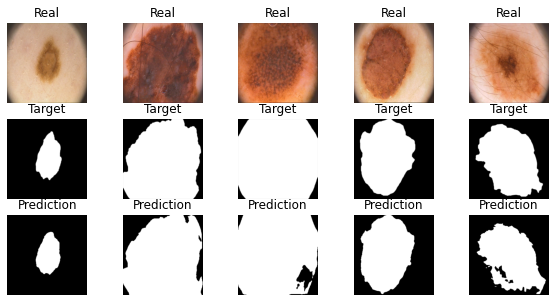

In [109]:
visualize(unet_model_focal)

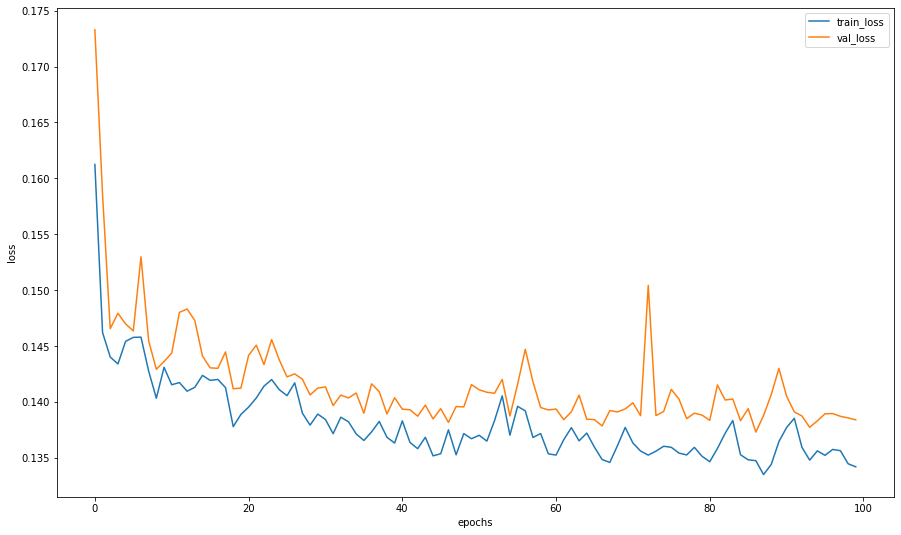

In [110]:
plot_loss(loss, val_loss)

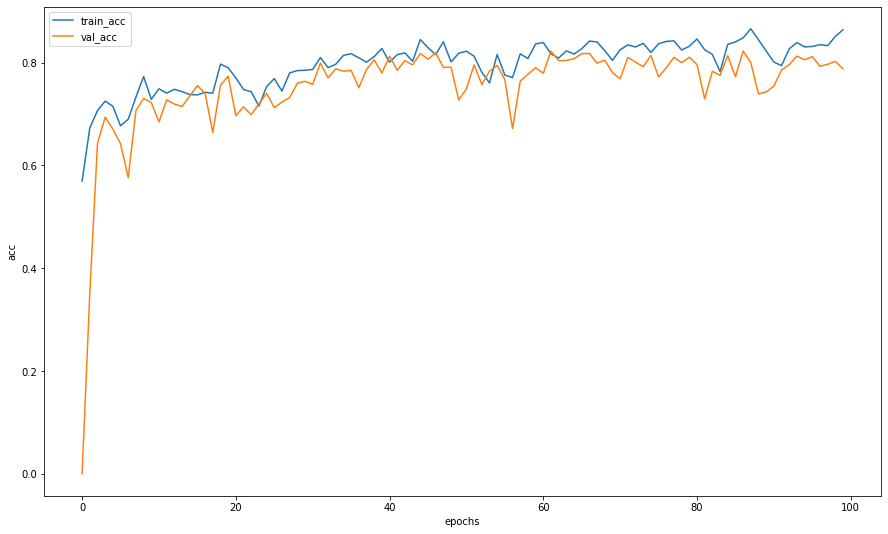

In [111]:
plot_metric(acc, val_acc)

Сохраним модель и ее результаты:

In [112]:
model_save_name = 'model_unet_focal.pth'
path = F"/content/gdrive/My Drive/DLS/nevus/{model_save_name}" 
torch.save(unet_model_focal.state_dict(), path)

In [113]:
np.save(F"/content/gdrive/My Drive/DLS/nevus/history_unet_focal.npy" , history_unet_focal)

In [114]:
del unet_model_focal

### 8.3. Unet с Lovasz loss.

In [115]:
unet_model_lovasz = UNet().to(DEVICE)

In [116]:
max_epochs = 100
optimizer = optim.Adam(unet_model_lovasz.parameters(), lr=3e-4)
torch.cuda.empty_cache()
history_unet_lovasz = train(unet_model_lovasz, optimizer, lovasz_hinge, max_epochs, train_dl, val_dl)

epoch:   1%|          | 1/100 [00:08<13:41,  8.30s/it]


Epoch 001 train_loss: 0.7036 val_loss 1.7073 train_acc 0.6796 val_acc 0.0000


epoch:   2%|▏         | 2/100 [00:17<13:46,  8.43s/it]


Epoch 002 train_loss: 0.6729 val_loss 1.0448 train_acc 0.6929 val_acc 0.4929


epoch:   3%|▎         | 3/100 [00:25<13:33,  8.39s/it]


Epoch 003 train_loss: 0.6018 val_loss 0.7411 train_acc 0.7226 val_acc 0.6360


epoch:   4%|▍         | 4/100 [00:33<13:17,  8.31s/it]


Epoch 004 train_loss: 0.5815 val_loss 0.5718 train_acc 0.7327 val_acc 0.7349


epoch:   5%|▌         | 5/100 [00:41<13:01,  8.23s/it]


Epoch 005 train_loss: 0.5312 val_loss 0.5460 train_acc 0.7572 val_acc 0.7380


epoch:   6%|▌         | 6/100 [00:49<12:46,  8.15s/it]


Epoch 006 train_loss: 0.4563 val_loss 0.7411 train_acc 0.7889 val_acc 0.6487


epoch:   7%|▋         | 7/100 [00:57<12:32,  8.09s/it]


Epoch 007 train_loss: 0.5523 val_loss 0.6076 train_acc 0.7480 val_acc 0.7090


epoch:   8%|▊         | 8/100 [01:05<12:19,  8.04s/it]


Epoch 008 train_loss: 0.5464 val_loss 0.5558 train_acc 0.7511 val_acc 0.7379


epoch:   9%|▉         | 9/100 [01:13<12:09,  8.02s/it]


Epoch 009 train_loss: 0.4750 val_loss 0.4951 train_acc 0.7786 val_acc 0.7661


epoch:  10%|█         | 10/100 [01:21<12:01,  8.01s/it]


Epoch 010 train_loss: 0.4587 val_loss 0.5835 train_acc 0.7902 val_acc 0.7188


epoch:  11%|█         | 11/100 [01:29<11:53,  8.02s/it]


Epoch 011 train_loss: 0.4351 val_loss 0.4723 train_acc 0.7992 val_acc 0.7756


epoch:  12%|█▏        | 12/100 [01:37<11:47,  8.04s/it]


Epoch 012 train_loss: 0.5086 val_loss 0.5029 train_acc 0.7631 val_acc 0.7591


epoch:  13%|█▎        | 13/100 [01:45<11:40,  8.05s/it]


Epoch 013 train_loss: 0.3932 val_loss 0.5207 train_acc 0.8196 val_acc 0.7568


epoch:  14%|█▍        | 14/100 [01:53<11:33,  8.06s/it]


Epoch 014 train_loss: 0.4360 val_loss 0.4381 train_acc 0.8018 val_acc 0.7954


epoch:  15%|█▌        | 15/100 [02:01<11:25,  8.06s/it]


Epoch 015 train_loss: 0.5081 val_loss 0.6237 train_acc 0.7612 val_acc 0.7022


epoch:  16%|█▌        | 16/100 [02:09<11:16,  8.06s/it]


Epoch 016 train_loss: 0.4685 val_loss 0.5021 train_acc 0.7861 val_acc 0.7764


epoch:  17%|█▋        | 17/100 [02:17<11:08,  8.05s/it]


Epoch 017 train_loss: 0.4260 val_loss 0.3939 train_acc 0.8040 val_acc 0.8157


epoch:  18%|█▊        | 18/100 [02:25<10:59,  8.04s/it]


Epoch 018 train_loss: 0.3817 val_loss 0.4571 train_acc 0.8225 val_acc 0.7759


epoch:  19%|█▉        | 19/100 [02:33<10:50,  8.03s/it]


Epoch 019 train_loss: 0.4766 val_loss 0.4263 train_acc 0.7837 val_acc 0.7979


epoch:  20%|██        | 20/100 [02:41<10:42,  8.04s/it]


Epoch 020 train_loss: 0.4826 val_loss 0.3833 train_acc 0.7706 val_acc 0.8189


epoch:  21%|██        | 21/100 [02:49<10:34,  8.03s/it]


Epoch 021 train_loss: 0.5111 val_loss 0.5949 train_acc 0.7653 val_acc 0.7256


epoch:  22%|██▏       | 22/100 [02:57<10:26,  8.04s/it]


Epoch 022 train_loss: 0.4436 val_loss 0.4199 train_acc 0.7956 val_acc 0.7950


epoch:  23%|██▎       | 23/100 [03:05<10:18,  8.04s/it]


Epoch 023 train_loss: 0.4162 val_loss 0.4296 train_acc 0.8095 val_acc 0.7872


epoch:  24%|██▍       | 24/100 [03:13<10:11,  8.04s/it]


Epoch 024 train_loss: 0.3981 val_loss 0.3570 train_acc 0.8173 val_acc 0.8336


epoch:  25%|██▌       | 25/100 [03:22<10:03,  8.04s/it]


Epoch 025 train_loss: 0.3868 val_loss 0.4358 train_acc 0.8234 val_acc 0.7876


epoch:  26%|██▌       | 26/100 [03:30<09:55,  8.05s/it]


Epoch 026 train_loss: 0.3486 val_loss 0.3994 train_acc 0.8356 val_acc 0.8093


epoch:  27%|██▋       | 27/100 [03:38<09:47,  8.05s/it]


Epoch 027 train_loss: 0.4974 val_loss 0.4626 train_acc 0.7715 val_acc 0.7712


epoch:  28%|██▊       | 28/100 [03:46<09:38,  8.04s/it]


Epoch 028 train_loss: 0.3992 val_loss 0.5110 train_acc 0.8129 val_acc 0.7465


epoch:  29%|██▉       | 29/100 [03:54<09:30,  8.04s/it]


Epoch 029 train_loss: 0.4373 val_loss 0.4525 train_acc 0.7991 val_acc 0.7970


epoch:  30%|███       | 30/100 [04:02<09:22,  8.04s/it]


Epoch 030 train_loss: 0.4498 val_loss 0.4224 train_acc 0.7940 val_acc 0.7953


epoch:  31%|███       | 31/100 [04:10<09:14,  8.03s/it]


Epoch 031 train_loss: 0.4085 val_loss 0.4233 train_acc 0.8130 val_acc 0.7909


epoch:  32%|███▏      | 32/100 [04:18<09:06,  8.03s/it]


Epoch 032 train_loss: 0.4288 val_loss 0.4102 train_acc 0.7993 val_acc 0.7966


epoch:  33%|███▎      | 33/100 [04:26<08:58,  8.03s/it]


Epoch 033 train_loss: 0.3860 val_loss 0.3923 train_acc 0.8225 val_acc 0.8194


epoch:  34%|███▍      | 34/100 [04:34<08:50,  8.04s/it]


Epoch 034 train_loss: 0.3930 val_loss 0.3798 train_acc 0.8189 val_acc 0.8148


epoch:  35%|███▌      | 35/100 [04:42<08:42,  8.04s/it]


Epoch 035 train_loss: 0.4601 val_loss 0.4423 train_acc 0.7818 val_acc 0.7953


epoch:  36%|███▌      | 36/100 [04:50<08:34,  8.04s/it]


Epoch 036 train_loss: 0.3806 val_loss 0.4799 train_acc 0.8237 val_acc 0.7567


epoch:  37%|███▋      | 37/100 [04:58<08:26,  8.04s/it]


Epoch 037 train_loss: 0.4016 val_loss 0.3607 train_acc 0.8120 val_acc 0.8286


epoch:  38%|███▊      | 38/100 [05:06<08:18,  8.04s/it]


Epoch 038 train_loss: 0.3824 val_loss 0.3710 train_acc 0.8230 val_acc 0.8144


epoch:  39%|███▉      | 39/100 [05:14<08:10,  8.04s/it]


Epoch 039 train_loss: 0.3548 val_loss 0.4283 train_acc 0.8357 val_acc 0.7876


epoch:  40%|████      | 40/100 [05:22<08:02,  8.04s/it]


Epoch 040 train_loss: 0.3737 val_loss 0.3462 train_acc 0.8251 val_acc 0.8358


epoch:  41%|████      | 41/100 [05:30<07:54,  8.04s/it]


Epoch 041 train_loss: 0.4059 val_loss 0.4649 train_acc 0.8147 val_acc 0.7864


epoch:  42%|████▏     | 42/100 [05:38<07:46,  8.04s/it]


Epoch 042 train_loss: 0.3590 val_loss 0.3695 train_acc 0.8331 val_acc 0.8251


epoch:  43%|████▎     | 43/100 [05:46<07:38,  8.04s/it]


Epoch 043 train_loss: 0.3692 val_loss 0.3534 train_acc 0.8269 val_acc 0.8267


epoch:  44%|████▍     | 44/100 [05:54<07:30,  8.04s/it]


Epoch 044 train_loss: 0.3648 val_loss 0.3727 train_acc 0.8310 val_acc 0.8181


epoch:  45%|████▌     | 45/100 [06:02<07:22,  8.04s/it]


Epoch 045 train_loss: 0.3546 val_loss 0.4157 train_acc 0.8343 val_acc 0.8035


epoch:  46%|████▌     | 46/100 [06:10<07:14,  8.04s/it]


Epoch 046 train_loss: 0.3631 val_loss 0.3753 train_acc 0.8320 val_acc 0.8244


epoch:  47%|████▋     | 47/100 [06:18<07:06,  8.04s/it]


Epoch 047 train_loss: 0.3785 val_loss 0.3562 train_acc 0.8182 val_acc 0.8291


epoch:  48%|████▊     | 48/100 [06:26<06:57,  8.04s/it]


Epoch 048 train_loss: 0.3753 val_loss 0.3865 train_acc 0.8322 val_acc 0.8201


epoch:  49%|████▉     | 49/100 [06:34<06:50,  8.04s/it]


Epoch 049 train_loss: 0.3906 val_loss 0.3356 train_acc 0.8187 val_acc 0.8361


epoch:  50%|█████     | 50/100 [06:42<06:41,  8.04s/it]


Epoch 050 train_loss: 0.4254 val_loss 0.3739 train_acc 0.7993 val_acc 0.8225


epoch:  51%|█████     | 51/100 [06:51<06:33,  8.04s/it]


Epoch 051 train_loss: 0.3236 val_loss 0.3979 train_acc 0.8497 val_acc 0.8084


epoch:  52%|█████▏    | 52/100 [06:59<06:25,  8.04s/it]


Epoch 052 train_loss: 0.3155 val_loss 0.3305 train_acc 0.8525 val_acc 0.8392


epoch:  53%|█████▎    | 53/100 [07:07<06:17,  8.04s/it]


Epoch 053 train_loss: 0.3005 val_loss 0.3315 train_acc 0.8591 val_acc 0.8425


epoch:  54%|█████▍    | 54/100 [07:15<06:09,  8.04s/it]


Epoch 054 train_loss: 0.2984 val_loss 0.3915 train_acc 0.8603 val_acc 0.8050


epoch:  55%|█████▌    | 55/100 [07:23<06:01,  8.04s/it]


Epoch 055 train_loss: 0.3079 val_loss 0.3536 train_acc 0.8580 val_acc 0.8258


epoch:  56%|█████▌    | 56/100 [07:31<05:53,  8.04s/it]


Epoch 056 train_loss: 0.3503 val_loss 0.3212 train_acc 0.8359 val_acc 0.8494


epoch:  57%|█████▋    | 57/100 [07:39<05:45,  8.04s/it]


Epoch 057 train_loss: 0.3129 val_loss 0.3225 train_acc 0.8540 val_acc 0.8438


epoch:  58%|█████▊    | 58/100 [07:47<05:37,  8.05s/it]


Epoch 058 train_loss: 0.3146 val_loss 0.2991 train_acc 0.8536 val_acc 0.8546


epoch:  59%|█████▉    | 59/100 [07:55<05:30,  8.05s/it]


Epoch 059 train_loss: 0.3198 val_loss 0.3232 train_acc 0.8502 val_acc 0.8428


epoch:  60%|██████    | 60/100 [08:03<05:22,  8.05s/it]


Epoch 060 train_loss: 0.2954 val_loss 0.3703 train_acc 0.8622 val_acc 0.8210


epoch:  61%|██████    | 61/100 [08:11<05:13,  8.05s/it]


Epoch 061 train_loss: 0.2868 val_loss 0.3467 train_acc 0.8639 val_acc 0.8392


epoch:  62%|██████▏   | 62/100 [08:19<05:05,  8.05s/it]


Epoch 062 train_loss: 0.2945 val_loss 0.3198 train_acc 0.8602 val_acc 0.8448


epoch:  63%|██████▎   | 63/100 [08:27<04:57,  8.05s/it]


Epoch 063 train_loss: 0.3579 val_loss 0.3852 train_acc 0.8356 val_acc 0.8034


epoch:  64%|██████▍   | 64/100 [08:35<04:49,  8.05s/it]


Epoch 064 train_loss: 0.2903 val_loss 0.3000 train_acc 0.8633 val_acc 0.8543


epoch:  65%|██████▌   | 65/100 [08:43<04:41,  8.05s/it]


Epoch 065 train_loss: 0.2675 val_loss 0.3232 train_acc 0.8749 val_acc 0.8419


epoch:  66%|██████▌   | 66/100 [08:51<04:33,  8.05s/it]


Epoch 066 train_loss: 0.2798 val_loss 0.3104 train_acc 0.8673 val_acc 0.8537


epoch:  67%|██████▋   | 67/100 [08:59<04:25,  8.05s/it]


Epoch 067 train_loss: 0.2893 val_loss 0.3389 train_acc 0.8654 val_acc 0.8439


epoch:  68%|██████▊   | 68/100 [09:07<04:17,  8.05s/it]


Epoch 068 train_loss: 0.2649 val_loss 0.3510 train_acc 0.8742 val_acc 0.8442


epoch:  69%|██████▉   | 69/100 [09:15<04:09,  8.05s/it]


Epoch 069 train_loss: 0.3014 val_loss 0.3213 train_acc 0.8575 val_acc 0.8478


epoch:  70%|███████   | 70/100 [09:23<04:01,  8.05s/it]


Epoch 070 train_loss: 0.2926 val_loss 0.3957 train_acc 0.8612 val_acc 0.8037


epoch:  71%|███████   | 71/100 [09:32<03:53,  8.05s/it]


Epoch 071 train_loss: 0.2851 val_loss 0.3591 train_acc 0.8664 val_acc 0.8203


epoch:  72%|███████▏  | 72/100 [09:40<03:45,  8.05s/it]


Epoch 072 train_loss: 0.3077 val_loss 0.3246 train_acc 0.8542 val_acc 0.8385


epoch:  73%|███████▎  | 73/100 [09:48<03:37,  8.05s/it]


Epoch 073 train_loss: 0.3079 val_loss 0.3468 train_acc 0.8567 val_acc 0.8274


epoch:  74%|███████▍  | 74/100 [09:56<03:29,  8.04s/it]


Epoch 074 train_loss: 0.2681 val_loss 0.2653 train_acc 0.8735 val_acc 0.8740


epoch:  75%|███████▌  | 75/100 [10:04<03:20,  8.04s/it]


Epoch 075 train_loss: 0.2589 val_loss 0.3451 train_acc 0.8787 val_acc 0.8240


epoch:  76%|███████▌  | 76/100 [10:12<03:12,  8.04s/it]


Epoch 076 train_loss: 0.2749 val_loss 0.2920 train_acc 0.8688 val_acc 0.8682


epoch:  77%|███████▋  | 77/100 [10:20<03:04,  8.04s/it]


Epoch 077 train_loss: 0.2512 val_loss 0.3144 train_acc 0.8797 val_acc 0.8473


epoch:  78%|███████▊  | 78/100 [10:28<02:56,  8.04s/it]


Epoch 078 train_loss: 0.2453 val_loss 0.3024 train_acc 0.8821 val_acc 0.8547


epoch:  79%|███████▉  | 79/100 [10:36<02:48,  8.04s/it]


Epoch 079 train_loss: 0.2159 val_loss 0.3022 train_acc 0.8984 val_acc 0.8550


epoch:  80%|████████  | 80/100 [10:44<02:40,  8.04s/it]


Epoch 080 train_loss: 0.2152 val_loss 0.2739 train_acc 0.8989 val_acc 0.8709


epoch:  81%|████████  | 81/100 [10:52<02:32,  8.04s/it]


Epoch 081 train_loss: 0.2812 val_loss 0.3039 train_acc 0.8694 val_acc 0.8581


epoch:  82%|████████▏ | 82/100 [11:00<02:24,  8.04s/it]


Epoch 082 train_loss: 0.3033 val_loss 0.3289 train_acc 0.8570 val_acc 0.8372


epoch:  83%|████████▎ | 83/100 [11:08<02:16,  8.04s/it]


Epoch 083 train_loss: 0.2867 val_loss 0.3784 train_acc 0.8642 val_acc 0.8094


epoch:  84%|████████▍ | 84/100 [11:16<02:08,  8.04s/it]


Epoch 084 train_loss: 0.2640 val_loss 0.3200 train_acc 0.8776 val_acc 0.8486


epoch:  85%|████████▌ | 85/100 [11:24<02:00,  8.04s/it]


Epoch 085 train_loss: 0.2164 val_loss 0.3264 train_acc 0.8961 val_acc 0.8474


epoch:  86%|████████▌ | 86/100 [11:32<01:52,  8.04s/it]


Epoch 086 train_loss: 0.2360 val_loss 0.2920 train_acc 0.8899 val_acc 0.8597


epoch:  87%|████████▋ | 87/100 [11:40<01:44,  8.04s/it]


Epoch 087 train_loss: 0.2081 val_loss 0.2761 train_acc 0.8996 val_acc 0.8677


epoch:  88%|████████▊ | 88/100 [11:48<01:36,  8.04s/it]


Epoch 088 train_loss: 0.2328 val_loss 0.2968 train_acc 0.8877 val_acc 0.8558


epoch:  89%|████████▉ | 89/100 [11:56<01:28,  8.04s/it]


Epoch 089 train_loss: 0.2221 val_loss 0.3053 train_acc 0.8957 val_acc 0.8458


epoch:  90%|█████████ | 90/100 [12:04<01:20,  8.04s/it]


Epoch 090 train_loss: 0.2075 val_loss 0.3046 train_acc 0.9008 val_acc 0.8584


epoch:  91%|█████████ | 91/100 [12:12<01:12,  8.04s/it]


Epoch 091 train_loss: 0.2132 val_loss 0.3025 train_acc 0.8983 val_acc 0.8530


epoch:  92%|█████████▏| 92/100 [12:20<01:04,  8.04s/it]


Epoch 092 train_loss: 0.2258 val_loss 0.4099 train_acc 0.8931 val_acc 0.7979


epoch:  93%|█████████▎| 93/100 [12:28<00:56,  8.04s/it]


Epoch 093 train_loss: 0.3225 val_loss 0.3065 train_acc 0.8476 val_acc 0.8503


epoch:  94%|█████████▍| 94/100 [12:36<00:48,  8.04s/it]


Epoch 094 train_loss: 0.2145 val_loss 0.3241 train_acc 0.8978 val_acc 0.8562


epoch:  95%|█████████▌| 95/100 [12:44<00:40,  8.04s/it]


Epoch 095 train_loss: 0.2154 val_loss 0.3063 train_acc 0.8970 val_acc 0.8445


epoch:  96%|█████████▌| 96/100 [12:53<00:32,  8.04s/it]


Epoch 096 train_loss: 0.2131 val_loss 0.2748 train_acc 0.8999 val_acc 0.8663


epoch:  97%|█████████▋| 97/100 [13:01<00:24,  8.04s/it]


Epoch 097 train_loss: 0.2193 val_loss 0.2784 train_acc 0.8950 val_acc 0.8654


epoch:  98%|█████████▊| 98/100 [13:09<00:16,  8.04s/it]


Epoch 098 train_loss: 0.2161 val_loss 0.2925 train_acc 0.8948 val_acc 0.8511


epoch:  99%|█████████▉| 99/100 [13:17<00:08,  8.04s/it]


Epoch 099 train_loss: 0.2156 val_loss 0.2869 train_acc 0.8990 val_acc 0.8579


epoch: 100%|██████████| 100/100 [13:25<00:00,  8.05s/it]


Epoch 100 train_loss: 0.2637 val_loss 0.3714 train_acc 0.8758 val_acc 0.8295


Визуализируем результат:

In [117]:
loss, acc, val_loss, val_acc = zip(*history_unet_lovasz)

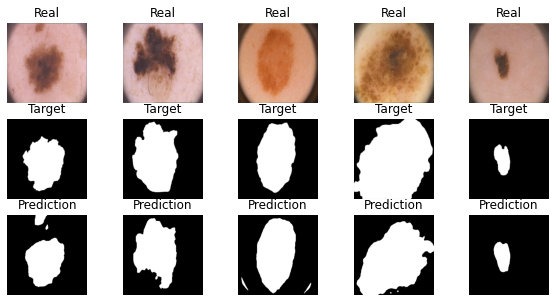

In [118]:
visualize(unet_model_lovasz)

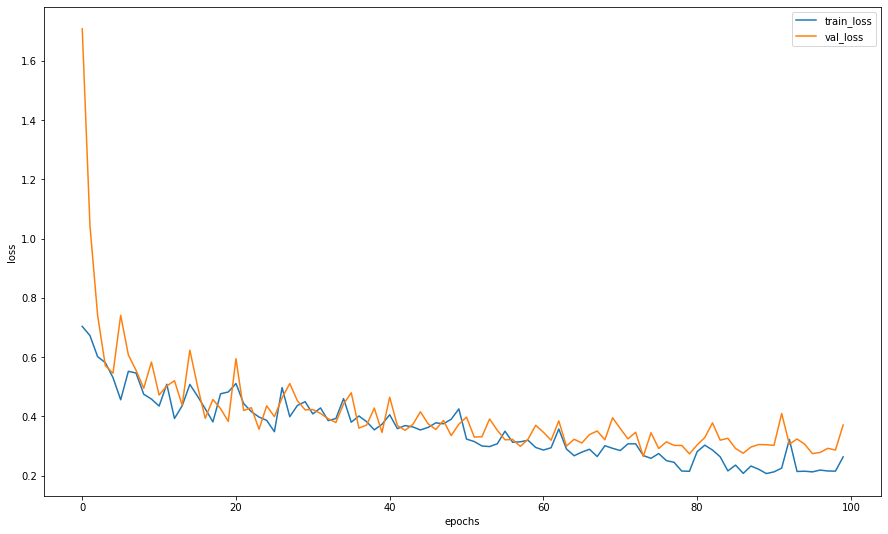

In [119]:
plot_loss(loss, val_loss)

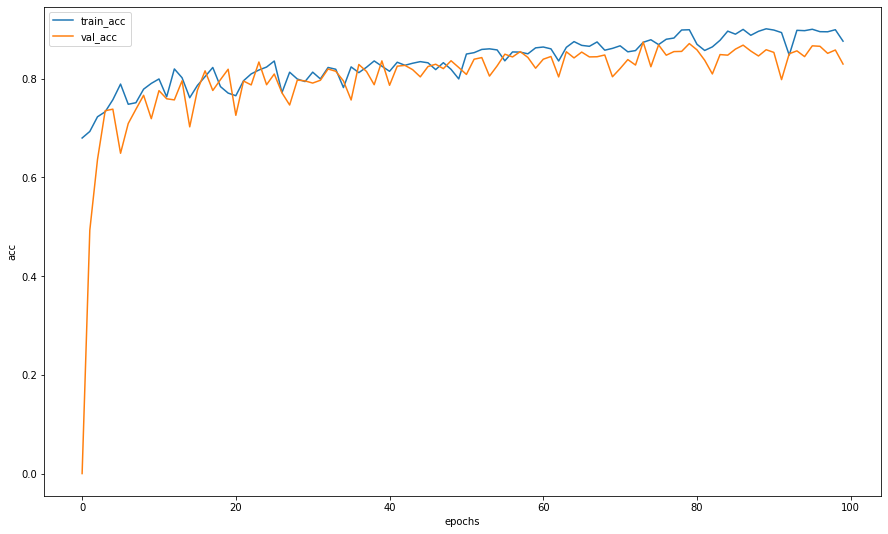

In [120]:
plot_metric(acc, val_acc)

Сохраним модель и ее результаты:

In [121]:
model_save_name = 'model_unet_lovasz.pth'
path = F"/content/gdrive/My Drive/DLS/nevus/{model_save_name}" 
torch.save(unet_model_lovasz.state_dict(), path)

In [122]:
np.save(F"/content/gdrive/My Drive/DLS/nevus/history_unet_lovasz.npy" , history_unet_lovasz)

In [123]:
del unet_model_lovasz

## 9. U-Net2.

Заменим слои MaxPool2d и Upsample на Conv2d со stride=2 и ConvTranspose2d со stride=2 соответственно.

In [47]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
                                nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(64),
                                nn.ReLU(),
                                nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(64),
                                nn.ReLU()) 
        self.pool0 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
                                nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(128),
                                nn.ReLU(),
                                nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(128),
                                nn.ReLU())
        self.pool1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
                                nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(256),
                                nn.ReLU(),
                                nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(256),
                                nn.ReLU())
        self.pool2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
                                nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(512),
                                nn.ReLU(),
                                nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(512),
                                nn.ReLU())
        self.pool3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
                                  nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1),
                                  nn.BatchNorm2d(1024),
                                  nn.ReLU(),
                                  nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1),
                                  nn.BatchNorm2d(1024),
                                  nn.ReLU())

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=1024, out_channels=1024, kernel_size=2, stride=2)  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
                                nn.Conv2d(in_channels=1024 + 512, out_channels=512, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(512),
                                nn.ReLU(),
                                nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(512),
                                nn.ReLU())
        self.upsample1 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2)  # 32 -> 64
        self.dec_conv1 = nn.Sequential(
                                nn.Conv2d(in_channels=512 + 256, out_channels=256, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(256),
                                nn.ReLU(),
                                nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(256),
                                nn.ReLU())
        self.upsample2 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2)   # 64 -> 128
        self.dec_conv2 = nn.Sequential(
                                nn.Conv2d(in_channels=256 + 128, out_channels=128, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(128),
                                nn.ReLU(),
                                nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(128),
                                nn.ReLU())
        self.upsample3 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
                                nn.Conv2d(in_channels=128 + 64, out_channels=64, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(64),
                                nn.ReLU(),
                                nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1))

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        pool0 = self.pool0(e0)
        e1 = self.enc_conv1(pool0)
        pool1 = self.pool1(e1)
        e2 = self.enc_conv2(pool1)
        pool2 = self.pool2(e2)
        e3 = self.enc_conv3(pool2)
        pool3 = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(pool3)

        # decoder
        d0 = self.upsample0(b)
        d0 = torch.cat([d0, e3], dim=1)
        d0 = self.dec_conv0(d0)
        d1 = self.upsample1(d0)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec_conv1(d1)
        d2 = self.upsample2(d1)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec_conv2(d2)
        d3 = self.upsample3(d2)
        d3 = torch.cat([d3, e0], dim=1)
        d3 = self.dec_conv3(d3) # no activation
        return d3


In [49]:
unet2_model_bce = UNet2().to(DEVICE)

In [50]:
max_epochs = 100
optimizer = optim.Adam(unet2_model_bce.parameters(), lr=3e-4)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
torch.cuda.empty_cache()
history_unet2_bce = train(unet2_model_bce, optimizer, bce_loss, max_epochs, train_dl, val_dl)

epoch:   1%|          | 1/100 [00:08<14:27,  8.76s/it]


Epoch 001 train_loss: 0.4241 val_loss 0.5404 train_acc 0.6372 val_acc 0.1416


epoch:   2%|▏         | 2/100 [00:17<14:17,  8.75s/it]


Epoch 002 train_loss: 0.3551 val_loss 0.4225 train_acc 0.6887 val_acc 0.5782


epoch:   3%|▎         | 3/100 [00:26<14:11,  8.78s/it]


Epoch 003 train_loss: 0.3002 val_loss 0.3080 train_acc 0.7585 val_acc 0.7163


epoch:   4%|▍         | 4/100 [00:35<14:06,  8.82s/it]


Epoch 004 train_loss: 0.3102 val_loss 0.4198 train_acc 0.7300 val_acc 0.6184


epoch:   5%|▌         | 5/100 [00:44<14:03,  8.88s/it]


Epoch 005 train_loss: 0.2865 val_loss 0.2831 train_acc 0.7353 val_acc 0.7308


epoch:   6%|▌         | 6/100 [00:53<14:02,  8.97s/it]


Epoch 006 train_loss: 0.2814 val_loss 0.2853 train_acc 0.7426 val_acc 0.7261


epoch:   7%|▋         | 7/100 [01:02<14:02,  9.06s/it]


Epoch 007 train_loss: 0.3065 val_loss 0.2935 train_acc 0.7044 val_acc 0.6689


epoch:   8%|▊         | 8/100 [01:11<13:57,  9.10s/it]


Epoch 008 train_loss: 0.2710 val_loss 0.2584 train_acc 0.7377 val_acc 0.7503


epoch:   9%|▉         | 9/100 [01:20<13:47,  9.09s/it]


Epoch 009 train_loss: 0.2641 val_loss 0.2450 train_acc 0.7377 val_acc 0.7066


epoch:  10%|█         | 10/100 [01:30<13:36,  9.07s/it]


Epoch 010 train_loss: 0.2458 val_loss 0.2585 train_acc 0.7658 val_acc 0.7559


epoch:  11%|█         | 11/100 [01:39<13:25,  9.05s/it]


Epoch 011 train_loss: 0.2468 val_loss 0.2259 train_acc 0.7499 val_acc 0.7516


epoch:  12%|█▏        | 12/100 [01:47<13:14,  9.02s/it]


Epoch 012 train_loss: 0.2610 val_loss 0.2493 train_acc 0.7415 val_acc 0.7268


epoch:  13%|█▎        | 13/100 [01:56<13:03,  9.01s/it]


Epoch 013 train_loss: 0.2614 val_loss 0.2308 train_acc 0.7465 val_acc 0.7214


epoch:  14%|█▍        | 14/100 [02:05<12:55,  9.02s/it]


Epoch 014 train_loss: 0.2239 val_loss 0.2243 train_acc 0.7739 val_acc 0.7690


epoch:  15%|█▌        | 15/100 [02:15<12:47,  9.03s/it]


Epoch 015 train_loss: 0.2486 val_loss 0.2228 train_acc 0.7366 val_acc 0.7486


epoch:  16%|█▌        | 16/100 [02:24<12:38,  9.04s/it]


Epoch 016 train_loss: 0.2123 val_loss 0.2233 train_acc 0.7967 val_acc 0.7601


epoch:  17%|█▋        | 17/100 [02:33<12:30,  9.04s/it]


Epoch 017 train_loss: 0.2417 val_loss 0.2412 train_acc 0.7361 val_acc 0.7028


epoch:  18%|█▊        | 18/100 [02:42<12:21,  9.05s/it]


Epoch 018 train_loss: 0.2278 val_loss 0.2374 train_acc 0.7597 val_acc 0.7476


epoch:  19%|█▉        | 19/100 [02:51<12:12,  9.05s/it]


Epoch 019 train_loss: 0.2408 val_loss 0.2208 train_acc 0.7519 val_acc 0.7559


epoch:  20%|██        | 20/100 [03:00<12:03,  9.04s/it]


Epoch 020 train_loss: 0.2297 val_loss 0.2369 train_acc 0.7618 val_acc 0.7602


epoch:  21%|██        | 21/100 [03:09<11:54,  9.04s/it]


Epoch 021 train_loss: 0.2242 val_loss 0.3412 train_acc 0.7616 val_acc 0.7069


epoch:  22%|██▏       | 22/100 [03:18<11:44,  9.03s/it]


Epoch 022 train_loss: 0.2197 val_loss 0.2353 train_acc 0.7645 val_acc 0.7504


epoch:  23%|██▎       | 23/100 [03:27<11:35,  9.03s/it]


Epoch 023 train_loss: 0.2127 val_loss 0.2021 train_acc 0.7729 val_acc 0.7597


epoch:  24%|██▍       | 24/100 [03:36<11:26,  9.03s/it]


Epoch 024 train_loss: 0.2419 val_loss 0.2160 train_acc 0.7336 val_acc 0.7653


epoch:  25%|██▌       | 25/100 [03:45<11:17,  9.03s/it]


Epoch 025 train_loss: 0.2148 val_loss 0.1916 train_acc 0.7804 val_acc 0.7798


epoch:  26%|██▌       | 26/100 [03:54<11:08,  9.04s/it]


Epoch 026 train_loss: 0.1877 val_loss 0.2086 train_acc 0.8131 val_acc 0.8076


epoch:  27%|██▋       | 27/100 [04:03<10:59,  9.04s/it]


Epoch 027 train_loss: 0.2037 val_loss 0.1982 train_acc 0.7822 val_acc 0.7607


epoch:  28%|██▊       | 28/100 [04:12<10:50,  9.04s/it]


Epoch 028 train_loss: 0.1967 val_loss 0.1921 train_acc 0.7846 val_acc 0.7840


epoch:  29%|██▉       | 29/100 [04:21<10:41,  9.04s/it]


Epoch 029 train_loss: 0.2150 val_loss 0.2000 train_acc 0.7673 val_acc 0.7955


epoch:  30%|███       | 30/100 [04:30<10:32,  9.04s/it]


Epoch 030 train_loss: 0.2154 val_loss 0.1954 train_acc 0.7713 val_acc 0.7845


epoch:  31%|███       | 31/100 [04:39<10:23,  9.04s/it]


Epoch 031 train_loss: 0.1865 val_loss 0.1889 train_acc 0.8076 val_acc 0.8062


epoch:  32%|███▏      | 32/100 [04:48<10:14,  9.04s/it]


Epoch 032 train_loss: 0.1831 val_loss 0.1828 train_acc 0.8084 val_acc 0.7846


epoch:  33%|███▎      | 33/100 [04:57<10:05,  9.04s/it]


Epoch 033 train_loss: 0.2009 val_loss 0.1740 train_acc 0.7800 val_acc 0.8201


epoch:  34%|███▍      | 34/100 [05:06<09:56,  9.04s/it]


Epoch 034 train_loss: 0.1918 val_loss 0.1832 train_acc 0.7968 val_acc 0.8021


epoch:  35%|███▌      | 35/100 [05:15<09:47,  9.04s/it]


Epoch 035 train_loss: 0.2176 val_loss 0.3964 train_acc 0.7691 val_acc 0.6416


epoch:  36%|███▌      | 36/100 [05:24<09:38,  9.04s/it]


Epoch 036 train_loss: 0.2189 val_loss 0.2501 train_acc 0.7633 val_acc 0.7645


epoch:  37%|███▋      | 37/100 [05:33<09:29,  9.04s/it]


Epoch 037 train_loss: 0.1737 val_loss 0.1859 train_acc 0.8207 val_acc 0.7875


epoch:  38%|███▊      | 38/100 [05:42<09:20,  9.04s/it]


Epoch 038 train_loss: 0.2103 val_loss 0.2200 train_acc 0.7844 val_acc 0.7853


epoch:  39%|███▉      | 39/100 [05:52<09:11,  9.04s/it]


Epoch 039 train_loss: 0.2053 val_loss 0.1904 train_acc 0.8082 val_acc 0.7836


epoch:  40%|████      | 40/100 [06:01<09:02,  9.04s/it]


Epoch 040 train_loss: 0.1716 val_loss 0.1834 train_acc 0.8144 val_acc 0.7929


epoch:  41%|████      | 41/100 [06:10<08:53,  9.04s/it]


Epoch 041 train_loss: 0.1860 val_loss 0.1719 train_acc 0.8120 val_acc 0.8136


epoch:  42%|████▏     | 42/100 [06:19<08:44,  9.04s/it]


Epoch 042 train_loss: 0.1797 val_loss 0.1626 train_acc 0.8159 val_acc 0.8310


epoch:  43%|████▎     | 43/100 [06:28<08:35,  9.04s/it]


Epoch 043 train_loss: 0.1780 val_loss 0.1707 train_acc 0.8091 val_acc 0.8000


epoch:  44%|████▍     | 44/100 [06:37<08:26,  9.04s/it]


Epoch 044 train_loss: 0.1653 val_loss 0.1620 train_acc 0.8218 val_acc 0.8154


epoch:  45%|████▌     | 45/100 [06:46<08:17,  9.04s/it]


Epoch 045 train_loss: 0.1644 val_loss 0.2954 train_acc 0.8299 val_acc 0.7476


epoch:  46%|████▌     | 46/100 [06:55<08:08,  9.04s/it]


Epoch 046 train_loss: 0.1698 val_loss 0.1757 train_acc 0.8181 val_acc 0.7980


epoch:  47%|████▋     | 47/100 [07:04<07:59,  9.04s/it]


Epoch 047 train_loss: 0.1662 val_loss 0.1672 train_acc 0.8303 val_acc 0.8151


epoch:  48%|████▊     | 48/100 [07:13<07:50,  9.04s/it]


Epoch 048 train_loss: 0.1674 val_loss 0.1574 train_acc 0.8326 val_acc 0.8232


epoch:  49%|████▉     | 49/100 [07:22<07:41,  9.04s/it]


Epoch 049 train_loss: 0.1682 val_loss 0.1513 train_acc 0.8363 val_acc 0.8390


epoch:  50%|█████     | 50/100 [07:31<07:32,  9.04s/it]


Epoch 050 train_loss: 0.1476 val_loss 0.1504 train_acc 0.8504 val_acc 0.8334


epoch:  51%|█████     | 51/100 [07:40<07:22,  9.04s/it]


Epoch 051 train_loss: 0.1469 val_loss 0.1526 train_acc 0.8420 val_acc 0.8236


epoch:  52%|█████▏    | 52/100 [07:49<07:14,  9.04s/it]


Epoch 052 train_loss: 0.1696 val_loss 0.2254 train_acc 0.8207 val_acc 0.7748


epoch:  53%|█████▎    | 53/100 [07:58<07:04,  9.04s/it]


Epoch 053 train_loss: 0.1539 val_loss 0.1634 train_acc 0.8410 val_acc 0.8295


epoch:  54%|█████▍    | 54/100 [08:07<06:55,  9.04s/it]


Epoch 054 train_loss: 0.1451 val_loss 0.1423 train_acc 0.8471 val_acc 0.8518


epoch:  55%|█████▌    | 55/100 [08:16<06:47,  9.05s/it]


Epoch 055 train_loss: 0.1536 val_loss 0.1491 train_acc 0.8522 val_acc 0.8414


epoch:  56%|█████▌    | 56/100 [08:25<06:37,  9.04s/it]


Epoch 056 train_loss: 0.1991 val_loss 0.1702 train_acc 0.7843 val_acc 0.8255


epoch:  57%|█████▋    | 57/100 [08:34<06:28,  9.04s/it]


Epoch 057 train_loss: 0.1428 val_loss 0.1517 train_acc 0.8566 val_acc 0.8377


epoch:  58%|█████▊    | 58/100 [08:43<06:19,  9.04s/it]


Epoch 058 train_loss: 0.1671 val_loss 0.1520 train_acc 0.8409 val_acc 0.8315


epoch:  59%|█████▉    | 59/100 [08:52<06:10,  9.04s/it]


Epoch 059 train_loss: 0.1450 val_loss 0.1652 train_acc 0.8570 val_acc 0.8153


epoch:  60%|██████    | 60/100 [09:01<06:01,  9.04s/it]


Epoch 060 train_loss: 0.1750 val_loss 0.1546 train_acc 0.8426 val_acc 0.8326


epoch:  61%|██████    | 61/100 [09:10<05:52,  9.04s/it]


Epoch 061 train_loss: 0.1507 val_loss 0.1418 train_acc 0.8449 val_acc 0.8434


epoch:  62%|██████▏   | 62/100 [09:19<05:43,  9.04s/it]


Epoch 062 train_loss: 0.1265 val_loss 0.2275 train_acc 0.8666 val_acc 0.7941


epoch:  63%|██████▎   | 63/100 [09:29<05:34,  9.05s/it]


Epoch 063 train_loss: 0.1440 val_loss 0.1559 train_acc 0.8505 val_acc 0.8218


epoch:  64%|██████▍   | 64/100 [09:38<05:25,  9.04s/it]


Epoch 064 train_loss: 0.1234 val_loss 0.1505 train_acc 0.8726 val_acc 0.8203


epoch:  65%|██████▌   | 65/100 [09:47<05:16,  9.04s/it]


Epoch 065 train_loss: 0.1310 val_loss 0.1758 train_acc 0.8641 val_acc 0.8321


epoch:  66%|██████▌   | 66/100 [09:56<05:07,  9.04s/it]


Epoch 066 train_loss: 0.1385 val_loss 0.1622 train_acc 0.8643 val_acc 0.8260


epoch:  67%|██████▋   | 67/100 [10:05<04:58,  9.04s/it]


Epoch 067 train_loss: 0.1147 val_loss 0.1418 train_acc 0.8801 val_acc 0.8386


epoch:  68%|██████▊   | 68/100 [10:14<04:49,  9.04s/it]


Epoch 068 train_loss: 0.1293 val_loss 0.1601 train_acc 0.8644 val_acc 0.8363


epoch:  69%|██████▉   | 69/100 [10:23<04:40,  9.04s/it]


Epoch 069 train_loss: 0.1269 val_loss 0.1522 train_acc 0.8684 val_acc 0.8205


epoch:  70%|███████   | 70/100 [10:32<04:31,  9.04s/it]


Epoch 070 train_loss: 0.1314 val_loss 0.1601 train_acc 0.8634 val_acc 0.8228


epoch:  71%|███████   | 71/100 [10:41<04:22,  9.04s/it]


Epoch 071 train_loss: 0.1456 val_loss 0.1457 train_acc 0.8545 val_acc 0.8517


epoch:  72%|███████▏  | 72/100 [10:50<04:13,  9.04s/it]


Epoch 072 train_loss: 0.1206 val_loss 0.1428 train_acc 0.8744 val_acc 0.8515


epoch:  73%|███████▎  | 73/100 [10:59<04:04,  9.04s/it]


Epoch 073 train_loss: 0.1039 val_loss 0.1336 train_acc 0.8964 val_acc 0.8480


epoch:  74%|███████▍  | 74/100 [11:08<03:55,  9.04s/it]


Epoch 074 train_loss: 0.1175 val_loss 0.1595 train_acc 0.8699 val_acc 0.8384


epoch:  75%|███████▌  | 75/100 [11:17<03:46,  9.04s/it]


Epoch 075 train_loss: 0.1106 val_loss 0.1661 train_acc 0.8865 val_acc 0.8378


epoch:  76%|███████▌  | 76/100 [11:26<03:36,  9.04s/it]


Epoch 076 train_loss: 0.1131 val_loss 0.1431 train_acc 0.8839 val_acc 0.8470


epoch:  77%|███████▋  | 77/100 [11:35<03:28,  9.04s/it]


Epoch 077 train_loss: 0.1131 val_loss 0.1332 train_acc 0.8799 val_acc 0.8474


epoch:  78%|███████▊  | 78/100 [11:44<03:19,  9.05s/it]


Epoch 078 train_loss: 0.0975 val_loss 0.1543 train_acc 0.8983 val_acc 0.8493


epoch:  79%|███████▉  | 79/100 [11:53<03:09,  9.04s/it]


Epoch 079 train_loss: 0.1017 val_loss 0.1287 train_acc 0.8880 val_acc 0.8591


epoch:  80%|████████  | 80/100 [12:02<03:00,  9.04s/it]


Epoch 080 train_loss: 0.1442 val_loss 0.2013 train_acc 0.8360 val_acc 0.8037


epoch:  81%|████████  | 81/100 [12:11<02:51,  9.04s/it]


Epoch 081 train_loss: 0.1460 val_loss 0.1578 train_acc 0.8463 val_acc 0.8499


epoch:  82%|████████▏ | 82/100 [12:20<02:42,  9.04s/it]


Epoch 082 train_loss: 0.1270 val_loss 0.1576 train_acc 0.8676 val_acc 0.8315


epoch:  83%|████████▎ | 83/100 [12:29<02:33,  9.04s/it]


Epoch 083 train_loss: 0.1215 val_loss 0.1556 train_acc 0.8679 val_acc 0.8431


epoch:  84%|████████▍ | 84/100 [12:38<02:24,  9.04s/it]


Epoch 084 train_loss: 0.1096 val_loss 0.1352 train_acc 0.8808 val_acc 0.8556


epoch:  85%|████████▌ | 85/100 [12:47<02:15,  9.03s/it]


Epoch 085 train_loss: 0.0957 val_loss 0.1451 train_acc 0.9001 val_acc 0.8406


epoch:  86%|████████▌ | 86/100 [12:56<02:06,  9.03s/it]


Epoch 086 train_loss: 0.0898 val_loss 0.1316 train_acc 0.9022 val_acc 0.8579


epoch:  87%|████████▋ | 87/100 [13:05<01:57,  9.03s/it]


Epoch 087 train_loss: 0.0939 val_loss 0.1281 train_acc 0.9016 val_acc 0.8613


epoch:  88%|████████▊ | 88/100 [13:15<01:48,  9.03s/it]


Epoch 088 train_loss: 0.0893 val_loss 0.1387 train_acc 0.9051 val_acc 0.8353


epoch:  89%|████████▉ | 89/100 [13:24<01:39,  9.03s/it]


Epoch 089 train_loss: 0.0984 val_loss 0.1651 train_acc 0.8951 val_acc 0.8146


epoch:  90%|█████████ | 90/100 [13:33<01:30,  9.03s/it]


Epoch 090 train_loss: 0.0985 val_loss 0.1542 train_acc 0.8919 val_acc 0.8425


epoch:  91%|█████████ | 91/100 [13:42<01:21,  9.03s/it]


Epoch 091 train_loss: 0.1055 val_loss 0.1699 train_acc 0.8753 val_acc 0.8153


epoch:  92%|█████████▏| 92/100 [13:51<01:12,  9.03s/it]


Epoch 092 train_loss: 0.0989 val_loss 0.1380 train_acc 0.8945 val_acc 0.8595


epoch:  93%|█████████▎| 93/100 [14:00<01:03,  9.03s/it]


Epoch 093 train_loss: 0.0932 val_loss 0.1367 train_acc 0.8997 val_acc 0.8482


epoch:  94%|█████████▍| 94/100 [14:09<00:54,  9.02s/it]


Epoch 094 train_loss: 0.1057 val_loss 0.1404 train_acc 0.8909 val_acc 0.8332


epoch:  95%|█████████▌| 95/100 [14:18<00:45,  9.03s/it]


Epoch 095 train_loss: 0.0924 val_loss 0.1485 train_acc 0.8954 val_acc 0.8415


epoch:  96%|█████████▌| 96/100 [14:27<00:36,  9.03s/it]


Epoch 096 train_loss: 0.0754 val_loss 0.1382 train_acc 0.9205 val_acc 0.8544


epoch:  97%|█████████▋| 97/100 [14:36<00:27,  9.03s/it]


Epoch 097 train_loss: 0.0847 val_loss 0.1476 train_acc 0.9027 val_acc 0.8411


epoch:  98%|█████████▊| 98/100 [14:45<00:18,  9.03s/it]


Epoch 098 train_loss: 0.0841 val_loss 0.1192 train_acc 0.9104 val_acc 0.8697


epoch:  99%|█████████▉| 99/100 [14:54<00:09,  9.03s/it]


Epoch 099 train_loss: 0.0916 val_loss 0.1375 train_acc 0.8994 val_acc 0.8623


epoch: 100%|██████████| 100/100 [15:03<00:00,  9.03s/it]


Epoch 100 train_loss: 0.0883 val_loss 0.1381 train_acc 0.8964 val_acc 0.8402


Визуализируем результат:

In [51]:
loss, acc, val_loss, val_acc = zip(*history_unet2_bce)

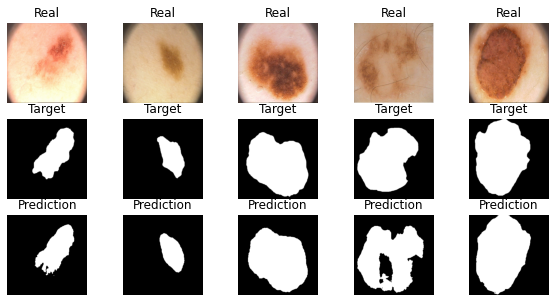

In [52]:
visualize(unet2_model_bce)

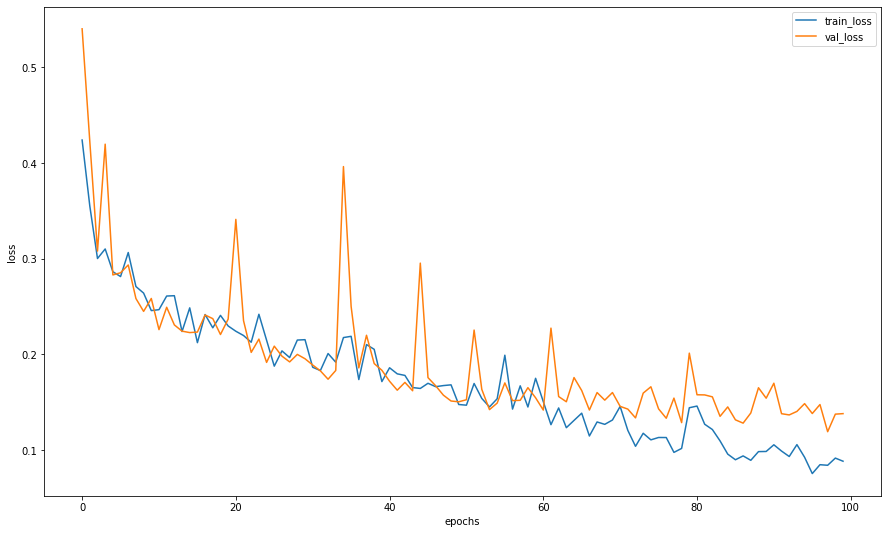

In [53]:
plot_loss(loss, val_loss)

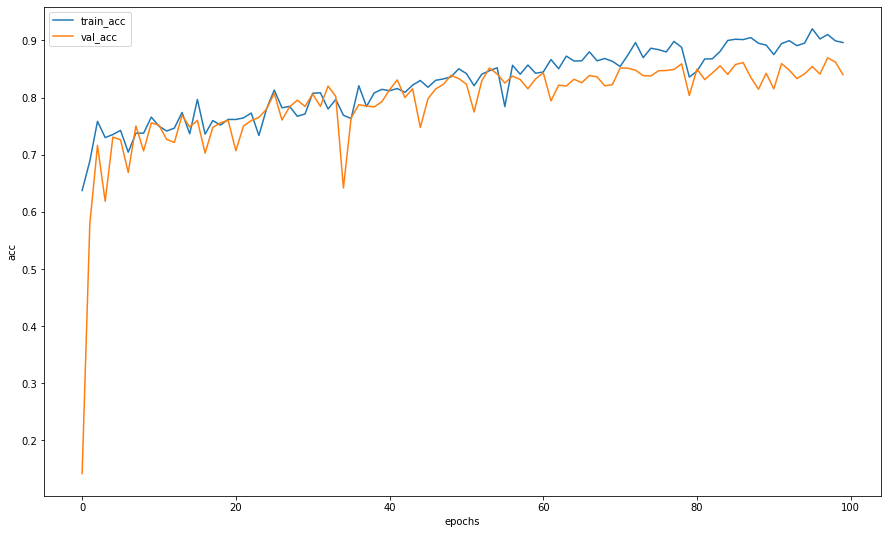

In [54]:
plot_metric(acc, val_acc)

Сохраним модель и ее результаты:

In [55]:
model_save_name = 'model_unet2_bce.pth'
path = F"/content/gdrive/My Drive/DLS/nevus/{model_save_name}" 
torch.save(unet2_model_bce.state_dict(), path)

In [56]:
np.save(F"/content/gdrive/My Drive/DLS/nevus/history_unet2_bce.npy" , history_unet2_bce)

In [ ]:
del unet2_model_bce

### 9.1. Unet2 с dice loss.

In [168]:
unet2_model_dice = UNet2().to(DEVICE)

In [169]:
max_epochs = 100
optimizer = optim.Adam(unet2_model_dice.parameters(), lr=3e-4)
torch.cuda.empty_cache()
history_unet2_dice = train(unet2_model_dice, optimizer, dice_loss, max_epochs, train_dl, val_dl)

epoch:   1%|          | 1/100 [00:09<15:02,  9.12s/it]


Epoch 001 train_loss: 0.2446 val_loss 0.6796 train_acc 0.5637 val_acc 0.2999


epoch:   2%|▏         | 2/100 [00:18<14:51,  9.09s/it]


Epoch 002 train_loss: 0.1461 val_loss 0.3226 train_acc 0.6619 val_acc 0.6259


epoch:   3%|▎         | 3/100 [00:27<14:40,  9.07s/it]


Epoch 003 train_loss: 0.1533 val_loss 0.2132 train_acc 0.5938 val_acc 0.5516


epoch:   4%|▍         | 4/100 [00:36<14:30,  9.06s/it]


Epoch 004 train_loss: 0.1450 val_loss 0.4004 train_acc 0.5773 val_acc 0.4797


epoch:   5%|▌         | 5/100 [00:45<14:19,  9.05s/it]


Epoch 005 train_loss: 0.1462 val_loss 0.1694 train_acc 0.5794 val_acc 0.4544


epoch:   6%|▌         | 6/100 [00:54<14:09,  9.04s/it]


Epoch 006 train_loss: 0.1344 val_loss 0.1515 train_acc 0.5661 val_acc 0.4832


epoch:   7%|▋         | 7/100 [01:03<14:00,  9.03s/it]


Epoch 007 train_loss: 0.1174 val_loss 0.1437 train_acc 0.5957 val_acc 0.5783


epoch:   8%|▊         | 8/100 [01:12<13:50,  9.03s/it]


Epoch 008 train_loss: 0.1078 val_loss 0.1277 train_acc 0.6070 val_acc 0.5409


epoch:   9%|▉         | 9/100 [01:21<13:41,  9.02s/it]


Epoch 009 train_loss: 0.1099 val_loss 0.1284 train_acc 0.6160 val_acc 0.5340


epoch:  10%|█         | 10/100 [01:30<13:32,  9.02s/it]


Epoch 010 train_loss: 0.1153 val_loss 0.1463 train_acc 0.5793 val_acc 0.4719


epoch:  11%|█         | 11/100 [01:39<13:23,  9.03s/it]


Epoch 011 train_loss: 0.1174 val_loss 0.1354 train_acc 0.6115 val_acc 0.5828


epoch:  12%|█▏        | 12/100 [01:48<13:14,  9.03s/it]


Epoch 012 train_loss: 0.0922 val_loss 0.1325 train_acc 0.6100 val_acc 0.6539


epoch:  13%|█▎        | 13/100 [01:57<13:05,  9.03s/it]


Epoch 013 train_loss: 0.0962 val_loss 0.1291 train_acc 0.6540 val_acc 0.6680


epoch:  14%|█▍        | 14/100 [02:06<12:56,  9.03s/it]


Epoch 014 train_loss: 0.1019 val_loss 0.1112 train_acc 0.6087 val_acc 0.4910


epoch:  15%|█▌        | 15/100 [02:15<12:47,  9.03s/it]


Epoch 015 train_loss: 0.0902 val_loss 0.0984 train_acc 0.6228 val_acc 0.5801


epoch:  16%|█▌        | 16/100 [02:24<12:38,  9.03s/it]


Epoch 016 train_loss: 0.0842 val_loss 0.1145 train_acc 0.6589 val_acc 0.6243


epoch:  17%|█▋        | 17/100 [02:33<12:28,  9.02s/it]


Epoch 017 train_loss: 0.0973 val_loss 0.1274 train_acc 0.6008 val_acc 0.5192


epoch:  18%|█▊        | 18/100 [02:42<12:19,  9.02s/it]


Epoch 018 train_loss: 0.0955 val_loss 0.1184 train_acc 0.5981 val_acc 0.5633


epoch:  19%|█▉        | 19/100 [02:51<12:10,  9.02s/it]


Epoch 019 train_loss: 0.1041 val_loss 0.1194 train_acc 0.6063 val_acc 0.5452


epoch:  20%|██        | 20/100 [03:00<12:01,  9.02s/it]


Epoch 020 train_loss: 0.0980 val_loss 0.1137 train_acc 0.5990 val_acc 0.5658


epoch:  21%|██        | 21/100 [03:09<11:52,  9.02s/it]


Epoch 021 train_loss: 0.0820 val_loss 0.1029 train_acc 0.6134 val_acc 0.5310


epoch:  22%|██▏       | 22/100 [03:18<11:43,  9.02s/it]


Epoch 022 train_loss: 0.0866 val_loss 0.0931 train_acc 0.6263 val_acc 0.6001


epoch:  23%|██▎       | 23/100 [03:27<11:34,  9.02s/it]


Epoch 023 train_loss: 0.0853 val_loss 0.1215 train_acc 0.6542 val_acc 0.5788


epoch:  24%|██▍       | 24/100 [03:36<11:25,  9.02s/it]


Epoch 024 train_loss: 0.0835 val_loss 0.1135 train_acc 0.6735 val_acc 0.6443


epoch:  25%|██▌       | 25/100 [03:45<11:16,  9.02s/it]


Epoch 025 train_loss: 0.0947 val_loss 0.1001 train_acc 0.6195 val_acc 0.5658


epoch:  26%|██▌       | 26/100 [03:54<11:07,  9.02s/it]


Epoch 026 train_loss: 0.0751 val_loss 0.1071 train_acc 0.6728 val_acc 0.5368


epoch:  27%|██▋       | 27/100 [04:03<10:58,  9.02s/it]


Epoch 027 train_loss: 0.0786 val_loss 0.0971 train_acc 0.6275 val_acc 0.5628


epoch:  28%|██▊       | 28/100 [04:12<10:49,  9.02s/it]


Epoch 028 train_loss: 0.0889 val_loss 0.0966 train_acc 0.6533 val_acc 0.6458


epoch:  29%|██▉       | 29/100 [04:21<10:40,  9.02s/it]


Epoch 029 train_loss: 0.0842 val_loss 0.1079 train_acc 0.6721 val_acc 0.5405


epoch:  30%|███       | 30/100 [04:30<10:31,  9.02s/it]


Epoch 030 train_loss: 0.0769 val_loss 0.1105 train_acc 0.6576 val_acc 0.6394


epoch:  31%|███       | 31/100 [04:39<10:22,  9.02s/it]


Epoch 031 train_loss: 0.0777 val_loss 0.0994 train_acc 0.6649 val_acc 0.6148


epoch:  32%|███▏      | 32/100 [04:48<10:13,  9.02s/it]


Epoch 032 train_loss: 0.0803 val_loss 0.0986 train_acc 0.6545 val_acc 0.5827


epoch:  33%|███▎      | 33/100 [04:57<10:04,  9.02s/it]


Epoch 033 train_loss: 0.0669 val_loss 0.0996 train_acc 0.6795 val_acc 0.5543


epoch:  34%|███▍      | 34/100 [05:06<09:55,  9.03s/it]


Epoch 034 train_loss: 0.0700 val_loss 0.0950 train_acc 0.6971 val_acc 0.6162


epoch:  35%|███▌      | 35/100 [05:15<09:46,  9.02s/it]


Epoch 035 train_loss: 0.0763 val_loss 0.0997 train_acc 0.6741 val_acc 0.6213


epoch:  36%|███▌      | 36/100 [05:24<09:37,  9.02s/it]


Epoch 036 train_loss: 0.0873 val_loss 0.1243 train_acc 0.6602 val_acc 0.5700


epoch:  37%|███▋      | 37/100 [05:33<09:28,  9.02s/it]


Epoch 037 train_loss: 0.0922 val_loss 0.1002 train_acc 0.6056 val_acc 0.5068


epoch:  38%|███▊      | 38/100 [05:42<09:19,  9.02s/it]


Epoch 038 train_loss: 0.0755 val_loss 0.0957 train_acc 0.6312 val_acc 0.6380


epoch:  39%|███▉      | 39/100 [05:52<09:10,  9.03s/it]


Epoch 039 train_loss: 0.0718 val_loss 0.0991 train_acc 0.6598 val_acc 0.5684


epoch:  40%|████      | 40/100 [06:01<09:01,  9.02s/it]


Epoch 040 train_loss: 0.0801 val_loss 0.0885 train_acc 0.6525 val_acc 0.6669


epoch:  41%|████      | 41/100 [06:10<08:52,  9.03s/it]


Epoch 041 train_loss: 0.0760 val_loss 0.0867 train_acc 0.6673 val_acc 0.6135


epoch:  42%|████▏     | 42/100 [06:19<08:43,  9.03s/it]


Epoch 042 train_loss: 0.0858 val_loss 0.1043 train_acc 0.6430 val_acc 0.5712


epoch:  43%|████▎     | 43/100 [06:28<08:34,  9.03s/it]


Epoch 043 train_loss: 0.0686 val_loss 0.1103 train_acc 0.6495 val_acc 0.5802


epoch:  44%|████▍     | 44/100 [06:37<08:25,  9.02s/it]


Epoch 044 train_loss: 0.0738 val_loss 0.0895 train_acc 0.6738 val_acc 0.6416


epoch:  45%|████▌     | 45/100 [06:46<08:16,  9.02s/it]


Epoch 045 train_loss: 0.0890 val_loss 0.0962 train_acc 0.6677 val_acc 0.6558


epoch:  46%|████▌     | 46/100 [06:55<08:07,  9.03s/it]


Epoch 046 train_loss: 0.0745 val_loss 0.0908 train_acc 0.6265 val_acc 0.6091


epoch:  47%|████▋     | 47/100 [07:04<07:58,  9.03s/it]


Epoch 047 train_loss: 0.0613 val_loss 0.0829 train_acc 0.6475 val_acc 0.5558


epoch:  48%|████▊     | 48/100 [07:13<07:49,  9.02s/it]


Epoch 048 train_loss: 0.0649 val_loss 0.0837 train_acc 0.6624 val_acc 0.5380


epoch:  49%|████▉     | 49/100 [07:22<07:40,  9.02s/it]


Epoch 049 train_loss: 0.0723 val_loss 0.1286 train_acc 0.6604 val_acc 0.6916


epoch:  50%|█████     | 50/100 [07:31<07:31,  9.03s/it]


Epoch 050 train_loss: 0.0684 val_loss 0.0777 train_acc 0.6594 val_acc 0.5892


epoch:  51%|█████     | 51/100 [07:40<07:22,  9.03s/it]


Epoch 051 train_loss: 0.0720 val_loss 0.0864 train_acc 0.6663 val_acc 0.5871


epoch:  52%|█████▏    | 52/100 [07:49<07:13,  9.03s/it]


Epoch 052 train_loss: 0.0639 val_loss 0.0915 train_acc 0.6333 val_acc 0.6526


epoch:  53%|█████▎    | 53/100 [07:58<07:04,  9.03s/it]


Epoch 053 train_loss: 0.0721 val_loss 0.1100 train_acc 0.6897 val_acc 0.5390


epoch:  54%|█████▍    | 54/100 [08:07<06:55,  9.04s/it]


Epoch 054 train_loss: 0.0683 val_loss 0.0794 train_acc 0.6839 val_acc 0.6277


epoch:  55%|█████▌    | 55/100 [08:16<06:46,  9.04s/it]


Epoch 055 train_loss: 0.0688 val_loss 0.0965 train_acc 0.6749 val_acc 0.5188


epoch:  56%|█████▌    | 56/100 [08:25<06:37,  9.04s/it]


Epoch 056 train_loss: 0.0791 val_loss 0.0970 train_acc 0.6796 val_acc 0.6253


epoch:  57%|█████▋    | 57/100 [08:34<06:28,  9.03s/it]


Epoch 057 train_loss: 0.0662 val_loss 0.0863 train_acc 0.6458 val_acc 0.5885


epoch:  58%|█████▊    | 58/100 [08:43<06:19,  9.03s/it]


Epoch 058 train_loss: 0.0698 val_loss 0.0815 train_acc 0.6536 val_acc 0.5582


epoch:  59%|█████▉    | 59/100 [08:52<06:10,  9.03s/it]


Epoch 059 train_loss: 0.0691 val_loss 0.0940 train_acc 0.6568 val_acc 0.5730


epoch:  60%|██████    | 60/100 [09:01<06:01,  9.03s/it]


Epoch 060 train_loss: 0.0672 val_loss 0.0999 train_acc 0.6493 val_acc 0.6097


epoch:  61%|██████    | 61/100 [09:10<05:52,  9.04s/it]


Epoch 061 train_loss: 0.0634 val_loss 0.0829 train_acc 0.6791 val_acc 0.6024


epoch:  62%|██████▏   | 62/100 [09:19<05:43,  9.04s/it]


Epoch 062 train_loss: 0.0540 val_loss 0.0753 train_acc 0.6921 val_acc 0.5960


epoch:  63%|██████▎   | 63/100 [09:28<05:34,  9.04s/it]


Epoch 063 train_loss: 0.0750 val_loss 0.0918 train_acc 0.7075 val_acc 0.6517


epoch:  64%|██████▍   | 64/100 [09:37<05:25,  9.04s/it]


Epoch 064 train_loss: 0.0621 val_loss 0.0955 train_acc 0.6720 val_acc 0.5501


epoch:  65%|██████▌   | 65/100 [09:46<05:16,  9.04s/it]


Epoch 065 train_loss: 0.0659 val_loss 0.0819 train_acc 0.6820 val_acc 0.6585


epoch:  66%|██████▌   | 66/100 [09:55<05:07,  9.04s/it]


Epoch 066 train_loss: 0.0665 val_loss 0.0872 train_acc 0.6993 val_acc 0.6269


epoch:  67%|██████▋   | 67/100 [10:04<04:58,  9.04s/it]


Epoch 067 train_loss: 0.0592 val_loss 0.1063 train_acc 0.6996 val_acc 0.6479


epoch:  68%|██████▊   | 68/100 [10:14<04:49,  9.04s/it]


Epoch 068 train_loss: 0.0603 val_loss 0.0761 train_acc 0.6861 val_acc 0.5965


epoch:  69%|██████▉   | 69/100 [10:23<04:40,  9.04s/it]


Epoch 069 train_loss: 0.0617 val_loss 0.1433 train_acc 0.7079 val_acc 0.5022


epoch:  70%|███████   | 70/100 [10:32<04:31,  9.04s/it]


Epoch 070 train_loss: 0.0646 val_loss 0.0821 train_acc 0.7274 val_acc 0.6533


epoch:  71%|███████   | 71/100 [10:41<04:22,  9.04s/it]


Epoch 071 train_loss: 0.0658 val_loss 0.0835 train_acc 0.6907 val_acc 0.5932


epoch:  72%|███████▏  | 72/100 [10:50<04:13,  9.04s/it]


Epoch 072 train_loss: 0.0553 val_loss 0.1244 train_acc 0.6790 val_acc 0.5475


epoch:  73%|███████▎  | 73/100 [10:59<04:04,  9.04s/it]


Epoch 073 train_loss: 0.0558 val_loss 0.0979 train_acc 0.7000 val_acc 0.7073


epoch:  74%|███████▍  | 74/100 [11:08<03:55,  9.04s/it]


Epoch 074 train_loss: 0.0564 val_loss 0.0959 train_acc 0.7115 val_acc 0.5291


epoch:  75%|███████▌  | 75/100 [11:17<03:46,  9.04s/it]


Epoch 075 train_loss: 0.0522 val_loss 0.0753 train_acc 0.6908 val_acc 0.6722


epoch:  76%|███████▌  | 76/100 [11:26<03:36,  9.04s/it]


Epoch 076 train_loss: 0.0521 val_loss 0.0744 train_acc 0.7355 val_acc 0.6418


epoch:  77%|███████▋  | 77/100 [11:35<03:27,  9.04s/it]


Epoch 077 train_loss: 0.0496 val_loss 0.0748 train_acc 0.7313 val_acc 0.6293


epoch:  78%|███████▊  | 78/100 [11:44<03:18,  9.04s/it]


Epoch 078 train_loss: 0.0658 val_loss 0.0893 train_acc 0.6793 val_acc 0.6344


epoch:  79%|███████▉  | 79/100 [11:53<03:09,  9.04s/it]


Epoch 079 train_loss: 0.0582 val_loss 0.0916 train_acc 0.7022 val_acc 0.4866


epoch:  80%|████████  | 80/100 [12:02<03:00,  9.04s/it]


Epoch 080 train_loss: 0.0541 val_loss 0.0759 train_acc 0.7237 val_acc 0.6456


epoch:  81%|████████  | 81/100 [12:11<02:51,  9.04s/it]


Epoch 081 train_loss: 0.0570 val_loss 0.1144 train_acc 0.7050 val_acc 0.4944


epoch:  82%|████████▏ | 82/100 [12:20<02:42,  9.04s/it]


Epoch 082 train_loss: 0.0578 val_loss 0.0804 train_acc 0.7422 val_acc 0.6336


epoch:  83%|████████▎ | 83/100 [12:29<02:33,  9.04s/it]


Epoch 083 train_loss: 0.0650 val_loss 0.0777 train_acc 0.6969 val_acc 0.6022


epoch:  84%|████████▍ | 84/100 [12:38<02:24,  9.03s/it]


Epoch 084 train_loss: 0.0575 val_loss 0.0789 train_acc 0.7066 val_acc 0.7324


epoch:  85%|████████▌ | 85/100 [12:47<02:15,  9.04s/it]


Epoch 085 train_loss: 0.0542 val_loss 0.0706 train_acc 0.7076 val_acc 0.6376


epoch:  86%|████████▌ | 86/100 [12:56<02:06,  9.04s/it]


Epoch 086 train_loss: 0.0477 val_loss 0.0715 train_acc 0.7071 val_acc 0.6234


epoch:  87%|████████▋ | 87/100 [13:05<01:57,  9.03s/it]


Epoch 087 train_loss: 0.0547 val_loss 0.0754 train_acc 0.7144 val_acc 0.5589


epoch:  88%|████████▊ | 88/100 [13:14<01:48,  9.03s/it]


Epoch 088 train_loss: 0.0591 val_loss 0.1183 train_acc 0.7121 val_acc 0.4953


epoch:  89%|████████▉ | 89/100 [13:23<01:39,  9.03s/it]


Epoch 089 train_loss: 0.0537 val_loss 0.0771 train_acc 0.7264 val_acc 0.6059


epoch:  90%|█████████ | 90/100 [13:32<01:30,  9.03s/it]


Epoch 090 train_loss: 0.0513 val_loss 0.0747 train_acc 0.7122 val_acc 0.6864


epoch:  91%|█████████ | 91/100 [13:41<01:21,  9.02s/it]


Epoch 091 train_loss: 0.0703 val_loss 0.0900 train_acc 0.7259 val_acc 0.6323


epoch:  92%|█████████▏| 92/100 [13:50<01:12,  9.02s/it]


Epoch 092 train_loss: 0.0501 val_loss 0.0782 train_acc 0.7495 val_acc 0.6231


epoch:  93%|█████████▎| 93/100 [13:59<01:03,  9.02s/it]


Epoch 093 train_loss: 0.0516 val_loss 0.0780 train_acc 0.7036 val_acc 0.6427


epoch:  94%|█████████▍| 94/100 [14:08<00:54,  9.02s/it]


Epoch 094 train_loss: 0.0581 val_loss 0.0687 train_acc 0.7467 val_acc 0.6852


epoch:  95%|█████████▌| 95/100 [14:17<00:45,  9.03s/it]


Epoch 095 train_loss: 0.0525 val_loss 0.0936 train_acc 0.7112 val_acc 0.5905


epoch:  96%|█████████▌| 96/100 [14:26<00:36,  9.03s/it]


Epoch 096 train_loss: 0.0479 val_loss 0.0701 train_acc 0.7123 val_acc 0.5941


epoch:  97%|█████████▋| 97/100 [14:36<00:27,  9.03s/it]


Epoch 097 train_loss: 0.0460 val_loss 0.0721 train_acc 0.7433 val_acc 0.7225


epoch:  98%|█████████▊| 98/100 [14:45<00:18,  9.03s/it]


Epoch 098 train_loss: 0.0487 val_loss 0.0657 train_acc 0.7347 val_acc 0.6623


epoch:  99%|█████████▉| 99/100 [14:54<00:09,  9.03s/it]


Epoch 099 train_loss: 0.0510 val_loss 0.0710 train_acc 0.7187 val_acc 0.7022


epoch: 100%|██████████| 100/100 [15:03<00:00,  9.03s/it]


Epoch 100 train_loss: 0.0480 val_loss 0.0875 train_acc 0.7344 val_acc 0.5895


Визуализируем результат:

In [170]:
loss, acc, val_loss, val_acc = zip(*history_unet2_dice)

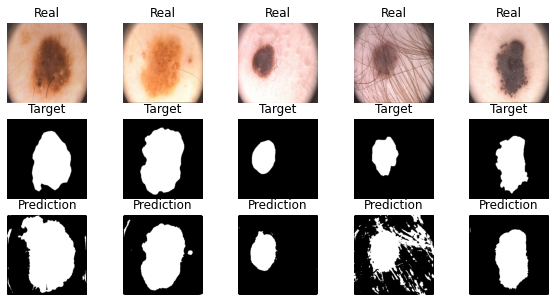

In [173]:
visualize(unet2_model_dice)

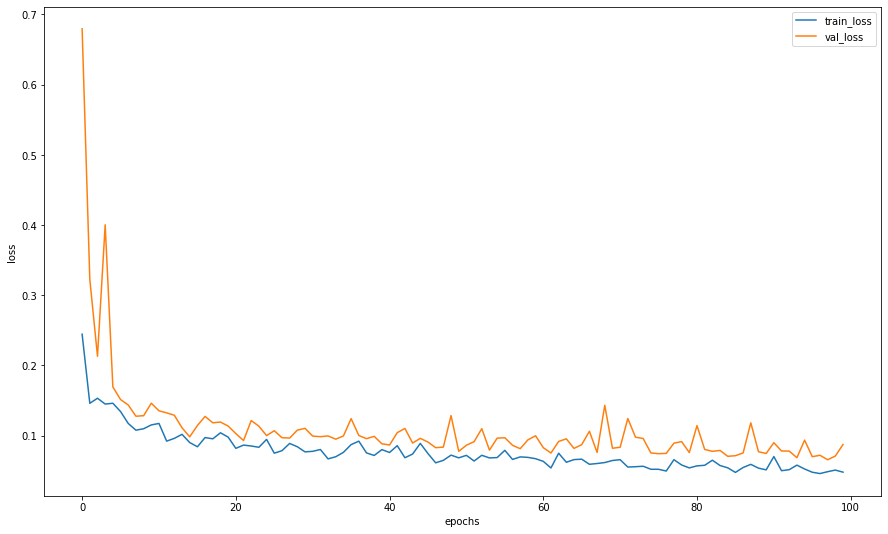

In [174]:
plot_loss(loss, val_loss)

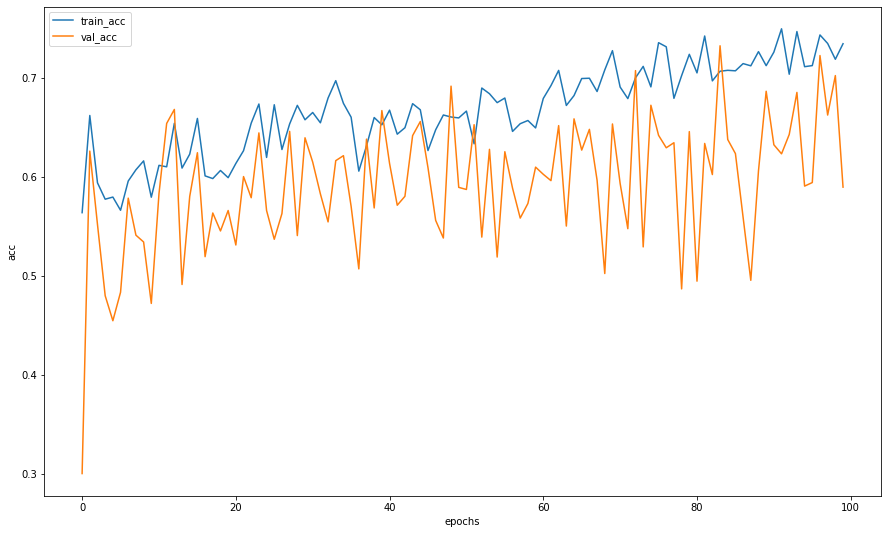

In [175]:
plot_metric(acc, val_acc)

Сохраним модель и ее результаты:

In [176]:
model_save_name = 'model_unet2_dice.pth'
path = F"/content/gdrive/My Drive/DLS/nevus/{model_save_name}" 
torch.save(unet2_model_dice.state_dict(), path)

In [177]:
np.save(F"/content/gdrive/My Drive/DLS/nevus/history_unet2_dice.npy" , history_unet2_dice)

In [178]:
del unet2_model_dice

### 9.2. Unet2 с focal loss.

In [189]:
unet2_model_focal = UNet2().to(DEVICE)

In [190]:
max_epochs = 100
optimizer = optim.Adam(unet2_model_focal.parameters(), lr=3e-4)
torch.cuda.empty_cache()
history_unet2_focal = train(unet2_model_focal, optimizer, focal_loss, max_epochs, train_dl, val_dl)

epoch:   1%|          | 1/100 [00:09<14:56,  9.06s/it]


Epoch 001 train_loss: 0.1609 val_loss 0.1733 train_acc 0.5402 val_acc 0.0000


epoch:   2%|▏         | 2/100 [00:18<14:50,  9.08s/it]


Epoch 002 train_loss: 0.1508 val_loss 0.1664 train_acc 0.6234 val_acc 0.3583


epoch:   3%|▎         | 3/100 [00:27<14:46,  9.14s/it]


Epoch 003 train_loss: 0.1502 val_loss 0.1530 train_acc 0.6707 val_acc 0.5745


epoch:   4%|▍         | 4/100 [00:36<14:38,  9.15s/it]


Epoch 004 train_loss: 0.1484 val_loss 0.1614 train_acc 0.6559 val_acc 0.5968


epoch:   5%|▌         | 5/100 [00:45<14:25,  9.11s/it]


Epoch 005 train_loss: 0.1491 val_loss 0.1505 train_acc 0.6632 val_acc 0.6142


epoch:   6%|▌         | 6/100 [00:54<14:12,  9.07s/it]


Epoch 006 train_loss: 0.1490 val_loss 0.1501 train_acc 0.6619 val_acc 0.6508


epoch:   7%|▋         | 7/100 [01:03<13:58,  9.02s/it]


Epoch 007 train_loss: 0.1475 val_loss 0.1509 train_acc 0.6756 val_acc 0.6124


epoch:   8%|▊         | 8/100 [01:12<13:46,  8.98s/it]


Epoch 008 train_loss: 0.1529 val_loss 0.1590 train_acc 0.6659 val_acc 0.6217


epoch:   9%|▉         | 9/100 [01:21<13:35,  8.96s/it]


Epoch 009 train_loss: 0.1471 val_loss 0.1557 train_acc 0.6859 val_acc 0.5311


epoch:  10%|█         | 10/100 [01:30<13:27,  8.97s/it]


Epoch 010 train_loss: 0.1493 val_loss 0.1527 train_acc 0.6524 val_acc 0.6106


epoch:  11%|█         | 11/100 [01:39<13:20,  8.99s/it]


Epoch 011 train_loss: 0.1442 val_loss 0.1505 train_acc 0.7273 val_acc 0.6524


epoch:  12%|█▏        | 12/100 [01:48<13:12,  9.01s/it]


Epoch 012 train_loss: 0.1502 val_loss 0.1533 train_acc 0.6296 val_acc 0.5951


epoch:  13%|█▎        | 13/100 [01:57<13:04,  9.02s/it]


Epoch 013 train_loss: 0.1460 val_loss 0.1498 train_acc 0.6927 val_acc 0.6673


epoch:  14%|█▍        | 14/100 [02:06<12:55,  9.02s/it]


Epoch 014 train_loss: 0.1457 val_loss 0.1519 train_acc 0.7193 val_acc 0.6338


epoch:  15%|█▌        | 15/100 [02:15<12:46,  9.02s/it]


Epoch 015 train_loss: 0.1457 val_loss 0.1527 train_acc 0.7071 val_acc 0.5873


epoch:  16%|█▌        | 16/100 [02:24<12:37,  9.02s/it]


Epoch 016 train_loss: 0.1431 val_loss 0.1494 train_acc 0.7469 val_acc 0.6734


epoch:  17%|█▋        | 17/100 [02:33<12:28,  9.02s/it]


Epoch 017 train_loss: 0.1442 val_loss 0.1530 train_acc 0.7331 val_acc 0.6252


epoch:  18%|█▊        | 18/100 [02:42<12:19,  9.02s/it]


Epoch 018 train_loss: 0.1420 val_loss 0.1507 train_acc 0.7743 val_acc 0.7030


epoch:  19%|█▉        | 19/100 [02:51<12:10,  9.02s/it]


Epoch 019 train_loss: 0.1434 val_loss 0.1510 train_acc 0.7416 val_acc 0.6480


epoch:  20%|██        | 20/100 [03:00<12:01,  9.02s/it]


Epoch 020 train_loss: 0.1419 val_loss 0.1491 train_acc 0.7680 val_acc 0.6808


epoch:  21%|██        | 21/100 [03:09<11:53,  9.03s/it]


Epoch 021 train_loss: 0.1420 val_loss 0.1474 train_acc 0.7667 val_acc 0.7225


epoch:  22%|██▏       | 22/100 [03:18<11:44,  9.03s/it]


Epoch 022 train_loss: 0.1423 val_loss 0.1478 train_acc 0.7587 val_acc 0.7197


epoch:  23%|██▎       | 23/100 [03:27<11:35,  9.04s/it]


Epoch 023 train_loss: 0.1423 val_loss 0.1479 train_acc 0.7559 val_acc 0.6857


epoch:  24%|██▍       | 24/100 [03:36<11:26,  9.04s/it]


Epoch 024 train_loss: 0.1417 val_loss 0.1509 train_acc 0.7641 val_acc 0.7142


epoch:  25%|██▌       | 25/100 [03:45<11:17,  9.04s/it]


Epoch 025 train_loss: 0.1406 val_loss 0.1479 train_acc 0.7897 val_acc 0.7273


epoch:  26%|██▌       | 26/100 [03:54<11:08,  9.04s/it]


Epoch 026 train_loss: 0.1444 val_loss 0.1505 train_acc 0.7306 val_acc 0.6444


epoch:  27%|██▋       | 27/100 [04:03<10:59,  9.04s/it]


Epoch 027 train_loss: 0.1437 val_loss 0.1473 train_acc 0.7676 val_acc 0.7275


epoch:  28%|██▊       | 28/100 [04:12<10:50,  9.03s/it]


Epoch 028 train_loss: 0.1434 val_loss 0.1474 train_acc 0.7478 val_acc 0.7198


epoch:  29%|██▉       | 29/100 [04:21<10:41,  9.03s/it]


Epoch 029 train_loss: 0.1465 val_loss 0.1474 train_acc 0.7221 val_acc 0.6954


epoch:  30%|███       | 30/100 [04:30<10:31,  9.03s/it]


Epoch 030 train_loss: 0.1424 val_loss 0.1478 train_acc 0.7732 val_acc 0.7119


epoch:  31%|███       | 31/100 [04:39<10:22,  9.02s/it]


Epoch 031 train_loss: 0.1440 val_loss 0.1526 train_acc 0.7419 val_acc 0.5781


epoch:  32%|███▏      | 32/100 [04:49<10:13,  9.02s/it]


Epoch 032 train_loss: 0.1433 val_loss 0.1484 train_acc 0.7390 val_acc 0.6790


epoch:  33%|███▎      | 33/100 [04:58<10:04,  9.03s/it]


Epoch 033 train_loss: 0.1415 val_loss 0.1467 train_acc 0.7681 val_acc 0.7372


epoch:  34%|███▍      | 34/100 [05:07<09:55,  9.03s/it]


Epoch 034 train_loss: 0.1431 val_loss 0.1472 train_acc 0.7513 val_acc 0.7347


epoch:  35%|███▌      | 35/100 [05:16<09:46,  9.03s/it]


Epoch 035 train_loss: 0.1438 val_loss 0.1470 train_acc 0.7548 val_acc 0.6987


epoch:  36%|███▌      | 36/100 [05:25<09:37,  9.02s/it]


Epoch 036 train_loss: 0.1427 val_loss 0.1471 train_acc 0.7485 val_acc 0.7223


epoch:  37%|███▋      | 37/100 [05:34<09:28,  9.02s/it]


Epoch 037 train_loss: 0.1429 val_loss 0.1463 train_acc 0.7620 val_acc 0.7463


epoch:  38%|███▊      | 38/100 [05:43<09:19,  9.02s/it]


Epoch 038 train_loss: 0.1414 val_loss 0.1465 train_acc 0.7629 val_acc 0.7252


epoch:  39%|███▉      | 39/100 [05:52<09:10,  9.02s/it]


Epoch 039 train_loss: 0.1417 val_loss 0.1474 train_acc 0.7743 val_acc 0.7127


epoch:  40%|████      | 40/100 [06:01<09:01,  9.02s/it]


Epoch 040 train_loss: 0.1415 val_loss 0.1493 train_acc 0.7831 val_acc 0.7223


epoch:  41%|████      | 41/100 [06:10<08:52,  9.02s/it]


Epoch 041 train_loss: 0.1430 val_loss 0.1469 train_acc 0.7540 val_acc 0.7251


epoch:  42%|████▏     | 42/100 [06:19<08:43,  9.02s/it]


Epoch 042 train_loss: 0.1405 val_loss 0.1469 train_acc 0.7740 val_acc 0.7201


epoch:  43%|████▎     | 43/100 [06:28<08:34,  9.02s/it]


Epoch 043 train_loss: 0.1408 val_loss 0.1466 train_acc 0.7853 val_acc 0.7306


epoch:  44%|████▍     | 44/100 [06:37<08:25,  9.02s/it]


Epoch 044 train_loss: 0.1433 val_loss 0.1482 train_acc 0.7582 val_acc 0.6811


epoch:  45%|████▌     | 45/100 [06:46<08:16,  9.02s/it]


Epoch 045 train_loss: 0.1409 val_loss 0.1447 train_acc 0.7877 val_acc 0.7804


epoch:  46%|████▌     | 46/100 [06:55<08:07,  9.03s/it]


Epoch 046 train_loss: 0.1407 val_loss 0.1447 train_acc 0.7904 val_acc 0.7618


epoch:  47%|████▋     | 47/100 [07:04<07:58,  9.02s/it]


Epoch 047 train_loss: 0.1416 val_loss 0.1461 train_acc 0.7889 val_acc 0.7473


epoch:  48%|████▊     | 48/100 [07:13<07:49,  9.03s/it]


Epoch 048 train_loss: 0.1401 val_loss 0.1478 train_acc 0.7996 val_acc 0.7036


epoch:  49%|████▉     | 49/100 [07:22<07:40,  9.03s/it]


Epoch 049 train_loss: 0.1405 val_loss 0.1448 train_acc 0.7941 val_acc 0.7507


epoch:  50%|█████     | 50/100 [07:31<07:31,  9.03s/it]


Epoch 050 train_loss: 0.1414 val_loss 0.1455 train_acc 0.7821 val_acc 0.7432


epoch:  51%|█████     | 51/100 [07:40<07:22,  9.03s/it]


Epoch 051 train_loss: 0.1407 val_loss 0.1440 train_acc 0.7970 val_acc 0.7695


epoch:  52%|█████▏    | 52/100 [07:49<07:13,  9.03s/it]


Epoch 052 train_loss: 0.1399 val_loss 0.1487 train_acc 0.8045 val_acc 0.7021


epoch:  53%|█████▎    | 53/100 [07:58<07:04,  9.03s/it]


Epoch 053 train_loss: 0.1421 val_loss 0.1484 train_acc 0.7890 val_acc 0.6930


epoch:  54%|█████▍    | 54/100 [08:07<06:55,  9.03s/it]


Epoch 054 train_loss: 0.1406 val_loss 0.1486 train_acc 0.7999 val_acc 0.7065


epoch:  55%|█████▌    | 55/100 [08:16<06:46,  9.03s/it]


Epoch 055 train_loss: 0.1425 val_loss 0.1436 train_acc 0.7724 val_acc 0.7689


epoch:  56%|█████▌    | 56/100 [08:25<06:37,  9.03s/it]


Epoch 056 train_loss: 0.1393 val_loss 0.1439 train_acc 0.8097 val_acc 0.7741


epoch:  57%|█████▋    | 57/100 [08:34<06:28,  9.03s/it]


Epoch 057 train_loss: 0.1403 val_loss 0.1445 train_acc 0.7898 val_acc 0.7631


epoch:  58%|█████▊    | 58/100 [08:43<06:19,  9.03s/it]


Epoch 058 train_loss: 0.1408 val_loss 0.1438 train_acc 0.7873 val_acc 0.7703


epoch:  59%|█████▉    | 59/100 [08:52<06:10,  9.03s/it]


Epoch 059 train_loss: 0.1410 val_loss 0.1459 train_acc 0.7805 val_acc 0.7484


epoch:  60%|██████    | 60/100 [09:01<06:01,  9.03s/it]


Epoch 060 train_loss: 0.1405 val_loss 0.1492 train_acc 0.8025 val_acc 0.6906


epoch:  61%|██████    | 61/100 [09:10<05:52,  9.03s/it]


Epoch 061 train_loss: 0.1407 val_loss 0.1466 train_acc 0.7866 val_acc 0.7246


epoch:  62%|██████▏   | 62/100 [09:19<05:43,  9.03s/it]


Epoch 062 train_loss: 0.1394 val_loss 0.1439 train_acc 0.8039 val_acc 0.7701


epoch:  63%|██████▎   | 63/100 [09:28<05:33,  9.03s/it]


Epoch 063 train_loss: 0.1389 val_loss 0.1442 train_acc 0.8197 val_acc 0.7730


epoch:  64%|██████▍   | 64/100 [09:37<05:24,  9.03s/it]


Epoch 064 train_loss: 0.1379 val_loss 0.1448 train_acc 0.8309 val_acc 0.7544


epoch:  65%|██████▌   | 65/100 [09:46<05:15,  9.03s/it]


Epoch 065 train_loss: 0.1398 val_loss 0.1455 train_acc 0.7984 val_acc 0.7516


epoch:  66%|██████▌   | 66/100 [09:55<05:07,  9.03s/it]


Epoch 066 train_loss: 0.1402 val_loss 0.1448 train_acc 0.7897 val_acc 0.7602


epoch:  67%|██████▋   | 67/100 [10:04<04:58,  9.04s/it]


Epoch 067 train_loss: 0.1439 val_loss 0.1449 train_acc 0.7738 val_acc 0.7585


epoch:  68%|██████▊   | 68/100 [10:13<04:49,  9.04s/it]


Epoch 068 train_loss: 0.1391 val_loss 0.1443 train_acc 0.7987 val_acc 0.7728


epoch:  69%|██████▉   | 69/100 [10:23<04:40,  9.03s/it]


Epoch 069 train_loss: 0.1387 val_loss 0.1442 train_acc 0.8161 val_acc 0.7635


epoch:  70%|███████   | 70/100 [10:32<04:30,  9.03s/it]


Epoch 070 train_loss: 0.1400 val_loss 0.1426 train_acc 0.8025 val_acc 0.7868


epoch:  71%|███████   | 71/100 [10:41<04:21,  9.03s/it]


Epoch 071 train_loss: 0.1378 val_loss 0.1428 train_acc 0.8227 val_acc 0.7890


epoch:  72%|███████▏  | 72/100 [10:50<04:12,  9.03s/it]


Epoch 072 train_loss: 0.1385 val_loss 0.1438 train_acc 0.8232 val_acc 0.7762


epoch:  73%|███████▎  | 73/100 [10:59<04:03,  9.03s/it]


Epoch 073 train_loss: 0.1404 val_loss 0.1441 train_acc 0.7914 val_acc 0.7656


epoch:  74%|███████▍  | 74/100 [11:08<03:54,  9.03s/it]


Epoch 074 train_loss: 0.1402 val_loss 0.1532 train_acc 0.8060 val_acc 0.6710


epoch:  75%|███████▌  | 75/100 [11:17<03:45,  9.03s/it]


Epoch 075 train_loss: 0.1403 val_loss 0.1476 train_acc 0.8137 val_acc 0.7258


epoch:  76%|███████▌  | 76/100 [11:26<03:36,  9.03s/it]


Epoch 076 train_loss: 0.1395 val_loss 0.1434 train_acc 0.7950 val_acc 0.7911


epoch:  77%|███████▋  | 77/100 [11:35<03:27,  9.03s/it]


Epoch 077 train_loss: 0.1381 val_loss 0.1448 train_acc 0.8221 val_acc 0.7763


epoch:  78%|███████▊  | 78/100 [11:44<03:18,  9.03s/it]


Epoch 078 train_loss: 0.1440 val_loss 0.1451 train_acc 0.7595 val_acc 0.7375


epoch:  79%|███████▉  | 79/100 [11:53<03:09,  9.03s/it]


Epoch 079 train_loss: 0.1399 val_loss 0.1438 train_acc 0.7909 val_acc 0.7690


epoch:  80%|████████  | 80/100 [12:02<03:00,  9.03s/it]


Epoch 080 train_loss: 0.1406 val_loss 0.1442 train_acc 0.7910 val_acc 0.7501


epoch:  81%|████████  | 81/100 [12:11<02:51,  9.03s/it]


Epoch 081 train_loss: 0.1393 val_loss 0.1450 train_acc 0.8017 val_acc 0.7492


epoch:  82%|████████▏ | 82/100 [12:20<02:42,  9.02s/it]


Epoch 082 train_loss: 0.1395 val_loss 0.1440 train_acc 0.8053 val_acc 0.7617


epoch:  83%|████████▎ | 83/100 [12:29<02:33,  9.02s/it]


Epoch 083 train_loss: 0.1393 val_loss 0.1437 train_acc 0.8111 val_acc 0.7732


epoch:  84%|████████▍ | 84/100 [12:38<02:24,  9.03s/it]


Epoch 084 train_loss: 0.1376 val_loss 0.1447 train_acc 0.8295 val_acc 0.7572


epoch:  85%|████████▌ | 85/100 [12:47<02:15,  9.03s/it]


Epoch 085 train_loss: 0.1394 val_loss 0.1434 train_acc 0.8112 val_acc 0.7743


epoch:  86%|████████▌ | 86/100 [12:56<02:06,  9.03s/it]


Epoch 086 train_loss: 0.1367 val_loss 0.1436 train_acc 0.8375 val_acc 0.7816


epoch:  87%|████████▋ | 87/100 [13:05<01:57,  9.03s/it]


Epoch 087 train_loss: 0.1389 val_loss 0.1465 train_acc 0.8162 val_acc 0.7151


epoch:  88%|████████▊ | 88/100 [13:14<01:48,  9.03s/it]


Epoch 088 train_loss: 0.1379 val_loss 0.1467 train_acc 0.8196 val_acc 0.7320


epoch:  89%|████████▉ | 89/100 [13:23<01:39,  9.03s/it]


Epoch 089 train_loss: 0.1385 val_loss 0.1443 train_acc 0.8154 val_acc 0.7667


epoch:  90%|█████████ | 90/100 [13:32<01:30,  9.04s/it]


Epoch 090 train_loss: 0.1371 val_loss 0.1432 train_acc 0.8374 val_acc 0.7866


epoch:  91%|█████████ | 91/100 [13:41<01:21,  9.04s/it]


Epoch 091 train_loss: 0.1372 val_loss 0.1431 train_acc 0.8403 val_acc 0.7902


epoch:  92%|█████████▏| 92/100 [13:50<01:12,  9.04s/it]


Epoch 092 train_loss: 0.1369 val_loss 0.1472 train_acc 0.8391 val_acc 0.7620


epoch:  93%|█████████▎| 93/100 [13:59<01:03,  9.04s/it]


Epoch 093 train_loss: 0.1373 val_loss 0.1435 train_acc 0.8414 val_acc 0.7881


epoch:  94%|█████████▍| 94/100 [14:08<00:54,  9.04s/it]


Epoch 094 train_loss: 0.1373 val_loss 0.1442 train_acc 0.8385 val_acc 0.7700


epoch:  95%|█████████▌| 95/100 [14:17<00:45,  9.03s/it]


Epoch 095 train_loss: 0.1369 val_loss 0.1429 train_acc 0.8363 val_acc 0.8023


epoch:  96%|█████████▌| 96/100 [14:26<00:36,  9.03s/it]


Epoch 096 train_loss: 0.1388 val_loss 0.1430 train_acc 0.8148 val_acc 0.7756


epoch:  97%|█████████▋| 97/100 [14:35<00:27,  9.03s/it]


Epoch 097 train_loss: 0.1392 val_loss 0.1495 train_acc 0.8116 val_acc 0.7288


epoch:  98%|█████████▊| 98/100 [14:44<00:18,  9.03s/it]


Epoch 098 train_loss: 0.1380 val_loss 0.1456 train_acc 0.8193 val_acc 0.7505


epoch:  99%|█████████▉| 99/100 [14:53<00:09,  9.03s/it]


Epoch 099 train_loss: 0.1387 val_loss 0.1441 train_acc 0.8225 val_acc 0.7833


epoch: 100%|██████████| 100/100 [15:02<00:00,  9.03s/it]


Epoch 100 train_loss: 0.1373 val_loss 0.1434 train_acc 0.8287 val_acc 0.7893


Визуализируем результат:

In [191]:
loss, acc, val_loss, val_acc = zip(*history_unet2_focal)

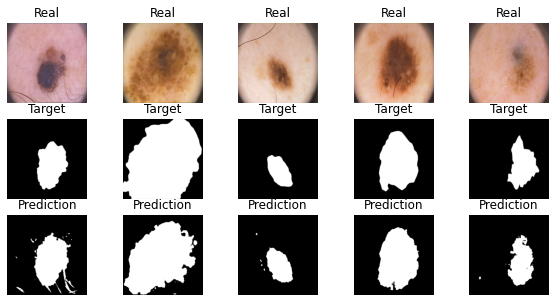

In [192]:
visualize(unet2_model_focal)

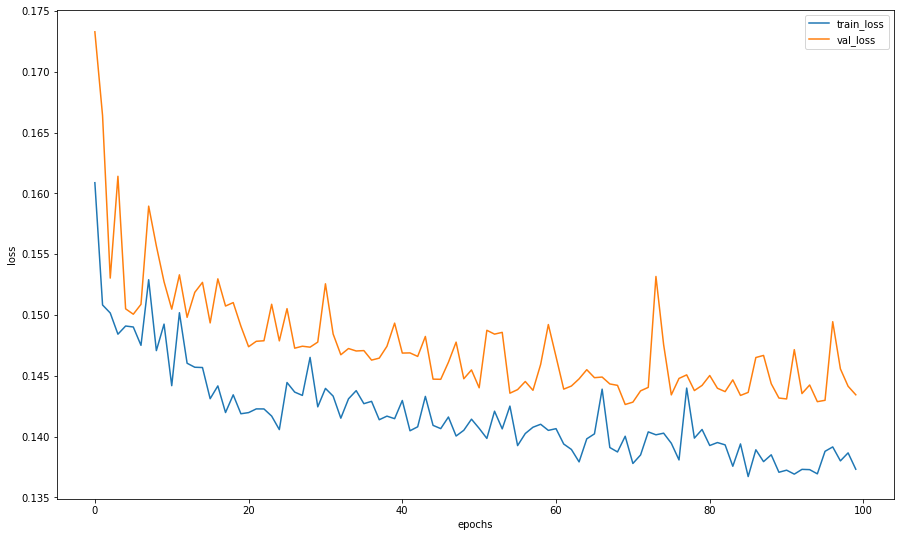

In [193]:
plot_loss(loss, val_loss)

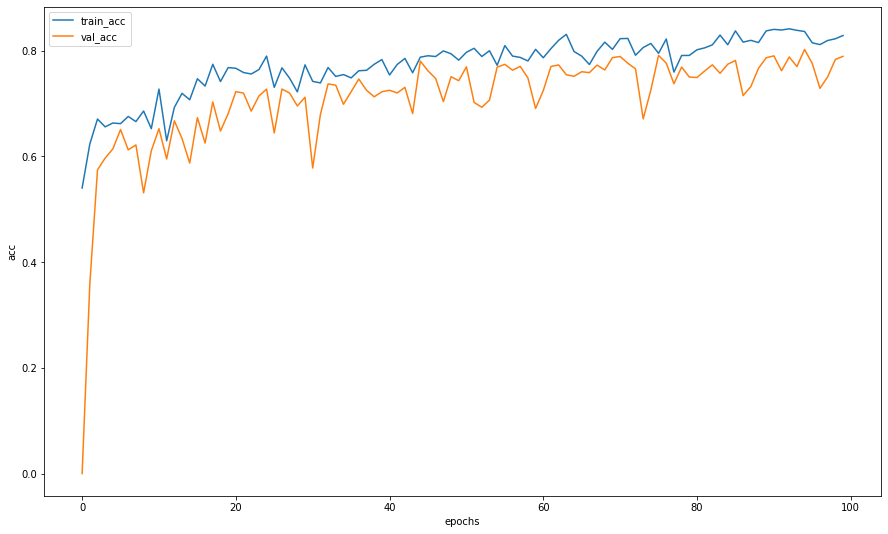

In [194]:
plot_metric(acc, val_acc)

Сохраним модель и ее результаты:

In [195]:
model_save_name = 'model_unet2_focal.pth'
path = F"/content/gdrive/My Drive/DLS/nevus/{model_save_name}" 
torch.save(unet2_model_focal.state_dict(), path)

In [196]:
np.save(F"/content/gdrive/My Drive/DLS/nevus/history_unet2_focal.npy" , history_unet2_focal)

In [197]:
del unet2_model_focal

### 9.3. Unet2 с Lovasz loss.

In [224]:
unet2_model_lovasz = UNet2().to(DEVICE)

In [210]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, data_tr, opt, loss_fn)
            val_loss, val_acc = eval_epoch(model, data_val, loss_fn)
            history.append((train_loss, train_acc, val_loss, val_acc))
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch + 1, t_loss=train_loss, v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
        if epoch == 10:
          optimizer.param_groups[0]['lr'] = 1e-3
        if epoch == 25:
          optimizer.param_groups[0]['lr'] = 3e-4
        if epoch == 50:
          optimizer.param_groups[0]['lr'] = 3e-5
    return history

In [214]:
max_epochs = 100
optimizer = optim.Adam(unet2_model_lovasz.parameters(), lr=0.002)
torch.cuda.empty_cache()
history_unet2_lovasz = train(unet2_model_lovasz, optimizer, lovasz_hinge, max_epochs, train_dl, val_dl)

epoch:   1%|          | 1/100 [00:09<15:15,  9.25s/it]


Epoch 001 train_loss: 0.9012 val_loss 1.4013 train_acc 0.5573 val_acc 0.2620


epoch:   2%|▏         | 2/100 [00:18<15:07,  9.26s/it]


Epoch 002 train_loss: 0.7014 val_loss 1.0126 train_acc 0.6698 val_acc 0.5210


epoch:   3%|▎         | 3/100 [00:27<14:56,  9.25s/it]


Epoch 003 train_loss: 0.6652 val_loss 1.0585 train_acc 0.7026 val_acc 0.5896


epoch:   4%|▍         | 4/100 [00:36<14:43,  9.20s/it]


Epoch 004 train_loss: 0.6892 val_loss 0.7695 train_acc 0.6798 val_acc 0.6357


epoch:   5%|▌         | 5/100 [00:45<14:29,  9.15s/it]


Epoch 005 train_loss: 0.6378 val_loss 0.8085 train_acc 0.7095 val_acc 0.6189


epoch:   6%|▌         | 6/100 [00:54<14:16,  9.11s/it]


Epoch 006 train_loss: 0.6087 val_loss 0.6669 train_acc 0.7256 val_acc 0.6927


epoch:   7%|▋         | 7/100 [01:03<14:04,  9.08s/it]


Epoch 007 train_loss: 0.5621 val_loss 1.0487 train_acc 0.7495 val_acc 0.5360


epoch:   8%|▊         | 8/100 [01:12<13:53,  9.06s/it]


Epoch 008 train_loss: 0.5367 val_loss 0.6611 train_acc 0.7507 val_acc 0.6773


epoch:   9%|▉         | 9/100 [01:21<13:44,  9.06s/it]


Epoch 009 train_loss: 0.5120 val_loss 1.1687 train_acc 0.7629 val_acc 0.5736


epoch:  10%|█         | 10/100 [01:31<13:35,  9.06s/it]


Epoch 010 train_loss: 0.5323 val_loss 1.9728 train_acc 0.7540 val_acc 0.0982


epoch:  11%|█         | 11/100 [01:40<13:27,  9.07s/it]


Epoch 011 train_loss: 0.5558 val_loss 0.5739 train_acc 0.7462 val_acc 0.7437


epoch:  12%|█▏        | 12/100 [01:49<13:18,  9.07s/it]


Epoch 012 train_loss: 0.5207 val_loss 0.6358 train_acc 0.7636 val_acc 0.7190


epoch:  13%|█▎        | 13/100 [01:58<13:08,  9.06s/it]


Epoch 013 train_loss: 0.5351 val_loss 0.8790 train_acc 0.7600 val_acc 0.6612


epoch:  14%|█▍        | 14/100 [02:07<12:58,  9.06s/it]


Epoch 014 train_loss: 0.5876 val_loss 0.7077 train_acc 0.7299 val_acc 0.6557


epoch:  15%|█▌        | 15/100 [02:16<12:49,  9.05s/it]


Epoch 015 train_loss: 0.5668 val_loss 0.5960 train_acc 0.7382 val_acc 0.7171


epoch:  16%|█▌        | 16/100 [02:25<12:40,  9.05s/it]


Epoch 016 train_loss: 0.4786 val_loss 0.5925 train_acc 0.7808 val_acc 0.7326


epoch:  17%|█▋        | 17/100 [02:34<12:30,  9.05s/it]


Epoch 017 train_loss: 0.5477 val_loss 0.6380 train_acc 0.7540 val_acc 0.7164


epoch:  18%|█▊        | 18/100 [02:43<12:21,  9.04s/it]


Epoch 018 train_loss: 0.4979 val_loss 0.5727 train_acc 0.7713 val_acc 0.7376


epoch:  19%|█▉        | 19/100 [02:52<12:12,  9.05s/it]


Epoch 019 train_loss: 0.4928 val_loss 0.5566 train_acc 0.7821 val_acc 0.7450


epoch:  20%|██        | 20/100 [03:01<12:03,  9.05s/it]


Epoch 020 train_loss: 0.5120 val_loss 0.7483 train_acc 0.7639 val_acc 0.6471


epoch:  21%|██        | 21/100 [03:10<11:54,  9.05s/it]


Epoch 021 train_loss: 0.4509 val_loss 0.7108 train_acc 0.7909 val_acc 0.6600


epoch:  22%|██▏       | 22/100 [03:19<11:45,  9.05s/it]


Epoch 022 train_loss: 0.5916 val_loss 0.5414 train_acc 0.7373 val_acc 0.7673


epoch:  23%|██▎       | 23/100 [03:28<11:37,  9.05s/it]


Epoch 023 train_loss: 0.5055 val_loss 0.6046 train_acc 0.7712 val_acc 0.7373


epoch:  24%|██▍       | 24/100 [03:37<11:27,  9.05s/it]


Epoch 024 train_loss: 0.4992 val_loss 0.5130 train_acc 0.7736 val_acc 0.7739


epoch:  25%|██▌       | 25/100 [03:46<11:18,  9.05s/it]


Epoch 025 train_loss: 0.3977 val_loss 0.5335 train_acc 0.8188 val_acc 0.7544


epoch:  26%|██▌       | 26/100 [03:55<11:09,  9.05s/it]


Epoch 026 train_loss: 0.5078 val_loss 0.5943 train_acc 0.7688 val_acc 0.7203


epoch:  27%|██▋       | 27/100 [04:04<11:00,  9.04s/it]


Epoch 027 train_loss: 0.4795 val_loss 0.7257 train_acc 0.7839 val_acc 0.6201


epoch:  28%|██▊       | 28/100 [04:13<10:51,  9.05s/it]


Epoch 028 train_loss: 0.4818 val_loss 0.5501 train_acc 0.7824 val_acc 0.7527


epoch:  29%|██▉       | 29/100 [04:22<10:42,  9.04s/it]


Epoch 029 train_loss: 0.5084 val_loss 0.7085 train_acc 0.7648 val_acc 0.6379


epoch:  30%|███       | 30/100 [04:32<10:33,  9.04s/it]


Epoch 030 train_loss: 0.5475 val_loss 0.5769 train_acc 0.7481 val_acc 0.7156


epoch:  31%|███       | 31/100 [04:41<10:23,  9.04s/it]


Epoch 031 train_loss: 0.4710 val_loss 0.6920 train_acc 0.7892 val_acc 0.6971


epoch:  32%|███▏      | 32/100 [04:50<10:14,  9.04s/it]


Epoch 032 train_loss: 0.4264 val_loss 0.5312 train_acc 0.8073 val_acc 0.7560


epoch:  33%|███▎      | 33/100 [04:59<10:05,  9.04s/it]


Epoch 033 train_loss: 0.4053 val_loss 0.5496 train_acc 0.8160 val_acc 0.7250


epoch:  34%|███▍      | 34/100 [05:08<09:56,  9.04s/it]


Epoch 034 train_loss: 0.4189 val_loss 0.5060 train_acc 0.8164 val_acc 0.7765


epoch:  35%|███▌      | 35/100 [05:17<09:47,  9.04s/it]


Epoch 035 train_loss: 0.4793 val_loss 0.5981 train_acc 0.7861 val_acc 0.7220


epoch:  36%|███▌      | 36/100 [05:26<09:38,  9.04s/it]


Epoch 036 train_loss: 0.5396 val_loss 0.5639 train_acc 0.7557 val_acc 0.7644


epoch:  37%|███▋      | 37/100 [05:35<09:29,  9.04s/it]


Epoch 037 train_loss: 0.4632 val_loss 0.5765 train_acc 0.7905 val_acc 0.7267


epoch:  38%|███▊      | 38/100 [05:44<09:20,  9.04s/it]


Epoch 038 train_loss: 0.4206 val_loss 0.5241 train_acc 0.8069 val_acc 0.7608


epoch:  39%|███▉      | 39/100 [05:53<09:11,  9.05s/it]


Epoch 039 train_loss: 0.4299 val_loss 0.5041 train_acc 0.8060 val_acc 0.7737


epoch:  40%|████      | 40/100 [06:02<09:02,  9.05s/it]


Epoch 040 train_loss: 0.4726 val_loss 0.5006 train_acc 0.7865 val_acc 0.7727


epoch:  41%|████      | 41/100 [06:11<08:53,  9.05s/it]


Epoch 041 train_loss: 0.4048 val_loss 0.4910 train_acc 0.8202 val_acc 0.7688


epoch:  42%|████▏     | 42/100 [06:20<08:44,  9.05s/it]


Epoch 042 train_loss: 0.4602 val_loss 0.5102 train_acc 0.7943 val_acc 0.7734


epoch:  43%|████▎     | 43/100 [06:29<08:35,  9.05s/it]


Epoch 043 train_loss: 0.4562 val_loss 0.5000 train_acc 0.7968 val_acc 0.7685


epoch:  44%|████▍     | 44/100 [06:38<08:26,  9.05s/it]


Epoch 044 train_loss: 0.4177 val_loss 0.5691 train_acc 0.8121 val_acc 0.7243


epoch:  45%|████▌     | 45/100 [06:47<08:17,  9.05s/it]


Epoch 045 train_loss: 0.4495 val_loss 0.5618 train_acc 0.7965 val_acc 0.7358


epoch:  46%|████▌     | 46/100 [06:56<08:08,  9.05s/it]


Epoch 046 train_loss: 0.3973 val_loss 0.5274 train_acc 0.8225 val_acc 0.7666


epoch:  47%|████▋     | 47/100 [07:05<07:59,  9.05s/it]


Epoch 047 train_loss: 0.4020 val_loss 0.4341 train_acc 0.8189 val_acc 0.8020


epoch:  48%|████▊     | 48/100 [07:14<07:50,  9.04s/it]


Epoch 048 train_loss: 0.3353 val_loss 0.4354 train_acc 0.8455 val_acc 0.7982


epoch:  49%|████▉     | 49/100 [07:23<07:41,  9.04s/it]


Epoch 049 train_loss: 0.4397 val_loss 0.6149 train_acc 0.8016 val_acc 0.7128


epoch:  50%|█████     | 50/100 [07:32<07:32,  9.05s/it]


Epoch 050 train_loss: 0.4173 val_loss 0.5500 train_acc 0.8113 val_acc 0.7436


epoch:  51%|█████     | 51/100 [07:41<07:23,  9.05s/it]


Epoch 051 train_loss: 0.3649 val_loss 0.6940 train_acc 0.8370 val_acc 0.6748


epoch:  52%|█████▏    | 52/100 [07:51<07:14,  9.04s/it]


Epoch 052 train_loss: 0.4367 val_loss 0.4588 train_acc 0.8005 val_acc 0.7776


epoch:  53%|█████▎    | 53/100 [08:00<07:04,  9.04s/it]


Epoch 053 train_loss: 0.4430 val_loss 0.4726 train_acc 0.7988 val_acc 0.7892


epoch:  54%|█████▍    | 54/100 [08:09<06:55,  9.04s/it]


Epoch 054 train_loss: 0.4248 val_loss 0.5270 train_acc 0.8104 val_acc 0.7716


epoch:  55%|█████▌    | 55/100 [08:18<06:46,  9.04s/it]


Epoch 055 train_loss: 0.4424 val_loss 0.5007 train_acc 0.8033 val_acc 0.7709


epoch:  56%|█████▌    | 56/100 [08:27<06:37,  9.04s/it]


Epoch 056 train_loss: 0.3820 val_loss 0.4899 train_acc 0.8305 val_acc 0.7652


epoch:  57%|█████▋    | 57/100 [08:36<06:28,  9.04s/it]


Epoch 057 train_loss: 0.3545 val_loss 0.4408 train_acc 0.8389 val_acc 0.8028


epoch:  58%|█████▊    | 58/100 [08:45<06:20,  9.05s/it]


Epoch 058 train_loss: 0.3794 val_loss 0.4622 train_acc 0.8309 val_acc 0.7792


epoch:  59%|█████▉    | 59/100 [08:54<06:10,  9.05s/it]


Epoch 059 train_loss: 0.3865 val_loss 0.5118 train_acc 0.8243 val_acc 0.7604


epoch:  60%|██████    | 60/100 [09:03<06:01,  9.05s/it]


Epoch 060 train_loss: 0.3697 val_loss 0.4731 train_acc 0.8351 val_acc 0.7960


epoch:  61%|██████    | 61/100 [09:12<05:52,  9.04s/it]


Epoch 061 train_loss: 0.3750 val_loss 0.4658 train_acc 0.8304 val_acc 0.7818


epoch:  62%|██████▏   | 62/100 [09:21<05:43,  9.05s/it]


Epoch 062 train_loss: 0.3898 val_loss 0.5346 train_acc 0.8286 val_acc 0.7498


epoch:  63%|██████▎   | 63/100 [09:30<05:34,  9.05s/it]


Epoch 063 train_loss: 0.3983 val_loss 0.5072 train_acc 0.8248 val_acc 0.7732


epoch:  64%|██████▍   | 64/100 [09:39<05:25,  9.05s/it]


Epoch 064 train_loss: 0.4431 val_loss 0.7040 train_acc 0.8031 val_acc 0.6845


epoch:  65%|██████▌   | 65/100 [09:48<05:16,  9.05s/it]


Epoch 065 train_loss: 0.4488 val_loss 0.6535 train_acc 0.8008 val_acc 0.7312


epoch:  66%|██████▌   | 66/100 [09:57<05:07,  9.05s/it]


Epoch 066 train_loss: 0.4077 val_loss 0.5095 train_acc 0.8194 val_acc 0.7711


epoch:  67%|██████▋   | 67/100 [10:06<04:58,  9.04s/it]


Epoch 067 train_loss: 0.4533 val_loss 0.5175 train_acc 0.8001 val_acc 0.7570


epoch:  68%|██████▊   | 68/100 [10:15<04:49,  9.04s/it]


Epoch 068 train_loss: 0.3969 val_loss 0.4825 train_acc 0.8214 val_acc 0.7693


epoch:  69%|██████▉   | 69/100 [10:24<04:40,  9.04s/it]


Epoch 069 train_loss: 0.4148 val_loss 0.4983 train_acc 0.8126 val_acc 0.7728


epoch:  70%|███████   | 70/100 [10:33<04:31,  9.04s/it]


Epoch 070 train_loss: 0.3603 val_loss 0.4999 train_acc 0.8368 val_acc 0.7652


epoch:  71%|███████   | 71/100 [10:42<04:22,  9.04s/it]


Epoch 071 train_loss: 0.3881 val_loss 0.4881 train_acc 0.8227 val_acc 0.7716


epoch:  72%|███████▏  | 72/100 [10:51<04:13,  9.05s/it]


Epoch 072 train_loss: 0.3655 val_loss 0.4894 train_acc 0.8375 val_acc 0.7807


epoch:  73%|███████▎  | 73/100 [11:00<04:04,  9.05s/it]


Epoch 073 train_loss: 0.3768 val_loss 0.5277 train_acc 0.8313 val_acc 0.7674


epoch:  74%|███████▍  | 74/100 [11:10<03:55,  9.04s/it]


Epoch 074 train_loss: 0.3596 val_loss 0.4659 train_acc 0.8360 val_acc 0.7836


epoch:  75%|███████▌  | 75/100 [11:19<03:46,  9.05s/it]


Epoch 075 train_loss: 0.3450 val_loss 0.4547 train_acc 0.8432 val_acc 0.7943


epoch:  76%|███████▌  | 76/100 [11:28<03:37,  9.04s/it]


Epoch 076 train_loss: 0.3149 val_loss 0.4350 train_acc 0.8583 val_acc 0.7992


epoch:  77%|███████▋  | 77/100 [11:37<03:28,  9.04s/it]


Epoch 077 train_loss: 0.3276 val_loss 0.5247 train_acc 0.8496 val_acc 0.7512


epoch:  78%|███████▊  | 78/100 [11:46<03:18,  9.04s/it]


Epoch 078 train_loss: 0.3544 val_loss 0.4281 train_acc 0.8374 val_acc 0.8005


epoch:  79%|███████▉  | 79/100 [11:55<03:09,  9.05s/it]


Epoch 079 train_loss: 0.3220 val_loss 0.4518 train_acc 0.8569 val_acc 0.7957


epoch:  80%|████████  | 80/100 [12:04<03:00,  9.05s/it]


Epoch 080 train_loss: 0.3531 val_loss 0.4378 train_acc 0.8409 val_acc 0.7970


epoch:  81%|████████  | 81/100 [12:13<02:51,  9.05s/it]


Epoch 081 train_loss: 0.3826 val_loss 0.4504 train_acc 0.8249 val_acc 0.7861


epoch:  82%|████████▏ | 82/100 [12:22<02:42,  9.04s/it]


Epoch 082 train_loss: 0.4060 val_loss 0.4781 train_acc 0.8192 val_acc 0.7862


epoch:  83%|████████▎ | 83/100 [12:31<02:33,  9.04s/it]


Epoch 083 train_loss: 0.4192 val_loss 0.4873 train_acc 0.8182 val_acc 0.7877


epoch:  84%|████████▍ | 84/100 [12:40<02:24,  9.04s/it]


Epoch 084 train_loss: 0.3306 val_loss 0.4880 train_acc 0.8527 val_acc 0.7750


epoch:  85%|████████▌ | 85/100 [12:49<02:15,  9.05s/it]


Epoch 085 train_loss: 0.3653 val_loss 0.4281 train_acc 0.8382 val_acc 0.8089


epoch:  86%|████████▌ | 86/100 [12:58<02:06,  9.05s/it]


Epoch 086 train_loss: 0.3620 val_loss 0.4608 train_acc 0.8354 val_acc 0.7990


epoch:  87%|████████▋ | 87/100 [13:07<01:57,  9.05s/it]


Epoch 087 train_loss: 0.3126 val_loss 0.4465 train_acc 0.8608 val_acc 0.7971


epoch:  88%|████████▊ | 88/100 [13:16<01:48,  9.05s/it]


Epoch 088 train_loss: 0.3906 val_loss 0.4607 train_acc 0.8244 val_acc 0.7949


epoch:  89%|████████▉ | 89/100 [13:25<01:39,  9.05s/it]


Epoch 089 train_loss: 0.3640 val_loss 0.4896 train_acc 0.8327 val_acc 0.7725


epoch:  90%|█████████ | 90/100 [13:34<01:30,  9.05s/it]


Epoch 090 train_loss: 0.3258 val_loss 0.4389 train_acc 0.8548 val_acc 0.7928


epoch:  91%|█████████ | 91/100 [13:43<01:21,  9.04s/it]


Epoch 091 train_loss: 0.3682 val_loss 0.5388 train_acc 0.8296 val_acc 0.7501


epoch:  92%|█████████▏| 92/100 [13:52<01:12,  9.04s/it]


Epoch 092 train_loss: 0.3832 val_loss 0.4939 train_acc 0.8281 val_acc 0.7856


epoch:  93%|█████████▎| 93/100 [14:01<01:03,  9.04s/it]


Epoch 093 train_loss: 0.3725 val_loss 0.4993 train_acc 0.8343 val_acc 0.7779


epoch:  94%|█████████▍| 94/100 [14:10<00:54,  9.04s/it]


Epoch 094 train_loss: 0.3497 val_loss 0.4614 train_acc 0.8399 val_acc 0.7832


epoch:  95%|█████████▌| 95/100 [14:19<00:45,  9.05s/it]


Epoch 095 train_loss: 0.3367 val_loss 0.5163 train_acc 0.8490 val_acc 0.7779


epoch:  96%|█████████▌| 96/100 [14:29<00:36,  9.04s/it]


Epoch 096 train_loss: 0.3043 val_loss 0.8124 train_acc 0.8610 val_acc 0.6229


epoch:  97%|█████████▋| 97/100 [14:38<00:27,  9.04s/it]


Epoch 097 train_loss: 0.3393 val_loss 0.4638 train_acc 0.8462 val_acc 0.7846


epoch:  98%|█████████▊| 98/100 [14:47<00:18,  9.04s/it]


Epoch 098 train_loss: 0.3418 val_loss 0.4720 train_acc 0.8462 val_acc 0.7637


epoch:  99%|█████████▉| 99/100 [14:56<00:09,  9.04s/it]


Epoch 099 train_loss: 0.3160 val_loss 0.4322 train_acc 0.8545 val_acc 0.7992


epoch: 100%|██████████| 100/100 [15:05<00:00,  9.05s/it]


Epoch 100 train_loss: 0.3398 val_loss 0.4463 train_acc 0.8467 val_acc 0.7956


Визуализируем результат:

In [215]:
loss, acc, val_loss, val_acc = zip(*history_unet2_lovasz)

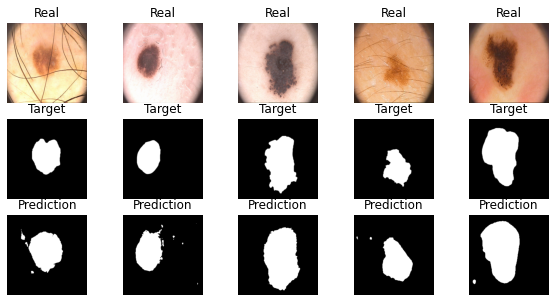

In [228]:
visualize(unet2_model_lovasz)

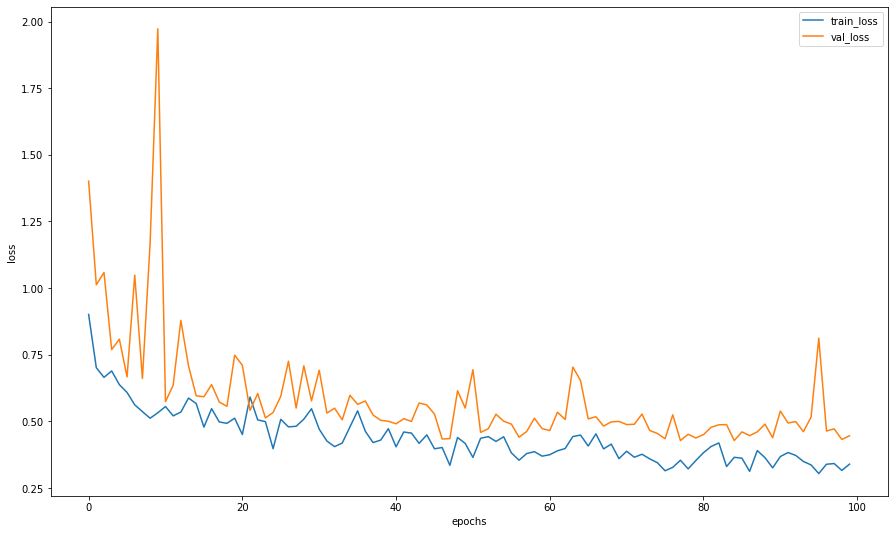

In [217]:
plot_loss(loss, val_loss)

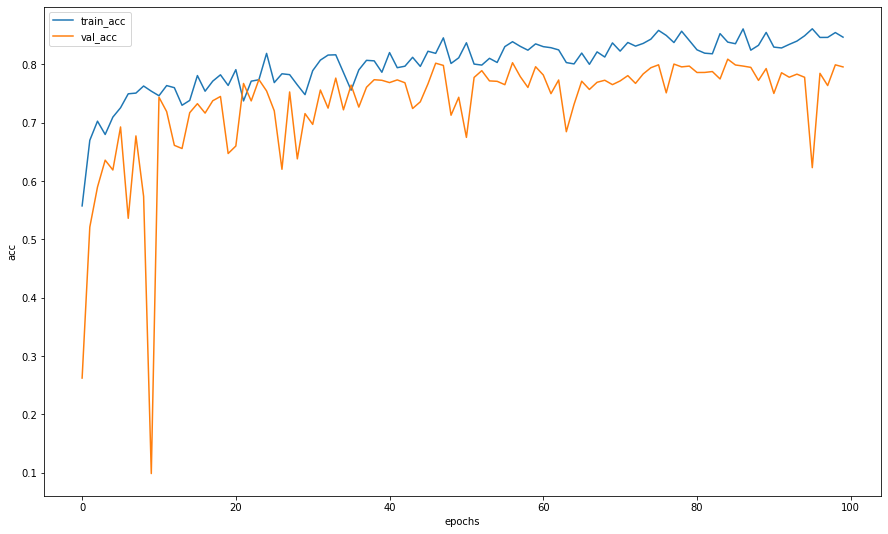

In [218]:
plot_metric(acc, val_acc)

Сохраним модель и ее результаты:

In [219]:
model_save_name = 'model_unet2_lovasz.pth'
path = F"/content/gdrive/My Drive/DLS/nevus/{model_save_name}" 
torch.save(unet2_model_lovasz.state_dict(), path)

In [220]:
np.save(F"/content/gdrive/My Drive/DLS/nevus/history_unet2_lovasz.npy" , history_unet2_lovasz)

In [221]:
del unet2_model_lovasz

## 10. Отчет.

### 10.1. Оценка качества моделей.

Оценим качество моделей на тестовом датасете:


In [283]:
metrics_segnet_bce = score_model(model_segnet_bce, test_dl)
metrics_segnet_dice = score_model(model_segnet_dice, test_dl)
metrics_segnet_focal = score_model(model_segnet_focal, test_dl)
metrics_segnet_lovasz = score_model(model_segnet_lovasz, test_dl)

metrics_unet_bce = score_model(unet_model_bce, test_dl)
metrics_unet_dice = score_model(unet_model_dice, test_dl)
metrics_unet_focal = score_model(unet_model_focal, test_dl)
metrics_unet_lovasz = score_model(unet_model_lovasz, test_dl)

metrics_unet2_bce = score_model(unet2_model_bce, test_dl)
metrics_unet2_dice = score_model(unet2_model_dice, test_dl)
metrics_unet2_focal = score_model(unet2_model_focal, test_dl)
metrics_unet2_lovasz = score_model(unet2_model_lovasz, test_dl)

In [319]:
metrics_result = {'segnet_bce': metrics_segnet_bce, 'segnet_dice': metrics_segnet_dice, 'segnet_focal': metrics_segnet_focal,
                  'segnet_lovasz': metrics_segnet_lovasz, 'unet_bce': metrics_unet_bce, 'unet_dice': metrics_unet_dice,
                  'unet_focal': metrics_unet_focal, 'unet_lovasz': metrics_unet_lovasz, 'unet2_bce': metrics_unet2_bce,
                  'unet2_dice': metrics_unet2_dice, 'unet2_focal': metrics_unet2_focal, 'unet2_lovasz': metrics_unet2_lovasz}
np.save(F"/content/gdrive/My Drive/DLS/nevus/metrics_result.npy", metrics_result)

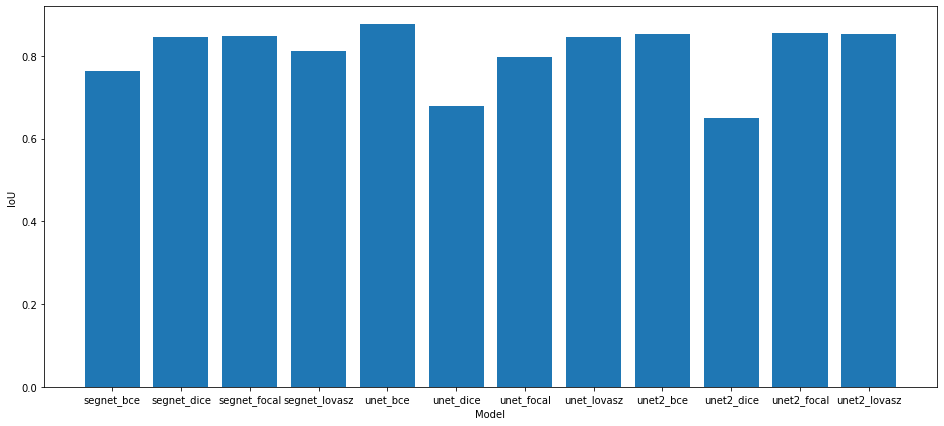

In [330]:
x = list(metrics_result.keys())
y = list(metrics_result.values())
plt.figure(figsize=(16, 7))
plt.bar(x, y)
plt.xlabel("Model")
plt.ylabel("IoU")
plt.show()

Отсюда можно сделать вывод, что наилучший результат показала модель UNet с обучением при помощи функции потерь BCE loss.

Метрика IoU для такой модели составляет 88%:

In [30]:
round(metrics_result[()]['unet_bce'], 2)

0.88

### 10.2. Оценка графиков функции потерь.

Загрузим сохраненные ранее данные для каждой модели:

In [4]:
history_segnet_bce = np.load('/content/gdrive/MyDrive/DLS/nevus/history_segnet_bce.npy', allow_pickle=True)
history_segnet_dice = np.load('/content/gdrive/MyDrive/DLS/nevus/history_segnet_dice.npy', allow_pickle=True)
history_segnet_focal = np.load('/content/gdrive/MyDrive/DLS/nevus/history_segnet_focal.npy', allow_pickle=True)
history_segnet_lovasz = np.load('/content/gdrive/MyDrive/DLS/nevus/history_segnet_lovasz.npy', allow_pickle=True)

history_unet_bce = np.load('/content/gdrive/MyDrive/DLS/nevus/history_unet_bce.npy', allow_pickle=True)
history_unet_dice = np.load('/content/gdrive/MyDrive/DLS/nevus/history_unet_dice.npy', allow_pickle=True)
history_unet_focal = np.load('/content/gdrive/MyDrive/DLS/nevus/history_unet_focal.npy', allow_pickle=True)
history_unet_lovasz = np.load('/content/gdrive/MyDrive/DLS/nevus/history_unet_lovasz.npy', allow_pickle=True)

history_unet2_bce = np.load('/content/gdrive/MyDrive/DLS/nevus/history_unet2_bce.npy', allow_pickle=True)
history_unet2_dice = np.load('/content/gdrive/MyDrive/DLS/nevus/history_unet2_dice.npy', allow_pickle=True)
history_unet2_focal = np.load('/content/gdrive/MyDrive/DLS/nevus/history_unet2_focal.npy', allow_pickle=True)
history_unet2_lovasz = np.load('/content/gdrive/MyDrive/DLS/nevus/history_unet2_lovasz.npy', allow_pickle=True)

In [5]:
loss_segnet_bce, acc_segnet_bce, val_loss_segnet_bce, val_acc_segnet_bce = zip(*history_segnet_bce)
loss_segnet_dice, acc_segnet_dice, val_loss_segnet_dice, val_acc_segnet_dice = zip(*history_segnet_dice)
loss_segnet_focal, acc_segnet_focal, val_loss_segnet_focal, val_acc_segnet_focal = zip(*history_segnet_focal)
loss_segnet_lovasz, acc_segnet_lovasz, val_loss_segnet_lovasz, val_acc_segnet_lovasz = zip(*history_segnet_lovasz)

loss_unet_bce, acc_unet_bce, val_loss_unet_bce, val_acc_unet_bce = zip(*history_unet_bce)
loss_unet_dice, acc_unet_dice, val_loss_unet_dice, val_acc_unet_dice = zip(*history_unet_dice)
loss_unet_focal, acc_unet_focal, val_loss_unet_focal, val_acc_unet_focal = zip(*history_unet_focal)
loss_unet_lovasz, acc_unet_lovasz, val_loss_unet_lovasz, val_acc_unet_lovasz = zip(*history_unet_lovasz)

loss_unet2_bce, acc_unet2_bce, val_loss_unet2_bce, val_acc_unet2_bce = zip(*history_unet2_bce)
loss_unet2_dice, acc_unet2_dice, val_loss_unet2_dice, val_acc_unet2_dice = zip(*history_unet2_dice)
loss_unet2_focal, acc_unet2_focal, val_loss_unet2_focal, val_acc_unet2_focal = zip(*history_unet2_focal)
loss_unet2_lovasz, acc_unet2_lovasz, val_loss_unet2_lovasz, val_acc_unet2_lovasz = zip(*history_unet2_lovasz)

##### 10.2.1. Исследование качества моделей при различных функциях потерь.

Выберем модель, показавшую наилучший результат, для каждой функции потерь:

Рассмотрим BCE loss:

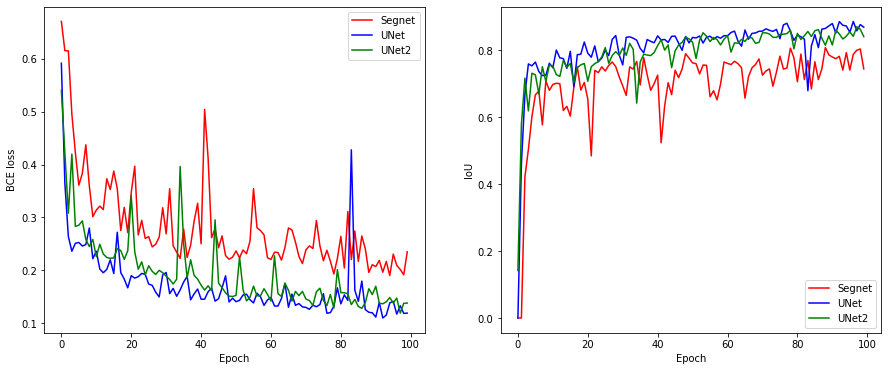

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

axes[0].plot(val_loss_segnet_bce, 'r', label='Segnet')
axes[0].plot(val_loss_unet_bce, 'b', label='UNet')
axes[0].plot(val_loss_unet2_bce, 'g', label='UNet2')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("BCE loss")
axes[0].legend(loc='best')

axes[1].plot(val_acc_segnet_bce, 'r', label='Segnet')
axes[1].plot(val_acc_unet_bce, 'b', label='UNet')
axes[1].plot(val_acc_unet2_bce, 'g', label='UNet2')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("IoU")
axes[1].legend(loc='best')

plt.show()

Из этого графика видно, что BCE loss работает лучше с моделями по типу UNet. Это подтверждается и графиком в пункте 10.1 (а также правым графиком зависимости метрики от эпохи на валидационных данных в текущем пункте) - BCE с Unet и Unet2 дает лучшее качество модели, а с Segnet - худшее.

Рассмотрим Dice loss:

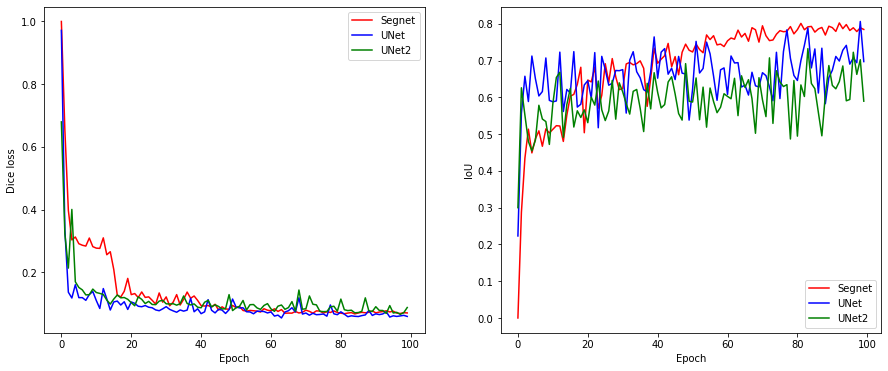

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

axes[0].plot(val_loss_segnet_dice, 'r', label='Segnet')
axes[0].plot(val_loss_unet_dice, 'b', label='UNet')
axes[0].plot(val_loss_unet2_dice, 'g', label='UNet2')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Dice loss")
axes[0].legend(loc='best')

axes[1].plot(val_acc_segnet_dice, 'r', label='Segnet')
axes[1].plot(val_acc_unet_dice, 'b', label='UNet')
axes[1].plot(val_acc_unet2_dice, 'g', label='UNet2')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("IoU")
axes[1].legend(loc='best')

plt.show()

По графику зависимости значения функции потерь от эпохи результат для трех моделей примерно одинаков, однако, если обратить внимание на график зависимости метрики IoU от эпохи, то можно увидеть, что для моделей типа UNet получается нестабильный результат качества. Это подтверждается и графиком из пункта 10.1 - dice loss для UNet моделей дает наихудший результат. При этом для Segnet модели эта функция потерь подходит. 

Рассмотрим Focal loss:

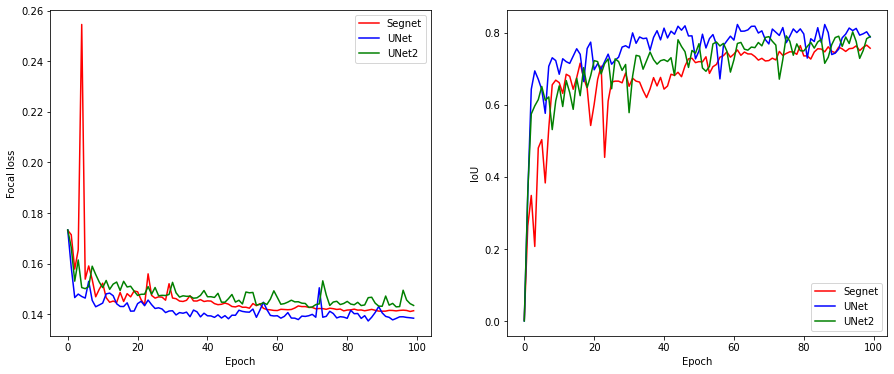

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

axes[0].plot(val_loss_segnet_focal, 'r', label='Segnet')
axes[0].plot(val_loss_unet_focal, 'b', label='UNet')
axes[0].plot(val_loss_unet2_focal, 'g', label='UNet2')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Focal loss")
axes[0].legend(loc='best')

axes[1].plot(val_acc_segnet_focal, 'r', label='Segnet')
axes[1].plot(val_acc_unet_focal, 'b', label='UNet')
axes[1].plot(val_acc_unet2_focal, 'g', label='UNet2')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("IoU")
axes[1].legend(loc='best')

plt.show()

Focal loss на всех моделях отработал примерно одинаково, колебания в качестве модели по графику из пункта 10.1 для разных моделей минимальны - чуть похуже для UNet, получше для UNet2 и Segnet.

Рассмотрим Lovasz loss:

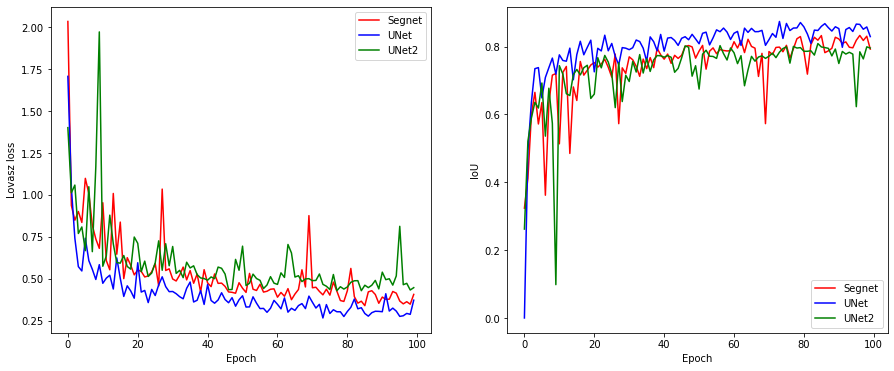

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

axes[0].plot(val_loss_segnet_lovasz, 'r', label='Segnet')
axes[0].plot(val_loss_unet_lovasz, 'b', label='UNet')
axes[0].plot(val_loss_unet2_lovasz, 'g', label='UNet2')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Lovasz loss")
axes[0].legend(loc='best')

axes[1].plot(val_acc_segnet_lovasz, 'r', label='Segnet')
axes[1].plot(val_acc_unet_lovasz, 'b', label='UNet')
axes[1].plot(val_acc_unet2_lovasz, 'g', label='UNet2')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("IoU")
axes[1].legend(loc='best')

plt.show()

Так же ведет себя и Lovasz loss - качество моделей примерно на одном уровне - немного похуже для Segnet, получше для обоих UNetов.

##### 10.2.2. Исследование переобучения моделей.

В этом разделе изучим, при каких функциях потерь модели переобучаются, а при каких нет. Наличие переобучения связано, скорее всего, с отсутствием аугментации данных в данном задании и с малым размером самого датасета.

Рассмотрим Segnet модель:

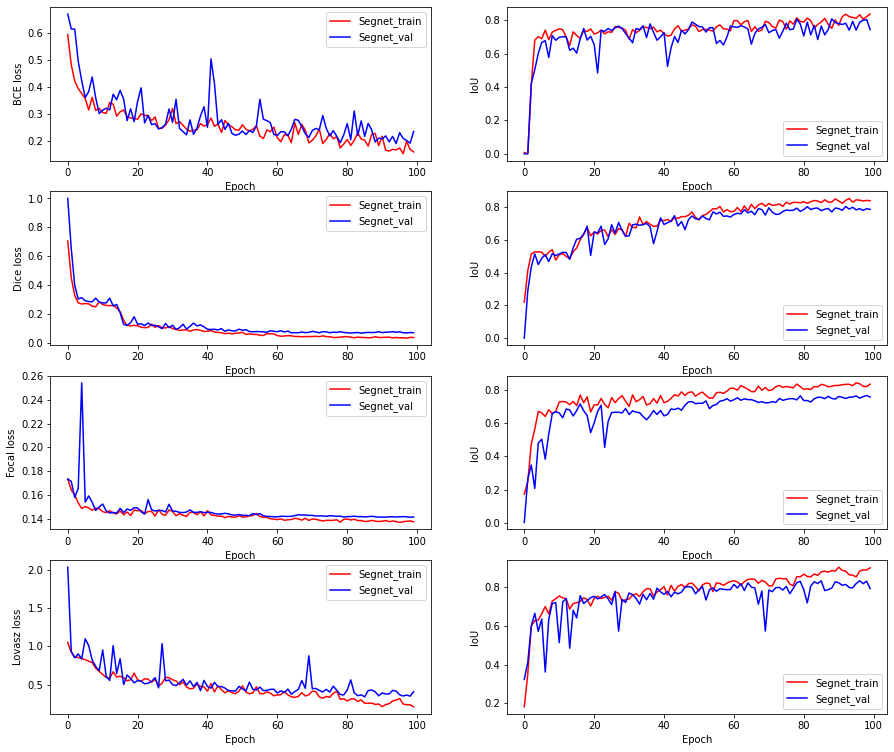

In [41]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 13))

axes[0, 0].plot(loss_segnet_bce, 'r', label='Segnet_train')
axes[0, 0].plot(val_loss_segnet_bce, 'b', label='Segnet_val')
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("BCE loss")
axes[0, 0].legend(loc='best')

axes[0, 1].plot(acc_segnet_bce, 'r', label='Segnet_train')
axes[0, 1].plot(val_acc_segnet_bce, 'b', label='Segnet_val')
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("IoU")
axes[0, 1].legend(loc='best')

axes[1, 0].plot(loss_segnet_dice, 'r', label='Segnet_train')
axes[1, 0].plot(val_loss_segnet_dice, 'b', label='Segnet_val')
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("Dice loss")
axes[1, 0].legend(loc='best')

axes[1, 1].plot(acc_segnet_dice, 'r', label='Segnet_train')
axes[1, 1].plot(val_acc_segnet_dice, 'b', label='Segnet_val')
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_ylabel("IoU")
axes[1, 1].legend(loc='best')

axes[2, 0].plot(loss_segnet_focal, 'r', label='Segnet_train')
axes[2, 0].plot(val_loss_segnet_focal, 'b', label='Segnet_val')
axes[2, 0].set_xlabel("Epoch")
axes[2, 0].set_ylabel("Focal loss")
axes[2, 0].legend(loc='best')

axes[2, 1].plot(acc_segnet_focal, 'r', label='Segnet_train')
axes[2, 1].plot(val_acc_segnet_focal, 'b', label='Segnet_val')
axes[2, 1].set_xlabel("Epoch")
axes[2, 1].set_ylabel("IoU")
axes[2, 1].legend(loc='best')

axes[3, 0].plot(loss_segnet_lovasz, 'r', label='Segnet_train')
axes[3, 0].plot(val_loss_segnet_lovasz, 'b', label='Segnet_val')
axes[3, 0].set_xlabel("Epoch")
axes[3, 0].set_ylabel("Lovasz loss")
axes[3, 0].legend(loc='best')

axes[3, 1].plot(acc_segnet_lovasz, 'r', label='Segnet_train')
axes[3, 1].plot(val_acc_segnet_lovasz, 'b', label='Segnet_val')
axes[3, 1].set_xlabel("Epoch")
axes[3, 1].set_ylabel("IoU")
axes[3, 1].legend(loc='best')

plt.show()

Из графиков видно, что практически во всех случаях начинается переобучение модели после 60 эпохи - появляется зазор между графиками для валидационных данных и для данных, на которых модель обучается. В случае focal loss по графику зависимости значения метрики о эпохи переобучение заметно практически сразу.

Рассмотрим UNet модель:

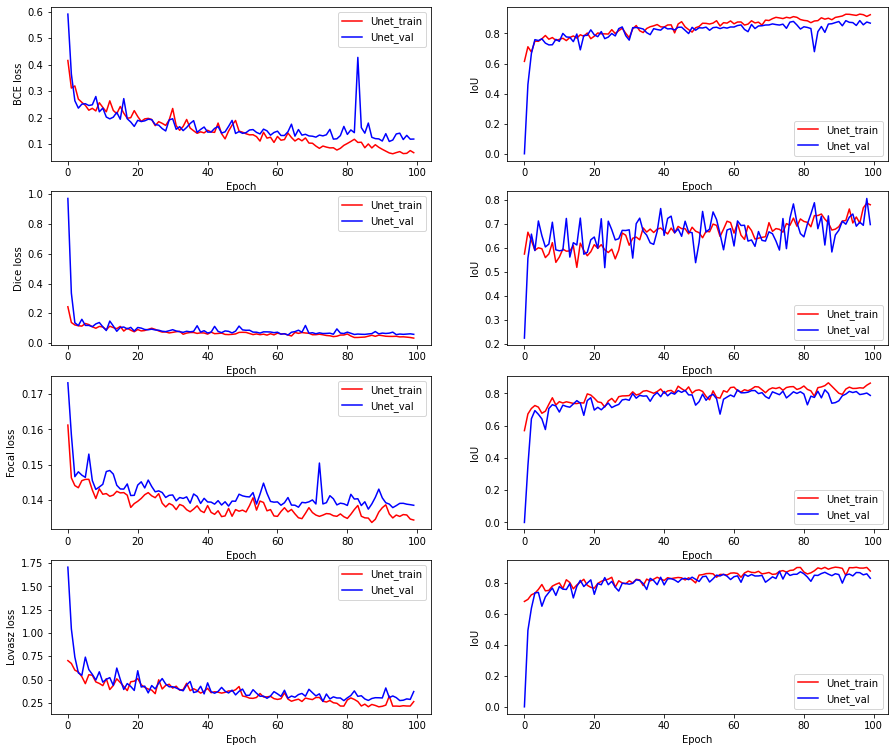

In [42]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 13))

axes[0, 0].plot(loss_unet_bce, 'r', label='Unet_train')
axes[0, 0].plot(val_loss_unet_bce, 'b', label='Unet_val')
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("BCE loss")
axes[0, 0].legend(loc='best')

axes[0, 1].plot(acc_unet_bce, 'r', label='Unet_train')
axes[0, 1].plot(val_acc_unet_bce, 'b', label='Unet_val')
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("IoU")
axes[0, 1].legend(loc='best')

axes[1, 0].plot(loss_unet_dice, 'r', label='Unet_train')
axes[1, 0].plot(val_loss_unet_dice, 'b', label='Unet_val')
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("Dice loss")
axes[1, 0].legend(loc='best')

axes[1, 1].plot(acc_unet_dice, 'r', label='Unet_train')
axes[1, 1].plot(val_acc_unet_dice, 'b', label='Unet_val')
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_ylabel("IoU")
axes[1, 1].legend(loc='best')

axes[2, 0].plot(loss_unet_focal, 'r', label='Unet_train')
axes[2, 0].plot(val_loss_unet_focal, 'b', label='Unet_val')
axes[2, 0].set_xlabel("Epoch")
axes[2, 0].set_ylabel("Focal loss")
axes[2, 0].legend(loc='best')

axes[2, 1].plot(acc_unet_focal, 'r', label='Unet_train')
axes[2, 1].plot(val_acc_unet_focal, 'b', label='Unet_val')
axes[2, 1].set_xlabel("Epoch")
axes[2, 1].set_ylabel("IoU")
axes[2, 1].legend(loc='best')

axes[3, 0].plot(loss_unet_lovasz, 'r', label='Unet_train')
axes[3, 0].plot(val_loss_unet_lovasz, 'b', label='Unet_val')
axes[3, 0].set_xlabel("Epoch")
axes[3, 0].set_ylabel("Lovasz loss")
axes[3, 0].legend(loc='best')

axes[3, 1].plot(acc_unet_lovasz, 'r', label='Unet_train')
axes[3, 1].plot(val_acc_unet_lovasz, 'b', label='Unet_val')
axes[3, 1].set_xlabel("Epoch")
axes[3, 1].set_ylabel("IoU")
axes[3, 1].legend(loc='best')

plt.show()

В UNet модели переобучение с BCE и Lovasz loss наблюдается после 60 эпохи, с focal loss зазор между графиками наблюдается сразу, а с dice loss переобучение минимально (хоть и качество с этой функцией потерь так же минимально по сравнению с другими функциями).

Рассмотрим UNet2 модель:

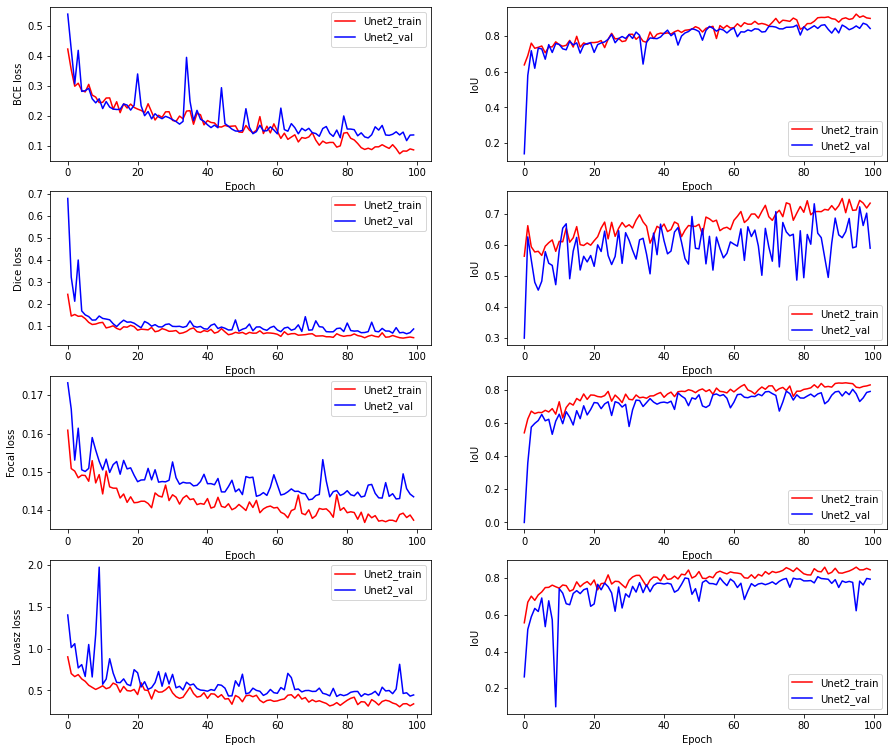

In [44]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 13))

axes[0, 0].plot(loss_unet2_bce, 'r', label='Unet2_train')
axes[0, 0].plot(val_loss_unet2_bce, 'b', label='Unet2_val')
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("BCE loss")
axes[0, 0].legend(loc='best')

axes[0, 1].plot(acc_unet2_bce, 'r', label='Unet2_train')
axes[0, 1].plot(val_acc_unet2_bce, 'b', label='Unet2_val')
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("IoU")
axes[0, 1].legend(loc='best')

axes[1, 0].plot(loss_unet2_dice, 'r', label='Unet2_train')
axes[1, 0].plot(val_loss_unet2_dice, 'b', label='Unet2_val')
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("Dice loss")
axes[1, 0].legend(loc='best')

axes[1, 1].plot(acc_unet2_dice, 'r', label='Unet2_train')
axes[1, 1].plot(val_acc_unet2_dice, 'b', label='Unet2_val')
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_ylabel("IoU")
axes[1, 1].legend(loc='best')

axes[2, 0].plot(loss_unet2_focal, 'r', label='Unet2_train')
axes[2, 0].plot(val_loss_unet2_focal, 'b', label='Unet2_val')
axes[2, 0].set_xlabel("Epoch")
axes[2, 0].set_ylabel("Focal loss")
axes[2, 0].legend(loc='best')

axes[2, 1].plot(acc_unet2_focal, 'r', label='Unet2_train')
axes[2, 1].plot(val_acc_unet2_focal, 'b', label='Unet2_val')
axes[2, 1].set_xlabel("Epoch")
axes[2, 1].set_ylabel("IoU")
axes[2, 1].legend(loc='best')

axes[3, 0].plot(loss_unet2_lovasz, 'r', label='Unet2_train')
axes[3, 0].plot(val_loss_unet2_lovasz, 'b', label='Unet2_val')
axes[3, 0].set_xlabel("Epoch")
axes[3, 0].set_ylabel("Lovasz loss")
axes[3, 0].legend(loc='best')

axes[3, 1].plot(acc_unet2_lovasz, 'r', label='Unet2_train')
axes[3, 1].plot(val_acc_unet2_lovasz, 'b', label='Unet2_val')
axes[3, 1].set_xlabel("Epoch")
axes[3, 1].set_ylabel("IoU")
axes[3, 1].legend(loc='best')

plt.show()

Для UNet2 модели переобучение при dice, focal и Lovasz loss начинается сразу, для BCE loss - после 60 эпохи.

### 10.3. Оценка количества параметров моделей.

Исследуем количество обучаемых параметров моделей:

In [49]:
segnet_model = SegNet().to(DEVICE)
unet_model = UNet().to(DEVICE)
unet2_model = UNet2().to(DEVICE)

In [50]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [51]:
print('SegNet model: ', count_parameters(segnet_model))
print('UNet model: ', count_parameters(unet_model))
print('UNet2 model: ', count_parameters(unet2_model))

SegNet model:  24869773
UNet model:  31390721
UNet2 model:  40060545


Хоть и UNet2 обладает наибольшим количеством обучаемых параметров, он не дал лучший результат. 

### 10.4. Сегментация с помощью разных моделей.

Рассмотрим результаты сегментации для ТОП-3 моделей (UNet c BCE loss - 88%, UNet2 c focal loss - 85% и UNet2 c lovasz loss - 85%):

In [75]:
model_unet_bce = UNet()
model_unet_bce.load_state_dict(torch.load(F"/content/gdrive/My Drive/DLS/nevus/model_unet_bce.pth"))
model_unet2_focal = UNet2()
model_unet2_focal.load_state_dict(torch.load(F"/content/gdrive/My Drive/DLS/nevus/model_unet2_focal.pth"))
model_unet2_lovasz = UNet2()
model_unet2_lovasz.load_state_dict(torch.load(F"/content/gdrive/My Drive/DLS/nevus/model_unet2_lovasz.pth"))

<All keys matched successfully>

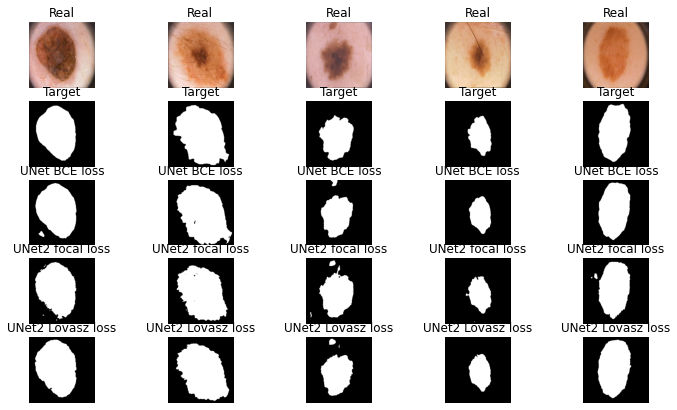

In [83]:
X_val, Y_val = next(iter(val_dl))
plt.figure(figsize=(12,7))
for k in range(BATCH_SIZE):
    plt.subplot(5, BATCH_SIZE, k+1)
    plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
    plt.title('Real')
    plt.axis('off')

    plt.subplot(5, BATCH_SIZE, k+1+BATCH_SIZE)
    plt.imshow(Y_val[k].numpy(), cmap='gray')
    plt.title('Target')
    plt.axis('off')

    plt.subplot(5, BATCH_SIZE, k+1+2*BATCH_SIZE)
    prediction = model_unet_bce(X_val)
    prediction = torch.sigmoid(prediction.squeeze()).round().detach().numpy()
    plt.imshow(prediction[k], cmap='gray')
    plt.title('UNet BCE loss')
    plt.axis('off')

    plt.subplot(5, BATCH_SIZE, k+1+3*BATCH_SIZE)
    prediction = model_unet2_focal(X_val)
    prediction = torch.sigmoid(prediction.squeeze()).round().detach().numpy()
    plt.imshow(prediction[k], cmap='gray')
    plt.title('UNet2 focal loss')
    plt.axis('off')

    plt.subplot(5, BATCH_SIZE, k+1+4*BATCH_SIZE)
    prediction = model_unet2_lovasz(X_val)
    prediction = torch.sigmoid(prediction.squeeze()).round().detach().numpy()
    plt.imshow(prediction[k], cmap='gray')
    plt.title('UNet2 Lovasz loss')
    plt.axis('off')
plt.show()

Все три модели достаточно хорошо сегментируют образования кожи. Интересное замечание - на третьей фотографии есть дополнительная родинка и все три модели ее нашли, хотя она не отмечена в таргете.

Сравним наилучшую и наихудшую модели - Unet c BCE loss (88%) и Unet2 c dice loss (65%):

In [85]:
model_unet2_dice = UNet2()
model_unet2_dice.load_state_dict(torch.load(F"/content/gdrive/My Drive/DLS/nevus/model_unet2_dice.pth"))

<All keys matched successfully>

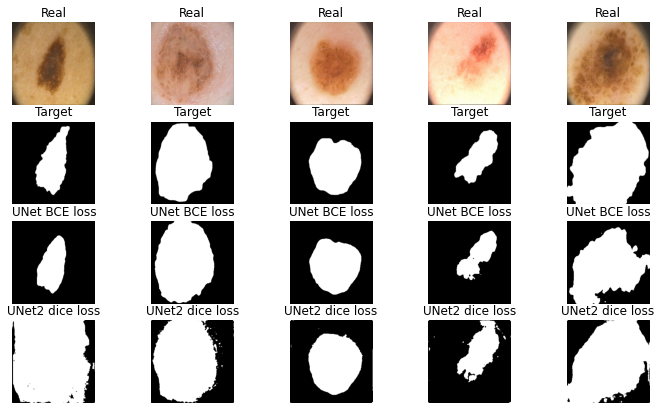

In [88]:
X_val, Y_val = next(iter(val_dl))
plt.figure(figsize=(12,7))
for k in range(BATCH_SIZE):
    plt.subplot(4, BATCH_SIZE, k+1)
    plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
    plt.title('Real')
    plt.axis('off')

    plt.subplot(4, BATCH_SIZE, k+1+BATCH_SIZE)
    plt.imshow(Y_val[k].numpy(), cmap='gray')
    plt.title('Target')
    plt.axis('off')

    plt.subplot(4, BATCH_SIZE, k+1+2*BATCH_SIZE)
    prediction = model_unet_bce(X_val)
    prediction = torch.sigmoid(prediction.squeeze()).round().detach().numpy()
    plt.imshow(prediction[k], cmap='gray')
    plt.title('UNet BCE loss')
    plt.axis('off')

    plt.subplot(4, BATCH_SIZE, k+1+3*BATCH_SIZE)
    prediction = model_unet2_dice(X_val)
    prediction = torch.sigmoid(prediction.squeeze()).round().detach().numpy()
    plt.imshow(prediction[k], cmap='gray')
    plt.title('UNet2 dice loss')
    plt.axis('off')
plt.show()